## Deep Convolutional Classificator using Fashion MNIST dataset

![alt text](fashion-mnist_long.png)

In this project, we will make a convolutional neural network (hereafter CNN) to classify the different fashion images contained on the [Fashion MNIST dataset](https://www.kaggle.com/zalando-research/fashionmnist). This dataset consists of a set of 70000 images of 28 x 28 pixels in greyscale. Such images can be of 10 different labels, corresponding to 

| Label number | Label |
| --- | --- |
| 0 | T-shirt |
| 1 | Trouser |
| 2 | Pullover |
| 3 | Dress |
| 4 | Coat |
| 5 | Sandal |
| 6 | Shirt |
| 7 | Sneaker |
| 8 | Bag |
| 9 | Ankle boot |

We will implement a CNN whose aim is to predict the label given the image. Let us start importing the packages.

In [1]:
import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor, Lambda, Compose
from torchvision.datasets import FashionMNIST
import matplotlib.pyplot as plt
import matplotlib.font_manager
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.metrics as met
import torch.optim as optim

As usual in machine learning models, we need to define the hyperparameters of the CNN. We do this now because it is very important to be organized while programming and we will need the batch size soon, so we put all these parameters together and we present them now.

In [2]:
# Model parameters
n_inputs = 196
n_hidden = 98
n_outputs = 10
in_channels = 1
out_channels = 1
kernel_size_1 = 7
kernel_size_2 = 5
p_dropout = 0.1   # Dropout probability
batch_size = 1000   # Mini-batch
lr = 1e-3   # Learning rate
n_epochs = 300   # Number of epochs

# Fonts to the plots
fuente_ejes = matplotlib.font_manager.FontProperties()
fuente_ejes.set_family('serif')
fuente_ejes.set_style('normal')
    
fuente_nombre = matplotlib.font_manager.FontProperties()
fuente_nombre.set_family('serif')
fuente_nombre.set_style('italic')

fuente_titulo = matplotlib.font_manager.FontProperties()
fuente_titulo.set_size(10)
fuente_titulo.set_name('sans-serif')
fuente_titulo.set_style('normal')
fuente_titulo.set_weight('semibold')

In [3]:
# We create a custom Dataset class to work the images
class CustomImageDataset(Dataset):
    def __init__(self, dataset):
        super().__init__()
        self.dataset = dataset
        
    # We redefine the __len__() method
    def __len__(self):
        return len(self.dataset)
    
    # We redefine the __getitem__() method
    def __getitem__(self, i):
        image, label = self.dataset[i]
        # We rewrite the original label to allow it be able to be compared against the model predictions
        zer = torch.zeros(10)
        zer[label] = 1.
        label = zer
        return image, label

In [4]:
# Download training data
train_d = FashionMNIST(
    root='Dataset',
    train=True,
    download=True,
    transform=ToTensor(),
)

train_data = train_d
train_data = CustomImageDataset(train_data)

# Download test data
test_d = FashionMNIST(
    root="Dataset",
    train=False,
    download=True,
    transform=ToTensor(),
)

test_data = test_d
test_data = CustomImageDataset(test_data)

In [5]:
# Check some info about the data downloaded
train_data.__class__.__mro__

(__main__.CustomImageDataset,
 torch.utils.data.dataset.Dataset,
 typing.Generic,
 object)

In [6]:
# Check some info about the data downloaded
test_data.__class__.__mro__

(__main__.CustomImageDataset,
 torch.utils.data.dataset.Dataset,
 typing.Generic,
 object)

Once we have loaded the Dataset objects it is time to instantiate the Dataloader objects in order to get the proper inputs to the CNN. Also, it is possible to train the CNN in batches if the inputs are Dataloader objects.

In [8]:
train_dl = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(test_data, batch_size=batch_size, shuffle=False)

We can check if cuda is available for training. The use of cuda optimizes the training process, allowing us to use the different GPUs we have in our computer.

In [9]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cpu device


Now we have loaded the dataset and we transformed it in appropiate Dataloader objects, it is time to define the model we will train to predict the label of the image used as input. As said before, the model is a CNN, and the architecture of such a network will be explained right now.

In [10]:
# Model definition
class Model(nn.Module):
    # Define model elements
    def __init__(self):
        # The super() builtin returns a proxy object (temporary object of the superclass)
        # that allows us to access methods of the base class.
        super().__init__()
        # Sequence of transformations implemented by the layers of the network
        self.cnn = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size_1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size_2, stride=1),
            nn.Conv2d(in_channels, out_channels, kernel_size_2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(n_inputs, n_hidden),
            nn.Dropout(0.1),
            nn.ReLU(),
            nn.Linear(n_hidden, n_outputs),
            nn.Softmax()
        )
 
    # Method to transform inputs in outputs considering the internal structure of the network
    def forward(self, X):
        output = self.cnn(X)
        return output
    
# Now we can create a model and send it at once to the device
model = Model().to(device)
# We can also inspect its parameters using its state_dict() method
print(model.state_dict())

OrderedDict([('cnn.0.weight', tensor([[[[-0.0823,  0.0918, -0.0720,  0.0906, -0.1267,  0.0912, -0.1021],
          [-0.0907, -0.0191,  0.0008,  0.1390, -0.1118,  0.0378, -0.1220],
          [ 0.1373,  0.0195,  0.0432, -0.0239, -0.0153, -0.0339,  0.1129],
          [-0.0115,  0.1379,  0.0178, -0.0513,  0.0343, -0.0059, -0.0846],
          [ 0.0446,  0.0049,  0.0005, -0.0868, -0.1399, -0.0038,  0.0666],
          [-0.0371, -0.0207,  0.0331, -0.1365, -0.0578,  0.1328, -0.1011],
          [-0.0401, -0.0215,  0.1372,  0.0430,  0.0024,  0.1094, -0.0256]]]])), ('cnn.0.bias', tensor([-0.0104])), ('cnn.3.weight', tensor([[[[ 0.0369, -0.1551, -0.1041,  0.0291, -0.1788],
          [ 0.1753,  0.0394, -0.1486, -0.1285, -0.1927],
          [-0.1419,  0.1534,  0.1920, -0.1026,  0.0863],
          [ 0.0008,  0.1161,  0.0699,  0.1547,  0.0036],
          [ 0.0953, -0.0956,  0.1887,  0.1164,  0.0937]]]])), ('cnn.3.bias', tensor([-0.1280])), ('cnn.6.weight', tensor([[-0.0476,  0.0427,  0.0636,  ...,  0.0

![alt text](red.JPG)
###### Architecture of the CNN. 'Achatamiento' means flattening in spanish.

Now we have defined the model, we want to train it. So, let us take a look at the dataset.

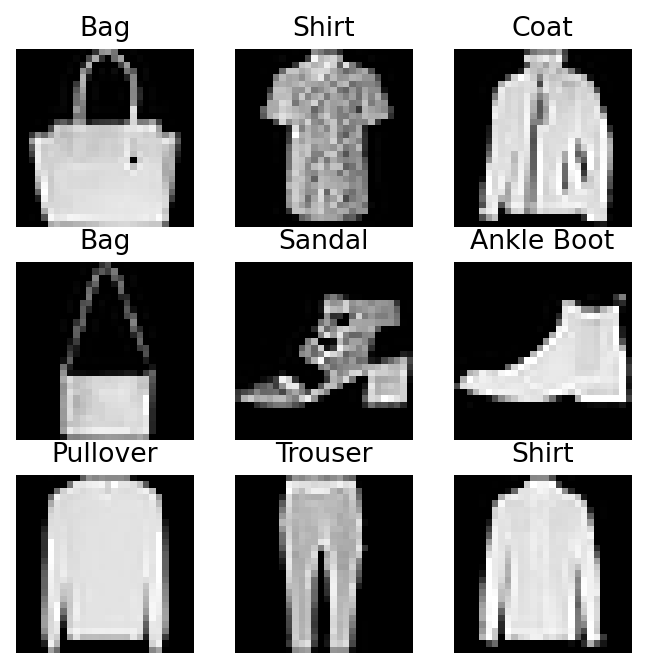

In [11]:
# Labels of the clothes based on the table given at the beggining of the notebook
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

# Plot of a random sample of tain_data
figure = plt.figure(figsize=(5, 5), dpi=160)
cols, rows = 3, 3
for i in range(1, cols*rows + 1):
    sample_idx = torch.randint(len(train_d), size=(1,)).item()
    img, label = train_d[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()
#plt.savefig('examples.jpg', bbox_inches='tight')

Let us make some statistical analysis regarding the labels. In doing so, we are going to be able to see if the dataset is imbalanced or not.

In [12]:
# Let us convert the targets tensors into a pandas DataFrame object to make easier the computations
df_train = pd.DataFrame(train_d.targets.numpy(), columns = ['Labels'])
df_test = pd.DataFrame(test_d.targets.numpy(), columns = ['Labels'])

Now we have a DataFrame object we can inspect the targets.

In [13]:
# Let us see the value counts of the train labels
df_train.value_counts()

Labels
0         6000
1         6000
2         6000
3         6000
4         6000
5         6000
6         6000
7         6000
8         6000
9         6000
dtype: int64

In [14]:
# Let us see the value counts of the test labels
df_test.value_counts()

Labels
0         1000
1         1000
2         1000
3         1000
4         1000
5         1000
6         1000
7         1000
8         1000
9         1000
dtype: int64

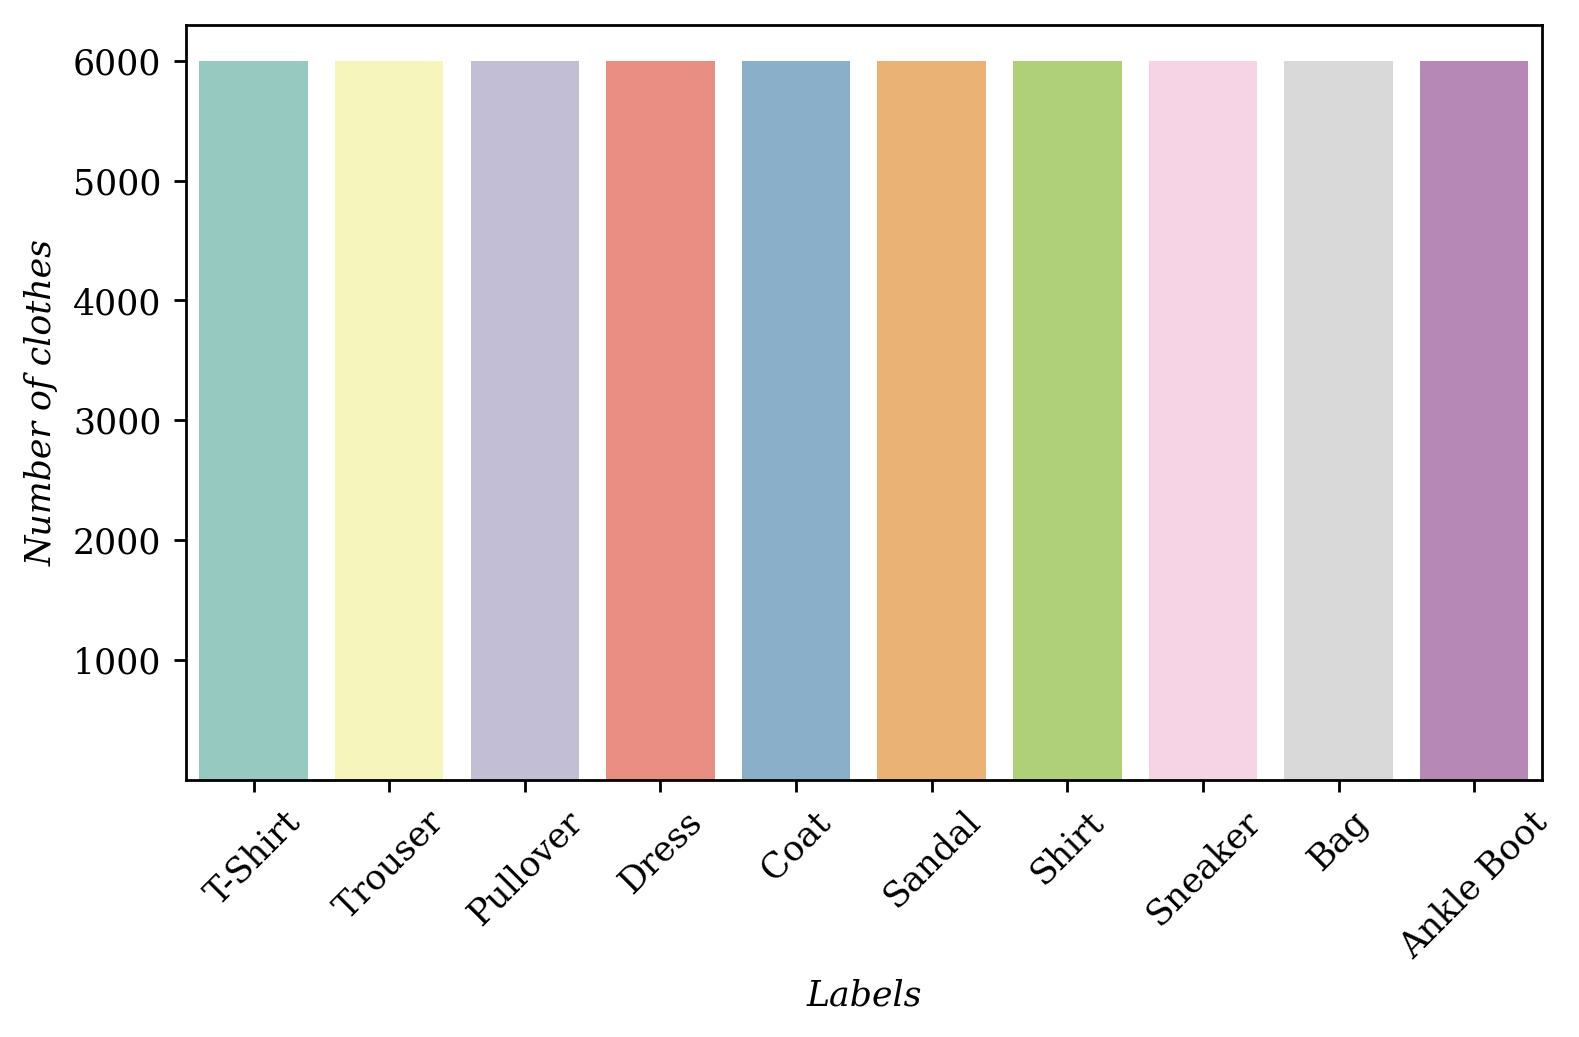

In [17]:
# We can make a countplot using seaborn
p = sns.countplot(x="Labels", data=df_train, palette='Set3', figure=plt.figure(figsize=(7,4), dpi=250))
p.set_xlabel("Labels", font_properties=fuente_nombre)
p.set_ylabel("Number of clothes", font_properties=fuente_nombre)
p.set_xticks([i for i in range(10)])
p.set_xticklabels(list(labels_map.values()), font_properties=fuente_ejes, rotation=45)
p.set_yticks([1000, 2000, 3000, 4000, 5000, 6000])
p.set_yticklabels(['1000', '2000', '3000', '4000', '5000', '6000'], font_properties=fuente_ejes)
plt.show()
#plt.savefig('countplot_train.jpg', bbox_inches='tight')

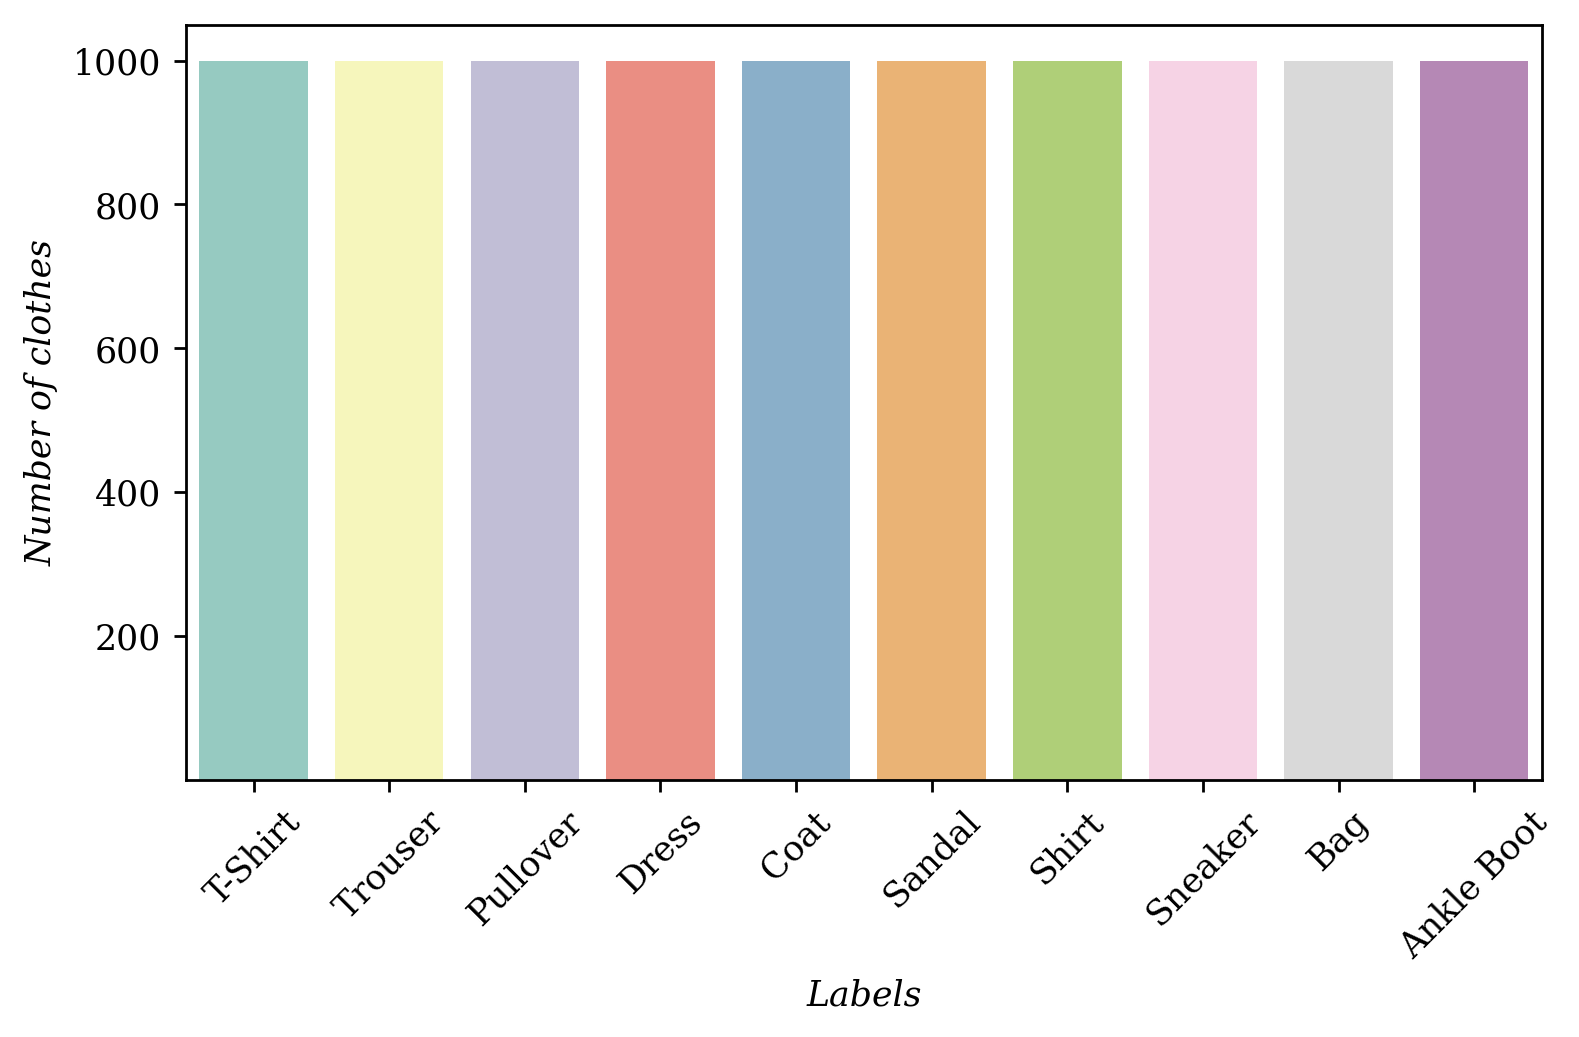

In [18]:
g = sns.countplot(x="Labels", data=df_test, palette='Set3', figure=plt.figure(figsize=(7,4), dpi=250))
g.set_xlabel("Labels", font_properties=fuente_nombre)
g.set_ylabel("Number of clothes", font_properties=fuente_nombre)
g.set_xticks([i for i in range(10)])
g.set_xticklabels(list(labels_map.values()), font_properties=fuente_ejes, rotation=45)
g.set_yticks([200, 400, 600, 800, 1000])
g.set_yticklabels(['200', '400', '600', '800', '1000'], font_properties=fuente_ejes)
plt.show()
#plt.savefig('countplot_test.jpg', bbox_inches='tight')

We can see that the training labels are perfectly balanced, making the training process easier than in the case of imbalanced classes. Note that we have labels that are encoded, so it is not needed to apply the label encoding method on the targets. To move forward, we have to define the function that will perform the training of the CNN.

In [20]:
# We define the training function
def train_loop(dataloader, model, loss_fn, optimizer):
    size = int(len(dataloader.dataset)/1000)
    tmp = []

    # We iterate over batches
    for batch, (X, y) in enumerate(dataloader):
        # We calculate the model's prediction
        pred = model(X)
        # With the model's prediction we calculate the loss function
        loss = loss_fn(pred, y)

        # We apply the backpropagation method
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Training progress
        loss, current = loss.item(), batch
        tmp.append(loss)
        print(f"Actual batch = {current} | Loss = {loss:>7f} | Processed samples: [{current:>2d}/{size:>2d}]")
    
    tmp = np.array(tmp)
    loss_avg = tmp.sum()/len(tmp)
    return loss_avg

# We define the test function
def test_loop(dataloader, model, loss_fn, num_batches):
    size = int(len(dataloader.dataset)/1000)
    test_loss = 0
    j = 0
    
    # To test, we need to deactivate the calculation of the gradients
    with torch.no_grad():
        # We iterate over batches
        for X, y in dataloader:
            # Model's prection
            pred = model(X)
            # Corresponding errors, which we acumulate in a total value
            test_loss += loss_fn(pred, y).item()
            j += 1
            
    # We calculate the total loss and print it
    test_loss /= j
    print(f"Test Error: Avg loss = {test_loss:>8f} \n")
    return test_loss

In order to train the model, we need to instanciate an optimizer object and a loss function object. Let us do this.

In [21]:
# Loss function object. It is a Medium Squared Error.
loss_fn = nn.MSELoss()

# We instantiate an optimizer. In this case we choose an Adam optimizer.
optimizer = torch.optim.Adam(model.parameters(), lr=lr, eps=1e-08, weight_decay=0, amsgrad=False)

In [22]:
# Print model's state_dict size to gain some perspective about the model
print("Model's state_dict size:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

Model's state_dict size:
cnn.0.weight 	 torch.Size([1, 1, 7, 7])
cnn.0.bias 	 torch.Size([1])
cnn.3.weight 	 torch.Size([1, 1, 5, 5])
cnn.3.bias 	 torch.Size([1])
cnn.6.weight 	 torch.Size([98, 196])
cnn.6.bias 	 torch.Size([98])
cnn.9.weight 	 torch.Size([10, 98])
cnn.9.bias 	 torch.Size([10])


We will plot the loss function against the epochs

In [24]:
# We define a loss array to plot the training loss function and the testing loss function
loss_to_plot = []
loss_to_plot_test = []

We are ready to train the model. Let us train it during $n_{epochs}$ epochs, as defined above.

In [25]:
# We train the model iterating over the different epochs
for t in range(n_epochs):
    print(f"Epoch {t+1}\n=============================================")
    loss_to_plot.append(train_loop(train_dl, model, loss_fn, optimizer))
    loss_to_plot_test.append(test_loop(test_dl, model, loss_fn, batch_size))
print("Done!")

Epoch 1


C:\Users\santy\anaconda3\envs\env-ml\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Actual batch = 0 | Loss = 0.090025 | Processed samples: [ 0/60]
Actual batch = 1 | Loss = 0.089999 | Processed samples: [ 1/60]
Actual batch = 2 | Loss = 0.090010 | Processed samples: [ 2/60]
Actual batch = 3 | Loss = 0.089955 | Processed samples: [ 3/60]
Actual batch = 4 | Loss = 0.089988 | Processed samples: [ 4/60]
Actual batch = 5 | Loss = 0.089975 | Processed samples: [ 5/60]
Actual batch = 6 | Loss = 0.089997 | Processed samples: [ 6/60]
Actual batch = 7 | Loss = 0.089954 | Processed samples: [ 7/60]
Actual batch = 8 | Loss = 0.089924 | Processed samples: [ 8/60]
Actual batch = 9 | Loss = 0.089845 | Processed samples: [ 9/60]
Actual batch = 10 | Loss = 0.089682 | Processed samples: [10/60]
Actual batch = 11 | Loss = 0.089593 | Processed samples: [11/60]
Actual batch = 12 | Loss = 0.089494 | Processed samples: [12/60]
Actual batch = 13 | Loss = 0.089396 | Processed samples: [13/60]
Actual batch = 14 | Loss = 0.089273 | Processed samples: [14/60]
Actual batch = 15 | Loss = 0.089230

Actual batch = 5 | Loss = 0.047650 | Processed samples: [ 5/60]
Actual batch = 6 | Loss = 0.046239 | Processed samples: [ 6/60]
Actual batch = 7 | Loss = 0.047167 | Processed samples: [ 7/60]
Actual batch = 8 | Loss = 0.046126 | Processed samples: [ 8/60]
Actual batch = 9 | Loss = 0.045340 | Processed samples: [ 9/60]
Actual batch = 10 | Loss = 0.044687 | Processed samples: [10/60]
Actual batch = 11 | Loss = 0.045473 | Processed samples: [11/60]
Actual batch = 12 | Loss = 0.046223 | Processed samples: [12/60]
Actual batch = 13 | Loss = 0.045282 | Processed samples: [13/60]
Actual batch = 14 | Loss = 0.047960 | Processed samples: [14/60]
Actual batch = 15 | Loss = 0.043587 | Processed samples: [15/60]
Actual batch = 16 | Loss = 0.045389 | Processed samples: [16/60]
Actual batch = 17 | Loss = 0.047817 | Processed samples: [17/60]
Actual batch = 18 | Loss = 0.043804 | Processed samples: [18/60]
Actual batch = 19 | Loss = 0.041229 | Processed samples: [19/60]
Actual batch = 20 | Loss = 0.0

Actual batch = 9 | Loss = 0.036583 | Processed samples: [ 9/60]
Actual batch = 10 | Loss = 0.039655 | Processed samples: [10/60]
Actual batch = 11 | Loss = 0.037750 | Processed samples: [11/60]
Actual batch = 12 | Loss = 0.037454 | Processed samples: [12/60]
Actual batch = 13 | Loss = 0.038370 | Processed samples: [13/60]
Actual batch = 14 | Loss = 0.037280 | Processed samples: [14/60]
Actual batch = 15 | Loss = 0.038550 | Processed samples: [15/60]
Actual batch = 16 | Loss = 0.036655 | Processed samples: [16/60]
Actual batch = 17 | Loss = 0.037613 | Processed samples: [17/60]
Actual batch = 18 | Loss = 0.036318 | Processed samples: [18/60]
Actual batch = 19 | Loss = 0.035322 | Processed samples: [19/60]
Actual batch = 20 | Loss = 0.036046 | Processed samples: [20/60]
Actual batch = 21 | Loss = 0.038493 | Processed samples: [21/60]
Actual batch = 22 | Loss = 0.038968 | Processed samples: [22/60]
Actual batch = 23 | Loss = 0.037268 | Processed samples: [23/60]
Actual batch = 24 | Loss =

Actual batch = 14 | Loss = 0.034865 | Processed samples: [14/60]
Actual batch = 15 | Loss = 0.034155 | Processed samples: [15/60]
Actual batch = 16 | Loss = 0.033272 | Processed samples: [16/60]
Actual batch = 17 | Loss = 0.038335 | Processed samples: [17/60]
Actual batch = 18 | Loss = 0.036864 | Processed samples: [18/60]
Actual batch = 19 | Loss = 0.034971 | Processed samples: [19/60]
Actual batch = 20 | Loss = 0.034086 | Processed samples: [20/60]
Actual batch = 21 | Loss = 0.033671 | Processed samples: [21/60]
Actual batch = 22 | Loss = 0.033626 | Processed samples: [22/60]
Actual batch = 23 | Loss = 0.033374 | Processed samples: [23/60]
Actual batch = 24 | Loss = 0.035297 | Processed samples: [24/60]
Actual batch = 25 | Loss = 0.033788 | Processed samples: [25/60]
Actual batch = 26 | Loss = 0.035739 | Processed samples: [26/60]
Actual batch = 27 | Loss = 0.034545 | Processed samples: [27/60]
Actual batch = 28 | Loss = 0.033377 | Processed samples: [28/60]
Actual batch = 29 | Loss 

Actual batch = 19 | Loss = 0.032712 | Processed samples: [19/60]
Actual batch = 20 | Loss = 0.030144 | Processed samples: [20/60]
Actual batch = 21 | Loss = 0.031581 | Processed samples: [21/60]
Actual batch = 22 | Loss = 0.031867 | Processed samples: [22/60]
Actual batch = 23 | Loss = 0.033052 | Processed samples: [23/60]
Actual batch = 24 | Loss = 0.031551 | Processed samples: [24/60]
Actual batch = 25 | Loss = 0.034999 | Processed samples: [25/60]
Actual batch = 26 | Loss = 0.032550 | Processed samples: [26/60]
Actual batch = 27 | Loss = 0.031998 | Processed samples: [27/60]
Actual batch = 28 | Loss = 0.033786 | Processed samples: [28/60]
Actual batch = 29 | Loss = 0.032984 | Processed samples: [29/60]
Actual batch = 30 | Loss = 0.030784 | Processed samples: [30/60]
Actual batch = 31 | Loss = 0.033622 | Processed samples: [31/60]
Actual batch = 32 | Loss = 0.034131 | Processed samples: [32/60]
Actual batch = 33 | Loss = 0.033823 | Processed samples: [33/60]
Actual batch = 34 | Loss 

Actual batch = 24 | Loss = 0.031494 | Processed samples: [24/60]
Actual batch = 25 | Loss = 0.030937 | Processed samples: [25/60]
Actual batch = 26 | Loss = 0.031279 | Processed samples: [26/60]
Actual batch = 27 | Loss = 0.031021 | Processed samples: [27/60]
Actual batch = 28 | Loss = 0.031392 | Processed samples: [28/60]
Actual batch = 29 | Loss = 0.032857 | Processed samples: [29/60]
Actual batch = 30 | Loss = 0.031212 | Processed samples: [30/60]
Actual batch = 31 | Loss = 0.031873 | Processed samples: [31/60]
Actual batch = 32 | Loss = 0.032294 | Processed samples: [32/60]
Actual batch = 33 | Loss = 0.032892 | Processed samples: [33/60]
Actual batch = 34 | Loss = 0.034648 | Processed samples: [34/60]
Actual batch = 35 | Loss = 0.032754 | Processed samples: [35/60]
Actual batch = 36 | Loss = 0.030513 | Processed samples: [36/60]
Actual batch = 37 | Loss = 0.033736 | Processed samples: [37/60]
Actual batch = 38 | Loss = 0.031067 | Processed samples: [38/60]
Actual batch = 39 | Loss 

Actual batch = 28 | Loss = 0.030253 | Processed samples: [28/60]
Actual batch = 29 | Loss = 0.029968 | Processed samples: [29/60]
Actual batch = 30 | Loss = 0.029359 | Processed samples: [30/60]
Actual batch = 31 | Loss = 0.032443 | Processed samples: [31/60]
Actual batch = 32 | Loss = 0.030847 | Processed samples: [32/60]
Actual batch = 33 | Loss = 0.030755 | Processed samples: [33/60]
Actual batch = 34 | Loss = 0.029468 | Processed samples: [34/60]
Actual batch = 35 | Loss = 0.030563 | Processed samples: [35/60]
Actual batch = 36 | Loss = 0.029824 | Processed samples: [36/60]
Actual batch = 37 | Loss = 0.030290 | Processed samples: [37/60]
Actual batch = 38 | Loss = 0.032807 | Processed samples: [38/60]
Actual batch = 39 | Loss = 0.029919 | Processed samples: [39/60]
Actual batch = 40 | Loss = 0.032023 | Processed samples: [40/60]
Actual batch = 41 | Loss = 0.031145 | Processed samples: [41/60]
Actual batch = 42 | Loss = 0.031956 | Processed samples: [42/60]
Actual batch = 43 | Loss 

Actual batch = 32 | Loss = 0.029383 | Processed samples: [32/60]
Actual batch = 33 | Loss = 0.029985 | Processed samples: [33/60]
Actual batch = 34 | Loss = 0.029098 | Processed samples: [34/60]
Actual batch = 35 | Loss = 0.032870 | Processed samples: [35/60]
Actual batch = 36 | Loss = 0.030183 | Processed samples: [36/60]
Actual batch = 37 | Loss = 0.029269 | Processed samples: [37/60]
Actual batch = 38 | Loss = 0.030110 | Processed samples: [38/60]
Actual batch = 39 | Loss = 0.027878 | Processed samples: [39/60]
Actual batch = 40 | Loss = 0.028239 | Processed samples: [40/60]
Actual batch = 41 | Loss = 0.029496 | Processed samples: [41/60]
Actual batch = 42 | Loss = 0.028819 | Processed samples: [42/60]
Actual batch = 43 | Loss = 0.030189 | Processed samples: [43/60]
Actual batch = 44 | Loss = 0.030632 | Processed samples: [44/60]
Actual batch = 45 | Loss = 0.030349 | Processed samples: [45/60]
Actual batch = 46 | Loss = 0.026828 | Processed samples: [46/60]
Actual batch = 47 | Loss 

Actual batch = 36 | Loss = 0.028519 | Processed samples: [36/60]
Actual batch = 37 | Loss = 0.027941 | Processed samples: [37/60]
Actual batch = 38 | Loss = 0.027579 | Processed samples: [38/60]
Actual batch = 39 | Loss = 0.028513 | Processed samples: [39/60]
Actual batch = 40 | Loss = 0.031342 | Processed samples: [40/60]
Actual batch = 41 | Loss = 0.029391 | Processed samples: [41/60]
Actual batch = 42 | Loss = 0.029259 | Processed samples: [42/60]
Actual batch = 43 | Loss = 0.027945 | Processed samples: [43/60]
Actual batch = 44 | Loss = 0.028910 | Processed samples: [44/60]
Actual batch = 45 | Loss = 0.028949 | Processed samples: [45/60]
Actual batch = 46 | Loss = 0.029938 | Processed samples: [46/60]
Actual batch = 47 | Loss = 0.028756 | Processed samples: [47/60]
Actual batch = 48 | Loss = 0.030177 | Processed samples: [48/60]
Actual batch = 49 | Loss = 0.028977 | Processed samples: [49/60]
Actual batch = 50 | Loss = 0.031067 | Processed samples: [50/60]
Actual batch = 51 | Loss 

Actual batch = 40 | Loss = 0.025625 | Processed samples: [40/60]
Actual batch = 41 | Loss = 0.032411 | Processed samples: [41/60]
Actual batch = 42 | Loss = 0.027927 | Processed samples: [42/60]
Actual batch = 43 | Loss = 0.027812 | Processed samples: [43/60]
Actual batch = 44 | Loss = 0.027125 | Processed samples: [44/60]
Actual batch = 45 | Loss = 0.027111 | Processed samples: [45/60]
Actual batch = 46 | Loss = 0.027148 | Processed samples: [46/60]
Actual batch = 47 | Loss = 0.031178 | Processed samples: [47/60]
Actual batch = 48 | Loss = 0.028915 | Processed samples: [48/60]
Actual batch = 49 | Loss = 0.026695 | Processed samples: [49/60]
Actual batch = 50 | Loss = 0.026556 | Processed samples: [50/60]
Actual batch = 51 | Loss = 0.025976 | Processed samples: [51/60]
Actual batch = 52 | Loss = 0.027806 | Processed samples: [52/60]
Actual batch = 53 | Loss = 0.030694 | Processed samples: [53/60]
Actual batch = 54 | Loss = 0.030786 | Processed samples: [54/60]
Actual batch = 55 | Loss 

Actual batch = 45 | Loss = 0.029438 | Processed samples: [45/60]
Actual batch = 46 | Loss = 0.027850 | Processed samples: [46/60]
Actual batch = 47 | Loss = 0.028920 | Processed samples: [47/60]
Actual batch = 48 | Loss = 0.027235 | Processed samples: [48/60]
Actual batch = 49 | Loss = 0.025603 | Processed samples: [49/60]
Actual batch = 50 | Loss = 0.029363 | Processed samples: [50/60]
Actual batch = 51 | Loss = 0.026132 | Processed samples: [51/60]
Actual batch = 52 | Loss = 0.028110 | Processed samples: [52/60]
Actual batch = 53 | Loss = 0.025569 | Processed samples: [53/60]
Actual batch = 54 | Loss = 0.028447 | Processed samples: [54/60]
Actual batch = 55 | Loss = 0.026279 | Processed samples: [55/60]
Actual batch = 56 | Loss = 0.027641 | Processed samples: [56/60]
Actual batch = 57 | Loss = 0.025674 | Processed samples: [57/60]
Actual batch = 58 | Loss = 0.029795 | Processed samples: [58/60]
Actual batch = 59 | Loss = 0.025903 | Processed samples: [59/60]
Test Error: Avg loss = 0.

Actual batch = 49 | Loss = 0.029976 | Processed samples: [49/60]
Actual batch = 50 | Loss = 0.026058 | Processed samples: [50/60]
Actual batch = 51 | Loss = 0.027047 | Processed samples: [51/60]
Actual batch = 52 | Loss = 0.027699 | Processed samples: [52/60]
Actual batch = 53 | Loss = 0.027337 | Processed samples: [53/60]
Actual batch = 54 | Loss = 0.028499 | Processed samples: [54/60]
Actual batch = 55 | Loss = 0.026782 | Processed samples: [55/60]
Actual batch = 56 | Loss = 0.025996 | Processed samples: [56/60]
Actual batch = 57 | Loss = 0.026427 | Processed samples: [57/60]
Actual batch = 58 | Loss = 0.028638 | Processed samples: [58/60]
Actual batch = 59 | Loss = 0.028085 | Processed samples: [59/60]
Test Error: Avg loss = 0.028930 

Epoch 24
Actual batch = 0 | Loss = 0.027665 | Processed samples: [ 0/60]
Actual batch = 1 | Loss = 0.027325 | Processed samples: [ 1/60]
Actual batch = 2 | Loss = 0.027518 | Processed samples: [ 2/60]
Actual batch = 3 | Loss = 0.028925 | Processed sam

Actual batch = 53 | Loss = 0.028189 | Processed samples: [53/60]
Actual batch = 54 | Loss = 0.028574 | Processed samples: [54/60]
Actual batch = 55 | Loss = 0.025751 | Processed samples: [55/60]
Actual batch = 56 | Loss = 0.029439 | Processed samples: [56/60]
Actual batch = 57 | Loss = 0.027853 | Processed samples: [57/60]
Actual batch = 58 | Loss = 0.027730 | Processed samples: [58/60]
Actual batch = 59 | Loss = 0.028012 | Processed samples: [59/60]
Test Error: Avg loss = 0.028199 

Epoch 26
Actual batch = 0 | Loss = 0.025495 | Processed samples: [ 0/60]
Actual batch = 1 | Loss = 0.029137 | Processed samples: [ 1/60]
Actual batch = 2 | Loss = 0.025679 | Processed samples: [ 2/60]
Actual batch = 3 | Loss = 0.023493 | Processed samples: [ 3/60]
Actual batch = 4 | Loss = 0.025713 | Processed samples: [ 4/60]
Actual batch = 5 | Loss = 0.025606 | Processed samples: [ 5/60]
Actual batch = 6 | Loss = 0.027567 | Processed samples: [ 6/60]
Actual batch = 7 | Loss = 0.030340 | Processed samples

Actual batch = 57 | Loss = 0.027388 | Processed samples: [57/60]
Actual batch = 58 | Loss = 0.028808 | Processed samples: [58/60]
Actual batch = 59 | Loss = 0.025703 | Processed samples: [59/60]
Test Error: Avg loss = 0.027760 

Epoch 28
Actual batch = 0 | Loss = 0.028469 | Processed samples: [ 0/60]
Actual batch = 1 | Loss = 0.030101 | Processed samples: [ 1/60]
Actual batch = 2 | Loss = 0.024678 | Processed samples: [ 2/60]
Actual batch = 3 | Loss = 0.025874 | Processed samples: [ 3/60]
Actual batch = 4 | Loss = 0.028107 | Processed samples: [ 4/60]
Actual batch = 5 | Loss = 0.026355 | Processed samples: [ 5/60]
Actual batch = 6 | Loss = 0.027036 | Processed samples: [ 6/60]
Actual batch = 7 | Loss = 0.025990 | Processed samples: [ 7/60]
Actual batch = 8 | Loss = 0.026005 | Processed samples: [ 8/60]
Actual batch = 9 | Loss = 0.025836 | Processed samples: [ 9/60]
Actual batch = 10 | Loss = 0.028329 | Processed samples: [10/60]
Actual batch = 11 | Loss = 0.024890 | Processed samples: 

Actual batch = 0 | Loss = 0.025089 | Processed samples: [ 0/60]
Actual batch = 1 | Loss = 0.027789 | Processed samples: [ 1/60]
Actual batch = 2 | Loss = 0.025161 | Processed samples: [ 2/60]
Actual batch = 3 | Loss = 0.025469 | Processed samples: [ 3/60]
Actual batch = 4 | Loss = 0.024655 | Processed samples: [ 4/60]
Actual batch = 5 | Loss = 0.025590 | Processed samples: [ 5/60]
Actual batch = 6 | Loss = 0.024467 | Processed samples: [ 6/60]
Actual batch = 7 | Loss = 0.024358 | Processed samples: [ 7/60]
Actual batch = 8 | Loss = 0.025817 | Processed samples: [ 8/60]
Actual batch = 9 | Loss = 0.028102 | Processed samples: [ 9/60]
Actual batch = 10 | Loss = 0.023660 | Processed samples: [10/60]
Actual batch = 11 | Loss = 0.028351 | Processed samples: [11/60]
Actual batch = 12 | Loss = 0.025914 | Processed samples: [12/60]
Actual batch = 13 | Loss = 0.027279 | Processed samples: [13/60]
Actual batch = 14 | Loss = 0.027621 | Processed samples: [14/60]
Actual batch = 15 | Loss = 0.024936

Actual batch = 4 | Loss = 0.025417 | Processed samples: [ 4/60]
Actual batch = 5 | Loss = 0.027356 | Processed samples: [ 5/60]
Actual batch = 6 | Loss = 0.026965 | Processed samples: [ 6/60]
Actual batch = 7 | Loss = 0.023968 | Processed samples: [ 7/60]
Actual batch = 8 | Loss = 0.027440 | Processed samples: [ 8/60]
Actual batch = 9 | Loss = 0.026212 | Processed samples: [ 9/60]
Actual batch = 10 | Loss = 0.026222 | Processed samples: [10/60]
Actual batch = 11 | Loss = 0.029668 | Processed samples: [11/60]
Actual batch = 12 | Loss = 0.025696 | Processed samples: [12/60]
Actual batch = 13 | Loss = 0.024764 | Processed samples: [13/60]
Actual batch = 14 | Loss = 0.028015 | Processed samples: [14/60]
Actual batch = 15 | Loss = 0.027112 | Processed samples: [15/60]
Actual batch = 16 | Loss = 0.026093 | Processed samples: [16/60]
Actual batch = 17 | Loss = 0.025888 | Processed samples: [17/60]
Actual batch = 18 | Loss = 0.026590 | Processed samples: [18/60]
Actual batch = 19 | Loss = 0.02

Actual batch = 8 | Loss = 0.027237 | Processed samples: [ 8/60]
Actual batch = 9 | Loss = 0.026223 | Processed samples: [ 9/60]
Actual batch = 10 | Loss = 0.023710 | Processed samples: [10/60]
Actual batch = 11 | Loss = 0.027363 | Processed samples: [11/60]
Actual batch = 12 | Loss = 0.025635 | Processed samples: [12/60]
Actual batch = 13 | Loss = 0.022947 | Processed samples: [13/60]
Actual batch = 14 | Loss = 0.023765 | Processed samples: [14/60]
Actual batch = 15 | Loss = 0.026056 | Processed samples: [15/60]
Actual batch = 16 | Loss = 0.026969 | Processed samples: [16/60]
Actual batch = 17 | Loss = 0.026145 | Processed samples: [17/60]
Actual batch = 18 | Loss = 0.025192 | Processed samples: [18/60]
Actual batch = 19 | Loss = 0.024499 | Processed samples: [19/60]
Actual batch = 20 | Loss = 0.026361 | Processed samples: [20/60]
Actual batch = 21 | Loss = 0.026057 | Processed samples: [21/60]
Actual batch = 22 | Loss = 0.024849 | Processed samples: [22/60]
Actual batch = 23 | Loss = 

Actual batch = 12 | Loss = 0.026209 | Processed samples: [12/60]
Actual batch = 13 | Loss = 0.025219 | Processed samples: [13/60]
Actual batch = 14 | Loss = 0.024387 | Processed samples: [14/60]
Actual batch = 15 | Loss = 0.025898 | Processed samples: [15/60]
Actual batch = 16 | Loss = 0.024413 | Processed samples: [16/60]
Actual batch = 17 | Loss = 0.025205 | Processed samples: [17/60]
Actual batch = 18 | Loss = 0.026394 | Processed samples: [18/60]
Actual batch = 19 | Loss = 0.025030 | Processed samples: [19/60]
Actual batch = 20 | Loss = 0.024487 | Processed samples: [20/60]
Actual batch = 21 | Loss = 0.023928 | Processed samples: [21/60]
Actual batch = 22 | Loss = 0.026002 | Processed samples: [22/60]
Actual batch = 23 | Loss = 0.025807 | Processed samples: [23/60]
Actual batch = 24 | Loss = 0.023877 | Processed samples: [24/60]
Actual batch = 25 | Loss = 0.023846 | Processed samples: [25/60]
Actual batch = 26 | Loss = 0.024052 | Processed samples: [26/60]
Actual batch = 27 | Loss 

Actual batch = 16 | Loss = 0.024375 | Processed samples: [16/60]
Actual batch = 17 | Loss = 0.027154 | Processed samples: [17/60]
Actual batch = 18 | Loss = 0.023260 | Processed samples: [18/60]
Actual batch = 19 | Loss = 0.024783 | Processed samples: [19/60]
Actual batch = 20 | Loss = 0.025569 | Processed samples: [20/60]
Actual batch = 21 | Loss = 0.025915 | Processed samples: [21/60]
Actual batch = 22 | Loss = 0.024585 | Processed samples: [22/60]
Actual batch = 23 | Loss = 0.024785 | Processed samples: [23/60]
Actual batch = 24 | Loss = 0.024192 | Processed samples: [24/60]
Actual batch = 25 | Loss = 0.025784 | Processed samples: [25/60]
Actual batch = 26 | Loss = 0.024927 | Processed samples: [26/60]
Actual batch = 27 | Loss = 0.024931 | Processed samples: [27/60]
Actual batch = 28 | Loss = 0.026770 | Processed samples: [28/60]
Actual batch = 29 | Loss = 0.024619 | Processed samples: [29/60]
Actual batch = 30 | Loss = 0.027930 | Processed samples: [30/60]
Actual batch = 31 | Loss 

Actual batch = 20 | Loss = 0.023876 | Processed samples: [20/60]
Actual batch = 21 | Loss = 0.026347 | Processed samples: [21/60]
Actual batch = 22 | Loss = 0.026988 | Processed samples: [22/60]
Actual batch = 23 | Loss = 0.024509 | Processed samples: [23/60]
Actual batch = 24 | Loss = 0.023421 | Processed samples: [24/60]
Actual batch = 25 | Loss = 0.027558 | Processed samples: [25/60]
Actual batch = 26 | Loss = 0.026154 | Processed samples: [26/60]
Actual batch = 27 | Loss = 0.025790 | Processed samples: [27/60]
Actual batch = 28 | Loss = 0.026927 | Processed samples: [28/60]
Actual batch = 29 | Loss = 0.024649 | Processed samples: [29/60]
Actual batch = 30 | Loss = 0.024815 | Processed samples: [30/60]
Actual batch = 31 | Loss = 0.027183 | Processed samples: [31/60]
Actual batch = 32 | Loss = 0.022735 | Processed samples: [32/60]
Actual batch = 33 | Loss = 0.023084 | Processed samples: [33/60]
Actual batch = 34 | Loss = 0.024081 | Processed samples: [34/60]
Actual batch = 35 | Loss 

Actual batch = 24 | Loss = 0.025712 | Processed samples: [24/60]
Actual batch = 25 | Loss = 0.025218 | Processed samples: [25/60]
Actual batch = 26 | Loss = 0.026860 | Processed samples: [26/60]
Actual batch = 27 | Loss = 0.022906 | Processed samples: [27/60]
Actual batch = 28 | Loss = 0.023959 | Processed samples: [28/60]
Actual batch = 29 | Loss = 0.024948 | Processed samples: [29/60]
Actual batch = 30 | Loss = 0.024250 | Processed samples: [30/60]
Actual batch = 31 | Loss = 0.025062 | Processed samples: [31/60]
Actual batch = 32 | Loss = 0.025290 | Processed samples: [32/60]
Actual batch = 33 | Loss = 0.024491 | Processed samples: [33/60]
Actual batch = 34 | Loss = 0.022622 | Processed samples: [34/60]
Actual batch = 35 | Loss = 0.022380 | Processed samples: [35/60]
Actual batch = 36 | Loss = 0.025188 | Processed samples: [36/60]
Actual batch = 37 | Loss = 0.023586 | Processed samples: [37/60]
Actual batch = 38 | Loss = 0.026066 | Processed samples: [38/60]
Actual batch = 39 | Loss 

Actual batch = 28 | Loss = 0.024564 | Processed samples: [28/60]
Actual batch = 29 | Loss = 0.023275 | Processed samples: [29/60]
Actual batch = 30 | Loss = 0.023516 | Processed samples: [30/60]
Actual batch = 31 | Loss = 0.021334 | Processed samples: [31/60]
Actual batch = 32 | Loss = 0.023713 | Processed samples: [32/60]
Actual batch = 33 | Loss = 0.024546 | Processed samples: [33/60]
Actual batch = 34 | Loss = 0.026580 | Processed samples: [34/60]
Actual batch = 35 | Loss = 0.025305 | Processed samples: [35/60]
Actual batch = 36 | Loss = 0.023272 | Processed samples: [36/60]
Actual batch = 37 | Loss = 0.024849 | Processed samples: [37/60]
Actual batch = 38 | Loss = 0.025409 | Processed samples: [38/60]
Actual batch = 39 | Loss = 0.024545 | Processed samples: [39/60]
Actual batch = 40 | Loss = 0.024854 | Processed samples: [40/60]
Actual batch = 41 | Loss = 0.023234 | Processed samples: [41/60]
Actual batch = 42 | Loss = 0.024211 | Processed samples: [42/60]
Actual batch = 43 | Loss 

Actual batch = 32 | Loss = 0.023868 | Processed samples: [32/60]
Actual batch = 33 | Loss = 0.022819 | Processed samples: [33/60]
Actual batch = 34 | Loss = 0.021999 | Processed samples: [34/60]
Actual batch = 35 | Loss = 0.024881 | Processed samples: [35/60]
Actual batch = 36 | Loss = 0.022598 | Processed samples: [36/60]
Actual batch = 37 | Loss = 0.026667 | Processed samples: [37/60]
Actual batch = 38 | Loss = 0.021774 | Processed samples: [38/60]
Actual batch = 39 | Loss = 0.021553 | Processed samples: [39/60]
Actual batch = 40 | Loss = 0.023897 | Processed samples: [40/60]
Actual batch = 41 | Loss = 0.024921 | Processed samples: [41/60]
Actual batch = 42 | Loss = 0.024229 | Processed samples: [42/60]
Actual batch = 43 | Loss = 0.021758 | Processed samples: [43/60]
Actual batch = 44 | Loss = 0.024461 | Processed samples: [44/60]
Actual batch = 45 | Loss = 0.024025 | Processed samples: [45/60]
Actual batch = 46 | Loss = 0.023608 | Processed samples: [46/60]
Actual batch = 47 | Loss 

Actual batch = 36 | Loss = 0.023109 | Processed samples: [36/60]
Actual batch = 37 | Loss = 0.026387 | Processed samples: [37/60]
Actual batch = 38 | Loss = 0.025589 | Processed samples: [38/60]
Actual batch = 39 | Loss = 0.024219 | Processed samples: [39/60]
Actual batch = 40 | Loss = 0.024096 | Processed samples: [40/60]
Actual batch = 41 | Loss = 0.023459 | Processed samples: [41/60]
Actual batch = 42 | Loss = 0.026207 | Processed samples: [42/60]
Actual batch = 43 | Loss = 0.024482 | Processed samples: [43/60]
Actual batch = 44 | Loss = 0.025411 | Processed samples: [44/60]
Actual batch = 45 | Loss = 0.023764 | Processed samples: [45/60]
Actual batch = 46 | Loss = 0.024363 | Processed samples: [46/60]
Actual batch = 47 | Loss = 0.023768 | Processed samples: [47/60]
Actual batch = 48 | Loss = 0.024339 | Processed samples: [48/60]
Actual batch = 49 | Loss = 0.024083 | Processed samples: [49/60]
Actual batch = 50 | Loss = 0.026520 | Processed samples: [50/60]
Actual batch = 51 | Loss 

Actual batch = 40 | Loss = 0.024527 | Processed samples: [40/60]
Actual batch = 41 | Loss = 0.024386 | Processed samples: [41/60]
Actual batch = 42 | Loss = 0.024094 | Processed samples: [42/60]
Actual batch = 43 | Loss = 0.022829 | Processed samples: [43/60]
Actual batch = 44 | Loss = 0.025418 | Processed samples: [44/60]
Actual batch = 45 | Loss = 0.025041 | Processed samples: [45/60]
Actual batch = 46 | Loss = 0.022912 | Processed samples: [46/60]
Actual batch = 47 | Loss = 0.024841 | Processed samples: [47/60]
Actual batch = 48 | Loss = 0.025402 | Processed samples: [48/60]
Actual batch = 49 | Loss = 0.023782 | Processed samples: [49/60]
Actual batch = 50 | Loss = 0.025457 | Processed samples: [50/60]
Actual batch = 51 | Loss = 0.022164 | Processed samples: [51/60]
Actual batch = 52 | Loss = 0.024062 | Processed samples: [52/60]
Actual batch = 53 | Loss = 0.024638 | Processed samples: [53/60]
Actual batch = 54 | Loss = 0.024197 | Processed samples: [54/60]
Actual batch = 55 | Loss 

Actual batch = 44 | Loss = 0.021955 | Processed samples: [44/60]
Actual batch = 45 | Loss = 0.025243 | Processed samples: [45/60]
Actual batch = 46 | Loss = 0.026187 | Processed samples: [46/60]
Actual batch = 47 | Loss = 0.023169 | Processed samples: [47/60]
Actual batch = 48 | Loss = 0.025063 | Processed samples: [48/60]
Actual batch = 49 | Loss = 0.021911 | Processed samples: [49/60]
Actual batch = 50 | Loss = 0.025801 | Processed samples: [50/60]
Actual batch = 51 | Loss = 0.024748 | Processed samples: [51/60]
Actual batch = 52 | Loss = 0.023552 | Processed samples: [52/60]
Actual batch = 53 | Loss = 0.023396 | Processed samples: [53/60]
Actual batch = 54 | Loss = 0.022778 | Processed samples: [54/60]
Actual batch = 55 | Loss = 0.025363 | Processed samples: [55/60]
Actual batch = 56 | Loss = 0.025207 | Processed samples: [56/60]
Actual batch = 57 | Loss = 0.023035 | Processed samples: [57/60]
Actual batch = 58 | Loss = 0.023347 | Processed samples: [58/60]
Actual batch = 59 | Loss 

Actual batch = 48 | Loss = 0.023255 | Processed samples: [48/60]
Actual batch = 49 | Loss = 0.025579 | Processed samples: [49/60]
Actual batch = 50 | Loss = 0.023425 | Processed samples: [50/60]
Actual batch = 51 | Loss = 0.023619 | Processed samples: [51/60]
Actual batch = 52 | Loss = 0.023171 | Processed samples: [52/60]
Actual batch = 53 | Loss = 0.025376 | Processed samples: [53/60]
Actual batch = 54 | Loss = 0.024782 | Processed samples: [54/60]
Actual batch = 55 | Loss = 0.022515 | Processed samples: [55/60]
Actual batch = 56 | Loss = 0.025905 | Processed samples: [56/60]
Actual batch = 57 | Loss = 0.024109 | Processed samples: [57/60]
Actual batch = 58 | Loss = 0.024049 | Processed samples: [58/60]
Actual batch = 59 | Loss = 0.023078 | Processed samples: [59/60]
Test Error: Avg loss = 0.025302 

Epoch 55
Actual batch = 0 | Loss = 0.022871 | Processed samples: [ 0/60]
Actual batch = 1 | Loss = 0.023770 | Processed samples: [ 1/60]
Actual batch = 2 | Loss = 0.025938 | Processed sa

Actual batch = 52 | Loss = 0.025068 | Processed samples: [52/60]
Actual batch = 53 | Loss = 0.024069 | Processed samples: [53/60]
Actual batch = 54 | Loss = 0.020728 | Processed samples: [54/60]
Actual batch = 55 | Loss = 0.025124 | Processed samples: [55/60]
Actual batch = 56 | Loss = 0.026792 | Processed samples: [56/60]
Actual batch = 57 | Loss = 0.021451 | Processed samples: [57/60]
Actual batch = 58 | Loss = 0.024671 | Processed samples: [58/60]
Actual batch = 59 | Loss = 0.024132 | Processed samples: [59/60]
Test Error: Avg loss = 0.025122 

Epoch 57
Actual batch = 0 | Loss = 0.021927 | Processed samples: [ 0/60]
Actual batch = 1 | Loss = 0.024468 | Processed samples: [ 1/60]
Actual batch = 2 | Loss = 0.022236 | Processed samples: [ 2/60]
Actual batch = 3 | Loss = 0.022456 | Processed samples: [ 3/60]
Actual batch = 4 | Loss = 0.025080 | Processed samples: [ 4/60]
Actual batch = 5 | Loss = 0.024753 | Processed samples: [ 5/60]
Actual batch = 6 | Loss = 0.025368 | Processed sample

Actual batch = 56 | Loss = 0.022430 | Processed samples: [56/60]
Actual batch = 57 | Loss = 0.022005 | Processed samples: [57/60]
Actual batch = 58 | Loss = 0.025404 | Processed samples: [58/60]
Actual batch = 59 | Loss = 0.023746 | Processed samples: [59/60]
Test Error: Avg loss = 0.025226 

Epoch 59
Actual batch = 0 | Loss = 0.024131 | Processed samples: [ 0/60]
Actual batch = 1 | Loss = 0.021302 | Processed samples: [ 1/60]
Actual batch = 2 | Loss = 0.021054 | Processed samples: [ 2/60]
Actual batch = 3 | Loss = 0.025442 | Processed samples: [ 3/60]
Actual batch = 4 | Loss = 0.027967 | Processed samples: [ 4/60]
Actual batch = 5 | Loss = 0.021850 | Processed samples: [ 5/60]
Actual batch = 6 | Loss = 0.023617 | Processed samples: [ 6/60]
Actual batch = 7 | Loss = 0.023909 | Processed samples: [ 7/60]
Actual batch = 8 | Loss = 0.022274 | Processed samples: [ 8/60]
Actual batch = 9 | Loss = 0.025507 | Processed samples: [ 9/60]
Actual batch = 10 | Loss = 0.024777 | Processed samples: 

Test Error: Avg loss = 0.025111 

Epoch 61
Actual batch = 0 | Loss = 0.022960 | Processed samples: [ 0/60]
Actual batch = 1 | Loss = 0.021175 | Processed samples: [ 1/60]
Actual batch = 2 | Loss = 0.023389 | Processed samples: [ 2/60]
Actual batch = 3 | Loss = 0.021312 | Processed samples: [ 3/60]
Actual batch = 4 | Loss = 0.025353 | Processed samples: [ 4/60]
Actual batch = 5 | Loss = 0.023721 | Processed samples: [ 5/60]
Actual batch = 6 | Loss = 0.022973 | Processed samples: [ 6/60]
Actual batch = 7 | Loss = 0.021138 | Processed samples: [ 7/60]
Actual batch = 8 | Loss = 0.022246 | Processed samples: [ 8/60]
Actual batch = 9 | Loss = 0.023749 | Processed samples: [ 9/60]
Actual batch = 10 | Loss = 0.024795 | Processed samples: [10/60]
Actual batch = 11 | Loss = 0.023733 | Processed samples: [11/60]
Actual batch = 12 | Loss = 0.023162 | Processed samples: [12/60]
Actual batch = 13 | Loss = 0.024429 | Processed samples: [13/60]
Actual batch = 14 | Loss = 0.025234 | Processed samples: 

Actual batch = 3 | Loss = 0.023422 | Processed samples: [ 3/60]
Actual batch = 4 | Loss = 0.024664 | Processed samples: [ 4/60]
Actual batch = 5 | Loss = 0.022570 | Processed samples: [ 5/60]
Actual batch = 6 | Loss = 0.022971 | Processed samples: [ 6/60]
Actual batch = 7 | Loss = 0.024319 | Processed samples: [ 7/60]
Actual batch = 8 | Loss = 0.022013 | Processed samples: [ 8/60]
Actual batch = 9 | Loss = 0.021982 | Processed samples: [ 9/60]
Actual batch = 10 | Loss = 0.020217 | Processed samples: [10/60]
Actual batch = 11 | Loss = 0.022084 | Processed samples: [11/60]
Actual batch = 12 | Loss = 0.022136 | Processed samples: [12/60]
Actual batch = 13 | Loss = 0.023905 | Processed samples: [13/60]
Actual batch = 14 | Loss = 0.023120 | Processed samples: [14/60]
Actual batch = 15 | Loss = 0.022659 | Processed samples: [15/60]
Actual batch = 16 | Loss = 0.021465 | Processed samples: [16/60]
Actual batch = 17 | Loss = 0.022313 | Processed samples: [17/60]
Actual batch = 18 | Loss = 0.023

Actual batch = 7 | Loss = 0.023911 | Processed samples: [ 7/60]
Actual batch = 8 | Loss = 0.022552 | Processed samples: [ 8/60]
Actual batch = 9 | Loss = 0.023460 | Processed samples: [ 9/60]
Actual batch = 10 | Loss = 0.021179 | Processed samples: [10/60]
Actual batch = 11 | Loss = 0.024509 | Processed samples: [11/60]
Actual batch = 12 | Loss = 0.023859 | Processed samples: [12/60]
Actual batch = 13 | Loss = 0.022570 | Processed samples: [13/60]
Actual batch = 14 | Loss = 0.023311 | Processed samples: [14/60]
Actual batch = 15 | Loss = 0.024393 | Processed samples: [15/60]
Actual batch = 16 | Loss = 0.020515 | Processed samples: [16/60]
Actual batch = 17 | Loss = 0.021963 | Processed samples: [17/60]
Actual batch = 18 | Loss = 0.023058 | Processed samples: [18/60]
Actual batch = 19 | Loss = 0.022218 | Processed samples: [19/60]
Actual batch = 20 | Loss = 0.022612 | Processed samples: [20/60]
Actual batch = 21 | Loss = 0.024042 | Processed samples: [21/60]
Actual batch = 22 | Loss = 0

Actual batch = 11 | Loss = 0.022177 | Processed samples: [11/60]
Actual batch = 12 | Loss = 0.021692 | Processed samples: [12/60]
Actual batch = 13 | Loss = 0.022808 | Processed samples: [13/60]
Actual batch = 14 | Loss = 0.022315 | Processed samples: [14/60]
Actual batch = 15 | Loss = 0.024121 | Processed samples: [15/60]
Actual batch = 16 | Loss = 0.022489 | Processed samples: [16/60]
Actual batch = 17 | Loss = 0.021493 | Processed samples: [17/60]
Actual batch = 18 | Loss = 0.021370 | Processed samples: [18/60]
Actual batch = 19 | Loss = 0.022308 | Processed samples: [19/60]
Actual batch = 20 | Loss = 0.024211 | Processed samples: [20/60]
Actual batch = 21 | Loss = 0.023774 | Processed samples: [21/60]
Actual batch = 22 | Loss = 0.022981 | Processed samples: [22/60]
Actual batch = 23 | Loss = 0.024209 | Processed samples: [23/60]
Actual batch = 24 | Loss = 0.022596 | Processed samples: [24/60]
Actual batch = 25 | Loss = 0.025289 | Processed samples: [25/60]
Actual batch = 26 | Loss 

Actual batch = 16 | Loss = 0.024359 | Processed samples: [16/60]
Actual batch = 17 | Loss = 0.024967 | Processed samples: [17/60]
Actual batch = 18 | Loss = 0.023278 | Processed samples: [18/60]
Actual batch = 19 | Loss = 0.021964 | Processed samples: [19/60]
Actual batch = 20 | Loss = 0.021983 | Processed samples: [20/60]
Actual batch = 21 | Loss = 0.023522 | Processed samples: [21/60]
Actual batch = 22 | Loss = 0.022870 | Processed samples: [22/60]
Actual batch = 23 | Loss = 0.023997 | Processed samples: [23/60]
Actual batch = 24 | Loss = 0.025386 | Processed samples: [24/60]
Actual batch = 25 | Loss = 0.023460 | Processed samples: [25/60]
Actual batch = 26 | Loss = 0.024505 | Processed samples: [26/60]
Actual batch = 27 | Loss = 0.023059 | Processed samples: [27/60]
Actual batch = 28 | Loss = 0.024785 | Processed samples: [28/60]
Actual batch = 29 | Loss = 0.022588 | Processed samples: [29/60]
Actual batch = 30 | Loss = 0.025344 | Processed samples: [30/60]
Actual batch = 31 | Loss 

Actual batch = 20 | Loss = 0.023307 | Processed samples: [20/60]
Actual batch = 21 | Loss = 0.024788 | Processed samples: [21/60]
Actual batch = 22 | Loss = 0.021742 | Processed samples: [22/60]
Actual batch = 23 | Loss = 0.022691 | Processed samples: [23/60]
Actual batch = 24 | Loss = 0.023351 | Processed samples: [24/60]
Actual batch = 25 | Loss = 0.022546 | Processed samples: [25/60]
Actual batch = 26 | Loss = 0.020175 | Processed samples: [26/60]
Actual batch = 27 | Loss = 0.024003 | Processed samples: [27/60]
Actual batch = 28 | Loss = 0.024303 | Processed samples: [28/60]
Actual batch = 29 | Loss = 0.023335 | Processed samples: [29/60]
Actual batch = 30 | Loss = 0.022708 | Processed samples: [30/60]
Actual batch = 31 | Loss = 0.022682 | Processed samples: [31/60]
Actual batch = 32 | Loss = 0.022573 | Processed samples: [32/60]
Actual batch = 33 | Loss = 0.023483 | Processed samples: [33/60]
Actual batch = 34 | Loss = 0.022044 | Processed samples: [34/60]
Actual batch = 35 | Loss 

Actual batch = 24 | Loss = 0.022310 | Processed samples: [24/60]
Actual batch = 25 | Loss = 0.021215 | Processed samples: [25/60]
Actual batch = 26 | Loss = 0.022513 | Processed samples: [26/60]
Actual batch = 27 | Loss = 0.020823 | Processed samples: [27/60]
Actual batch = 28 | Loss = 0.021653 | Processed samples: [28/60]
Actual batch = 29 | Loss = 0.022489 | Processed samples: [29/60]
Actual batch = 30 | Loss = 0.022228 | Processed samples: [30/60]
Actual batch = 31 | Loss = 0.026487 | Processed samples: [31/60]
Actual batch = 32 | Loss = 0.025487 | Processed samples: [32/60]
Actual batch = 33 | Loss = 0.022033 | Processed samples: [33/60]
Actual batch = 34 | Loss = 0.023473 | Processed samples: [34/60]
Actual batch = 35 | Loss = 0.020297 | Processed samples: [35/60]
Actual batch = 36 | Loss = 0.022492 | Processed samples: [36/60]
Actual batch = 37 | Loss = 0.020087 | Processed samples: [37/60]
Actual batch = 38 | Loss = 0.021215 | Processed samples: [38/60]
Actual batch = 39 | Loss 

Actual batch = 28 | Loss = 0.023696 | Processed samples: [28/60]
Actual batch = 29 | Loss = 0.022607 | Processed samples: [29/60]
Actual batch = 30 | Loss = 0.023504 | Processed samples: [30/60]
Actual batch = 31 | Loss = 0.022401 | Processed samples: [31/60]
Actual batch = 32 | Loss = 0.021426 | Processed samples: [32/60]
Actual batch = 33 | Loss = 0.022729 | Processed samples: [33/60]
Actual batch = 34 | Loss = 0.023837 | Processed samples: [34/60]
Actual batch = 35 | Loss = 0.021996 | Processed samples: [35/60]
Actual batch = 36 | Loss = 0.023393 | Processed samples: [36/60]
Actual batch = 37 | Loss = 0.023565 | Processed samples: [37/60]
Actual batch = 38 | Loss = 0.022275 | Processed samples: [38/60]
Actual batch = 39 | Loss = 0.024060 | Processed samples: [39/60]
Actual batch = 40 | Loss = 0.023471 | Processed samples: [40/60]
Actual batch = 41 | Loss = 0.024150 | Processed samples: [41/60]
Actual batch = 42 | Loss = 0.022541 | Processed samples: [42/60]
Actual batch = 43 | Loss 

Actual batch = 32 | Loss = 0.020993 | Processed samples: [32/60]
Actual batch = 33 | Loss = 0.024933 | Processed samples: [33/60]
Actual batch = 34 | Loss = 0.021952 | Processed samples: [34/60]
Actual batch = 35 | Loss = 0.023990 | Processed samples: [35/60]
Actual batch = 36 | Loss = 0.023418 | Processed samples: [36/60]
Actual batch = 37 | Loss = 0.024884 | Processed samples: [37/60]
Actual batch = 38 | Loss = 0.021270 | Processed samples: [38/60]
Actual batch = 39 | Loss = 0.022767 | Processed samples: [39/60]
Actual batch = 40 | Loss = 0.022280 | Processed samples: [40/60]
Actual batch = 41 | Loss = 0.022734 | Processed samples: [41/60]
Actual batch = 42 | Loss = 0.023184 | Processed samples: [42/60]
Actual batch = 43 | Loss = 0.021073 | Processed samples: [43/60]
Actual batch = 44 | Loss = 0.020985 | Processed samples: [44/60]
Actual batch = 45 | Loss = 0.022017 | Processed samples: [45/60]
Actual batch = 46 | Loss = 0.021877 | Processed samples: [46/60]
Actual batch = 47 | Loss 

Actual batch = 37 | Loss = 0.023722 | Processed samples: [37/60]
Actual batch = 38 | Loss = 0.022363 | Processed samples: [38/60]
Actual batch = 39 | Loss = 0.023999 | Processed samples: [39/60]
Actual batch = 40 | Loss = 0.021660 | Processed samples: [40/60]
Actual batch = 41 | Loss = 0.022108 | Processed samples: [41/60]
Actual batch = 42 | Loss = 0.022581 | Processed samples: [42/60]
Actual batch = 43 | Loss = 0.021285 | Processed samples: [43/60]
Actual batch = 44 | Loss = 0.021181 | Processed samples: [44/60]
Actual batch = 45 | Loss = 0.021437 | Processed samples: [45/60]
Actual batch = 46 | Loss = 0.023323 | Processed samples: [46/60]
Actual batch = 47 | Loss = 0.021691 | Processed samples: [47/60]
Actual batch = 48 | Loss = 0.022921 | Processed samples: [48/60]
Actual batch = 49 | Loss = 0.022101 | Processed samples: [49/60]
Actual batch = 50 | Loss = 0.020278 | Processed samples: [50/60]
Actual batch = 51 | Loss = 0.023284 | Processed samples: [51/60]
Actual batch = 52 | Loss 

Actual batch = 42 | Loss = 0.023363 | Processed samples: [42/60]
Actual batch = 43 | Loss = 0.021495 | Processed samples: [43/60]
Actual batch = 44 | Loss = 0.021364 | Processed samples: [44/60]
Actual batch = 45 | Loss = 0.020788 | Processed samples: [45/60]
Actual batch = 46 | Loss = 0.023400 | Processed samples: [46/60]
Actual batch = 47 | Loss = 0.022379 | Processed samples: [47/60]
Actual batch = 48 | Loss = 0.023308 | Processed samples: [48/60]
Actual batch = 49 | Loss = 0.020073 | Processed samples: [49/60]
Actual batch = 50 | Loss = 0.023231 | Processed samples: [50/60]
Actual batch = 51 | Loss = 0.021482 | Processed samples: [51/60]
Actual batch = 52 | Loss = 0.021905 | Processed samples: [52/60]
Actual batch = 53 | Loss = 0.022515 | Processed samples: [53/60]
Actual batch = 54 | Loss = 0.022851 | Processed samples: [54/60]
Actual batch = 55 | Loss = 0.021075 | Processed samples: [55/60]
Actual batch = 56 | Loss = 0.022098 | Processed samples: [56/60]
Actual batch = 57 | Loss 

Actual batch = 46 | Loss = 0.021807 | Processed samples: [46/60]
Actual batch = 47 | Loss = 0.025144 | Processed samples: [47/60]
Actual batch = 48 | Loss = 0.021331 | Processed samples: [48/60]
Actual batch = 49 | Loss = 0.024334 | Processed samples: [49/60]
Actual batch = 50 | Loss = 0.023861 | Processed samples: [50/60]
Actual batch = 51 | Loss = 0.024053 | Processed samples: [51/60]
Actual batch = 52 | Loss = 0.023967 | Processed samples: [52/60]
Actual batch = 53 | Loss = 0.021157 | Processed samples: [53/60]
Actual batch = 54 | Loss = 0.023238 | Processed samples: [54/60]
Actual batch = 55 | Loss = 0.022589 | Processed samples: [55/60]
Actual batch = 56 | Loss = 0.025271 | Processed samples: [56/60]
Actual batch = 57 | Loss = 0.022322 | Processed samples: [57/60]
Actual batch = 58 | Loss = 0.021256 | Processed samples: [58/60]
Actual batch = 59 | Loss = 0.022845 | Processed samples: [59/60]
Test Error: Avg loss = 0.024723 

Epoch 84
Actual batch = 0 | Loss = 0.019819 | Processed 

Actual batch = 50 | Loss = 0.023749 | Processed samples: [50/60]
Actual batch = 51 | Loss = 0.024470 | Processed samples: [51/60]
Actual batch = 52 | Loss = 0.021095 | Processed samples: [52/60]
Actual batch = 53 | Loss = 0.022386 | Processed samples: [53/60]
Actual batch = 54 | Loss = 0.021807 | Processed samples: [54/60]
Actual batch = 55 | Loss = 0.020555 | Processed samples: [55/60]
Actual batch = 56 | Loss = 0.022678 | Processed samples: [56/60]
Actual batch = 57 | Loss = 0.022807 | Processed samples: [57/60]
Actual batch = 58 | Loss = 0.021940 | Processed samples: [58/60]
Actual batch = 59 | Loss = 0.023287 | Processed samples: [59/60]
Test Error: Avg loss = 0.024990 

Epoch 86
Actual batch = 0 | Loss = 0.019710 | Processed samples: [ 0/60]
Actual batch = 1 | Loss = 0.022948 | Processed samples: [ 1/60]
Actual batch = 2 | Loss = 0.021932 | Processed samples: [ 2/60]
Actual batch = 3 | Loss = 0.023109 | Processed samples: [ 3/60]
Actual batch = 4 | Loss = 0.024698 | Processed samp

Actual batch = 55 | Loss = 0.025476 | Processed samples: [55/60]
Actual batch = 56 | Loss = 0.021815 | Processed samples: [56/60]
Actual batch = 57 | Loss = 0.021154 | Processed samples: [57/60]
Actual batch = 58 | Loss = 0.025220 | Processed samples: [58/60]
Actual batch = 59 | Loss = 0.024243 | Processed samples: [59/60]
Test Error: Avg loss = 0.024391 

Epoch 88
Actual batch = 0 | Loss = 0.021427 | Processed samples: [ 0/60]
Actual batch = 1 | Loss = 0.022481 | Processed samples: [ 1/60]
Actual batch = 2 | Loss = 0.020529 | Processed samples: [ 2/60]
Actual batch = 3 | Loss = 0.020303 | Processed samples: [ 3/60]
Actual batch = 4 | Loss = 0.023212 | Processed samples: [ 4/60]
Actual batch = 5 | Loss = 0.023834 | Processed samples: [ 5/60]
Actual batch = 6 | Loss = 0.023813 | Processed samples: [ 6/60]
Actual batch = 7 | Loss = 0.022613 | Processed samples: [ 7/60]
Actual batch = 8 | Loss = 0.021830 | Processed samples: [ 8/60]
Actual batch = 9 | Loss = 0.025792 | Processed samples: 

Actual batch = 59 | Loss = 0.020874 | Processed samples: [59/60]
Test Error: Avg loss = 0.024486 

Epoch 90
Actual batch = 0 | Loss = 0.020629 | Processed samples: [ 0/60]
Actual batch = 1 | Loss = 0.020951 | Processed samples: [ 1/60]
Actual batch = 2 | Loss = 0.021272 | Processed samples: [ 2/60]
Actual batch = 3 | Loss = 0.023511 | Processed samples: [ 3/60]
Actual batch = 4 | Loss = 0.023835 | Processed samples: [ 4/60]
Actual batch = 5 | Loss = 0.021099 | Processed samples: [ 5/60]
Actual batch = 6 | Loss = 0.022998 | Processed samples: [ 6/60]
Actual batch = 7 | Loss = 0.022499 | Processed samples: [ 7/60]
Actual batch = 8 | Loss = 0.022993 | Processed samples: [ 8/60]
Actual batch = 9 | Loss = 0.021591 | Processed samples: [ 9/60]
Actual batch = 10 | Loss = 0.021491 | Processed samples: [10/60]
Actual batch = 11 | Loss = 0.022333 | Processed samples: [11/60]
Actual batch = 12 | Loss = 0.023373 | Processed samples: [12/60]
Actual batch = 13 | Loss = 0.021496 | Processed samples: 

Actual batch = 2 | Loss = 0.022706 | Processed samples: [ 2/60]
Actual batch = 3 | Loss = 0.022208 | Processed samples: [ 3/60]
Actual batch = 4 | Loss = 0.021093 | Processed samples: [ 4/60]
Actual batch = 5 | Loss = 0.022539 | Processed samples: [ 5/60]
Actual batch = 6 | Loss = 0.020745 | Processed samples: [ 6/60]
Actual batch = 7 | Loss = 0.020651 | Processed samples: [ 7/60]
Actual batch = 8 | Loss = 0.021520 | Processed samples: [ 8/60]
Actual batch = 9 | Loss = 0.024661 | Processed samples: [ 9/60]
Actual batch = 10 | Loss = 0.022157 | Processed samples: [10/60]
Actual batch = 11 | Loss = 0.023048 | Processed samples: [11/60]
Actual batch = 12 | Loss = 0.022785 | Processed samples: [12/60]
Actual batch = 13 | Loss = 0.024372 | Processed samples: [13/60]
Actual batch = 14 | Loss = 0.021008 | Processed samples: [14/60]
Actual batch = 15 | Loss = 0.022709 | Processed samples: [15/60]
Actual batch = 16 | Loss = 0.022406 | Processed samples: [16/60]
Actual batch = 17 | Loss = 0.0201

Actual batch = 6 | Loss = 0.018745 | Processed samples: [ 6/60]
Actual batch = 7 | Loss = 0.021545 | Processed samples: [ 7/60]
Actual batch = 8 | Loss = 0.021195 | Processed samples: [ 8/60]
Actual batch = 9 | Loss = 0.021828 | Processed samples: [ 9/60]
Actual batch = 10 | Loss = 0.021253 | Processed samples: [10/60]
Actual batch = 11 | Loss = 0.022486 | Processed samples: [11/60]
Actual batch = 12 | Loss = 0.020457 | Processed samples: [12/60]
Actual batch = 13 | Loss = 0.023742 | Processed samples: [13/60]
Actual batch = 14 | Loss = 0.022267 | Processed samples: [14/60]
Actual batch = 15 | Loss = 0.021977 | Processed samples: [15/60]
Actual batch = 16 | Loss = 0.022897 | Processed samples: [16/60]
Actual batch = 17 | Loss = 0.020249 | Processed samples: [17/60]
Actual batch = 18 | Loss = 0.022864 | Processed samples: [18/60]
Actual batch = 19 | Loss = 0.022917 | Processed samples: [19/60]
Actual batch = 20 | Loss = 0.019703 | Processed samples: [20/60]
Actual batch = 21 | Loss = 0.

Actual batch = 10 | Loss = 0.019823 | Processed samples: [10/60]
Actual batch = 11 | Loss = 0.023928 | Processed samples: [11/60]
Actual batch = 12 | Loss = 0.022994 | Processed samples: [12/60]
Actual batch = 13 | Loss = 0.023697 | Processed samples: [13/60]
Actual batch = 14 | Loss = 0.021300 | Processed samples: [14/60]
Actual batch = 15 | Loss = 0.018287 | Processed samples: [15/60]
Actual batch = 16 | Loss = 0.022059 | Processed samples: [16/60]
Actual batch = 17 | Loss = 0.022696 | Processed samples: [17/60]
Actual batch = 18 | Loss = 0.021584 | Processed samples: [18/60]
Actual batch = 19 | Loss = 0.021101 | Processed samples: [19/60]
Actual batch = 20 | Loss = 0.025282 | Processed samples: [20/60]
Actual batch = 21 | Loss = 0.021940 | Processed samples: [21/60]
Actual batch = 22 | Loss = 0.021705 | Processed samples: [22/60]
Actual batch = 23 | Loss = 0.019104 | Processed samples: [23/60]
Actual batch = 24 | Loss = 0.021275 | Processed samples: [24/60]
Actual batch = 25 | Loss 

Actual batch = 14 | Loss = 0.021481 | Processed samples: [14/60]
Actual batch = 15 | Loss = 0.020799 | Processed samples: [15/60]
Actual batch = 16 | Loss = 0.021654 | Processed samples: [16/60]
Actual batch = 17 | Loss = 0.023534 | Processed samples: [17/60]
Actual batch = 18 | Loss = 0.025112 | Processed samples: [18/60]
Actual batch = 19 | Loss = 0.022545 | Processed samples: [19/60]
Actual batch = 20 | Loss = 0.022191 | Processed samples: [20/60]
Actual batch = 21 | Loss = 0.022438 | Processed samples: [21/60]
Actual batch = 22 | Loss = 0.020367 | Processed samples: [22/60]
Actual batch = 23 | Loss = 0.027008 | Processed samples: [23/60]
Actual batch = 24 | Loss = 0.021221 | Processed samples: [24/60]
Actual batch = 25 | Loss = 0.022864 | Processed samples: [25/60]
Actual batch = 26 | Loss = 0.020450 | Processed samples: [26/60]
Actual batch = 27 | Loss = 0.023018 | Processed samples: [27/60]
Actual batch = 28 | Loss = 0.020533 | Processed samples: [28/60]
Actual batch = 29 | Loss 

Actual batch = 18 | Loss = 0.023151 | Processed samples: [18/60]
Actual batch = 19 | Loss = 0.022527 | Processed samples: [19/60]
Actual batch = 20 | Loss = 0.020407 | Processed samples: [20/60]
Actual batch = 21 | Loss = 0.021946 | Processed samples: [21/60]
Actual batch = 22 | Loss = 0.020334 | Processed samples: [22/60]
Actual batch = 23 | Loss = 0.020793 | Processed samples: [23/60]
Actual batch = 24 | Loss = 0.019725 | Processed samples: [24/60]
Actual batch = 25 | Loss = 0.023156 | Processed samples: [25/60]
Actual batch = 26 | Loss = 0.022999 | Processed samples: [26/60]
Actual batch = 27 | Loss = 0.022239 | Processed samples: [27/60]
Actual batch = 28 | Loss = 0.024097 | Processed samples: [28/60]
Actual batch = 29 | Loss = 0.020880 | Processed samples: [29/60]
Actual batch = 30 | Loss = 0.025588 | Processed samples: [30/60]
Actual batch = 31 | Loss = 0.021470 | Processed samples: [31/60]
Actual batch = 32 | Loss = 0.023475 | Processed samples: [32/60]
Actual batch = 33 | Loss 

Actual batch = 22 | Loss = 0.023829 | Processed samples: [22/60]
Actual batch = 23 | Loss = 0.020254 | Processed samples: [23/60]
Actual batch = 24 | Loss = 0.020605 | Processed samples: [24/60]
Actual batch = 25 | Loss = 0.020877 | Processed samples: [25/60]
Actual batch = 26 | Loss = 0.022009 | Processed samples: [26/60]
Actual batch = 27 | Loss = 0.023342 | Processed samples: [27/60]
Actual batch = 28 | Loss = 0.020890 | Processed samples: [28/60]
Actual batch = 29 | Loss = 0.026220 | Processed samples: [29/60]
Actual batch = 30 | Loss = 0.022265 | Processed samples: [30/60]
Actual batch = 31 | Loss = 0.020396 | Processed samples: [31/60]
Actual batch = 32 | Loss = 0.019707 | Processed samples: [32/60]
Actual batch = 33 | Loss = 0.022209 | Processed samples: [33/60]
Actual batch = 34 | Loss = 0.020456 | Processed samples: [34/60]
Actual batch = 35 | Loss = 0.023181 | Processed samples: [35/60]
Actual batch = 36 | Loss = 0.021575 | Processed samples: [36/60]
Actual batch = 37 | Loss 

Actual batch = 26 | Loss = 0.021933 | Processed samples: [26/60]
Actual batch = 27 | Loss = 0.022490 | Processed samples: [27/60]
Actual batch = 28 | Loss = 0.020752 | Processed samples: [28/60]
Actual batch = 29 | Loss = 0.021139 | Processed samples: [29/60]
Actual batch = 30 | Loss = 0.021365 | Processed samples: [30/60]
Actual batch = 31 | Loss = 0.022687 | Processed samples: [31/60]
Actual batch = 32 | Loss = 0.022810 | Processed samples: [32/60]
Actual batch = 33 | Loss = 0.022261 | Processed samples: [33/60]
Actual batch = 34 | Loss = 0.020429 | Processed samples: [34/60]
Actual batch = 35 | Loss = 0.022637 | Processed samples: [35/60]
Actual batch = 36 | Loss = 0.022313 | Processed samples: [36/60]
Actual batch = 37 | Loss = 0.021810 | Processed samples: [37/60]
Actual batch = 38 | Loss = 0.019912 | Processed samples: [38/60]
Actual batch = 39 | Loss = 0.022414 | Processed samples: [39/60]
Actual batch = 40 | Loss = 0.023365 | Processed samples: [40/60]
Actual batch = 41 | Loss 

Actual batch = 30 | Loss = 0.023455 | Processed samples: [30/60]
Actual batch = 31 | Loss = 0.023417 | Processed samples: [31/60]
Actual batch = 32 | Loss = 0.021164 | Processed samples: [32/60]
Actual batch = 33 | Loss = 0.023280 | Processed samples: [33/60]
Actual batch = 34 | Loss = 0.023095 | Processed samples: [34/60]
Actual batch = 35 | Loss = 0.023715 | Processed samples: [35/60]
Actual batch = 36 | Loss = 0.020105 | Processed samples: [36/60]
Actual batch = 37 | Loss = 0.021452 | Processed samples: [37/60]
Actual batch = 38 | Loss = 0.023465 | Processed samples: [38/60]
Actual batch = 39 | Loss = 0.022853 | Processed samples: [39/60]
Actual batch = 40 | Loss = 0.019615 | Processed samples: [40/60]
Actual batch = 41 | Loss = 0.022082 | Processed samples: [41/60]
Actual batch = 42 | Loss = 0.022177 | Processed samples: [42/60]
Actual batch = 43 | Loss = 0.021826 | Processed samples: [43/60]
Actual batch = 44 | Loss = 0.022945 | Processed samples: [44/60]
Actual batch = 45 | Loss 

Actual batch = 34 | Loss = 0.022219 | Processed samples: [34/60]
Actual batch = 35 | Loss = 0.024615 | Processed samples: [35/60]
Actual batch = 36 | Loss = 0.022634 | Processed samples: [36/60]
Actual batch = 37 | Loss = 0.023833 | Processed samples: [37/60]
Actual batch = 38 | Loss = 0.021717 | Processed samples: [38/60]
Actual batch = 39 | Loss = 0.022654 | Processed samples: [39/60]
Actual batch = 40 | Loss = 0.019851 | Processed samples: [40/60]
Actual batch = 41 | Loss = 0.022280 | Processed samples: [41/60]
Actual batch = 42 | Loss = 0.021968 | Processed samples: [42/60]
Actual batch = 43 | Loss = 0.019826 | Processed samples: [43/60]
Actual batch = 44 | Loss = 0.024085 | Processed samples: [44/60]
Actual batch = 45 | Loss = 0.021008 | Processed samples: [45/60]
Actual batch = 46 | Loss = 0.020148 | Processed samples: [46/60]
Actual batch = 47 | Loss = 0.023378 | Processed samples: [47/60]
Actual batch = 48 | Loss = 0.021404 | Processed samples: [48/60]
Actual batch = 49 | Loss 

Actual batch = 38 | Loss = 0.023316 | Processed samples: [38/60]
Actual batch = 39 | Loss = 0.021767 | Processed samples: [39/60]
Actual batch = 40 | Loss = 0.020110 | Processed samples: [40/60]
Actual batch = 41 | Loss = 0.021854 | Processed samples: [41/60]
Actual batch = 42 | Loss = 0.023335 | Processed samples: [42/60]
Actual batch = 43 | Loss = 0.022765 | Processed samples: [43/60]
Actual batch = 44 | Loss = 0.019237 | Processed samples: [44/60]
Actual batch = 45 | Loss = 0.021172 | Processed samples: [45/60]
Actual batch = 46 | Loss = 0.020185 | Processed samples: [46/60]
Actual batch = 47 | Loss = 0.020491 | Processed samples: [47/60]
Actual batch = 48 | Loss = 0.022616 | Processed samples: [48/60]
Actual batch = 49 | Loss = 0.022648 | Processed samples: [49/60]
Actual batch = 50 | Loss = 0.022478 | Processed samples: [50/60]
Actual batch = 51 | Loss = 0.023464 | Processed samples: [51/60]
Actual batch = 52 | Loss = 0.024101 | Processed samples: [52/60]
Actual batch = 53 | Loss 

Actual batch = 42 | Loss = 0.021318 | Processed samples: [42/60]
Actual batch = 43 | Loss = 0.021649 | Processed samples: [43/60]
Actual batch = 44 | Loss = 0.023815 | Processed samples: [44/60]
Actual batch = 45 | Loss = 0.021392 | Processed samples: [45/60]
Actual batch = 46 | Loss = 0.021496 | Processed samples: [46/60]
Actual batch = 47 | Loss = 0.024384 | Processed samples: [47/60]
Actual batch = 48 | Loss = 0.022661 | Processed samples: [48/60]
Actual batch = 49 | Loss = 0.022680 | Processed samples: [49/60]
Actual batch = 50 | Loss = 0.021433 | Processed samples: [50/60]
Actual batch = 51 | Loss = 0.025133 | Processed samples: [51/60]
Actual batch = 52 | Loss = 0.020897 | Processed samples: [52/60]
Actual batch = 53 | Loss = 0.022235 | Processed samples: [53/60]
Actual batch = 54 | Loss = 0.022227 | Processed samples: [54/60]
Actual batch = 55 | Loss = 0.023597 | Processed samples: [55/60]
Actual batch = 56 | Loss = 0.019687 | Processed samples: [56/60]
Actual batch = 57 | Loss 

Actual batch = 47 | Loss = 0.020583 | Processed samples: [47/60]
Actual batch = 48 | Loss = 0.023432 | Processed samples: [48/60]
Actual batch = 49 | Loss = 0.022301 | Processed samples: [49/60]
Actual batch = 50 | Loss = 0.023593 | Processed samples: [50/60]
Actual batch = 51 | Loss = 0.021006 | Processed samples: [51/60]
Actual batch = 52 | Loss = 0.021646 | Processed samples: [52/60]
Actual batch = 53 | Loss = 0.020949 | Processed samples: [53/60]
Actual batch = 54 | Loss = 0.021567 | Processed samples: [54/60]
Actual batch = 55 | Loss = 0.021777 | Processed samples: [55/60]
Actual batch = 56 | Loss = 0.022869 | Processed samples: [56/60]
Actual batch = 57 | Loss = 0.022516 | Processed samples: [57/60]
Actual batch = 58 | Loss = 0.019886 | Processed samples: [58/60]
Actual batch = 59 | Loss = 0.021435 | Processed samples: [59/60]
Test Error: Avg loss = 0.024855 

Epoch 115
Actual batch = 0 | Loss = 0.020940 | Processed samples: [ 0/60]
Actual batch = 1 | Loss = 0.023331 | Processed 

Actual batch = 51 | Loss = 0.022151 | Processed samples: [51/60]
Actual batch = 52 | Loss = 0.024833 | Processed samples: [52/60]
Actual batch = 53 | Loss = 0.019857 | Processed samples: [53/60]
Actual batch = 54 | Loss = 0.021951 | Processed samples: [54/60]
Actual batch = 55 | Loss = 0.021834 | Processed samples: [55/60]
Actual batch = 56 | Loss = 0.022858 | Processed samples: [56/60]
Actual batch = 57 | Loss = 0.021989 | Processed samples: [57/60]
Actual batch = 58 | Loss = 0.020887 | Processed samples: [58/60]
Actual batch = 59 | Loss = 0.022764 | Processed samples: [59/60]
Test Error: Avg loss = 0.024220 

Epoch 117
Actual batch = 0 | Loss = 0.018164 | Processed samples: [ 0/60]
Actual batch = 1 | Loss = 0.024447 | Processed samples: [ 1/60]
Actual batch = 2 | Loss = 0.021184 | Processed samples: [ 2/60]
Actual batch = 3 | Loss = 0.020276 | Processed samples: [ 3/60]
Actual batch = 4 | Loss = 0.019197 | Processed samples: [ 4/60]
Actual batch = 5 | Loss = 0.019353 | Processed samp

Actual batch = 56 | Loss = 0.021313 | Processed samples: [56/60]
Actual batch = 57 | Loss = 0.020336 | Processed samples: [57/60]
Actual batch = 58 | Loss = 0.022005 | Processed samples: [58/60]
Actual batch = 59 | Loss = 0.020861 | Processed samples: [59/60]
Test Error: Avg loss = 0.023915 

Epoch 119
Actual batch = 0 | Loss = 0.022353 | Processed samples: [ 0/60]
Actual batch = 1 | Loss = 0.020905 | Processed samples: [ 1/60]
Actual batch = 2 | Loss = 0.022573 | Processed samples: [ 2/60]
Actual batch = 3 | Loss = 0.018781 | Processed samples: [ 3/60]
Actual batch = 4 | Loss = 0.020607 | Processed samples: [ 4/60]
Actual batch = 5 | Loss = 0.023563 | Processed samples: [ 5/60]
Actual batch = 6 | Loss = 0.020078 | Processed samples: [ 6/60]
Actual batch = 7 | Loss = 0.019036 | Processed samples: [ 7/60]
Actual batch = 8 | Loss = 0.019529 | Processed samples: [ 8/60]
Actual batch = 9 | Loss = 0.021599 | Processed samples: [ 9/60]
Actual batch = 10 | Loss = 0.020301 | Processed samples:

Test Error: Avg loss = 0.024336 

Epoch 121
Actual batch = 0 | Loss = 0.019569 | Processed samples: [ 0/60]
Actual batch = 1 | Loss = 0.023084 | Processed samples: [ 1/60]
Actual batch = 2 | Loss = 0.020644 | Processed samples: [ 2/60]
Actual batch = 3 | Loss = 0.022488 | Processed samples: [ 3/60]
Actual batch = 4 | Loss = 0.020818 | Processed samples: [ 4/60]
Actual batch = 5 | Loss = 0.021250 | Processed samples: [ 5/60]
Actual batch = 6 | Loss = 0.020764 | Processed samples: [ 6/60]
Actual batch = 7 | Loss = 0.020713 | Processed samples: [ 7/60]
Actual batch = 8 | Loss = 0.021545 | Processed samples: [ 8/60]
Actual batch = 9 | Loss = 0.022946 | Processed samples: [ 9/60]
Actual batch = 10 | Loss = 0.021348 | Processed samples: [10/60]
Actual batch = 11 | Loss = 0.021281 | Processed samples: [11/60]
Actual batch = 12 | Loss = 0.025121 | Processed samples: [12/60]
Actual batch = 13 | Loss = 0.020328 | Processed samples: [13/60]
Actual batch = 14 | Loss = 0.022540 | Processed samples:

Actual batch = 4 | Loss = 0.022151 | Processed samples: [ 4/60]
Actual batch = 5 | Loss = 0.019819 | Processed samples: [ 5/60]
Actual batch = 6 | Loss = 0.022562 | Processed samples: [ 6/60]
Actual batch = 7 | Loss = 0.022722 | Processed samples: [ 7/60]
Actual batch = 8 | Loss = 0.021322 | Processed samples: [ 8/60]
Actual batch = 9 | Loss = 0.022044 | Processed samples: [ 9/60]
Actual batch = 10 | Loss = 0.023494 | Processed samples: [10/60]
Actual batch = 11 | Loss = 0.022316 | Processed samples: [11/60]
Actual batch = 12 | Loss = 0.021250 | Processed samples: [12/60]
Actual batch = 13 | Loss = 0.021024 | Processed samples: [13/60]
Actual batch = 14 | Loss = 0.021058 | Processed samples: [14/60]
Actual batch = 15 | Loss = 0.019701 | Processed samples: [15/60]
Actual batch = 16 | Loss = 0.020404 | Processed samples: [16/60]
Actual batch = 17 | Loss = 0.021942 | Processed samples: [17/60]
Actual batch = 18 | Loss = 0.022926 | Processed samples: [18/60]
Actual batch = 19 | Loss = 0.02

Actual batch = 9 | Loss = 0.021950 | Processed samples: [ 9/60]
Actual batch = 10 | Loss = 0.021141 | Processed samples: [10/60]
Actual batch = 11 | Loss = 0.021234 | Processed samples: [11/60]
Actual batch = 12 | Loss = 0.019767 | Processed samples: [12/60]
Actual batch = 13 | Loss = 0.020792 | Processed samples: [13/60]
Actual batch = 14 | Loss = 0.021945 | Processed samples: [14/60]
Actual batch = 15 | Loss = 0.020679 | Processed samples: [15/60]
Actual batch = 16 | Loss = 0.020265 | Processed samples: [16/60]
Actual batch = 17 | Loss = 0.020645 | Processed samples: [17/60]
Actual batch = 18 | Loss = 0.022980 | Processed samples: [18/60]
Actual batch = 19 | Loss = 0.019645 | Processed samples: [19/60]
Actual batch = 20 | Loss = 0.019938 | Processed samples: [20/60]
Actual batch = 21 | Loss = 0.020972 | Processed samples: [21/60]
Actual batch = 22 | Loss = 0.021733 | Processed samples: [22/60]
Actual batch = 23 | Loss = 0.021118 | Processed samples: [23/60]
Actual batch = 24 | Loss =

Actual batch = 13 | Loss = 0.022329 | Processed samples: [13/60]
Actual batch = 14 | Loss = 0.023267 | Processed samples: [14/60]
Actual batch = 15 | Loss = 0.022125 | Processed samples: [15/60]
Actual batch = 16 | Loss = 0.020820 | Processed samples: [16/60]
Actual batch = 17 | Loss = 0.021062 | Processed samples: [17/60]
Actual batch = 18 | Loss = 0.018466 | Processed samples: [18/60]
Actual batch = 19 | Loss = 0.020022 | Processed samples: [19/60]
Actual batch = 20 | Loss = 0.022275 | Processed samples: [20/60]
Actual batch = 21 | Loss = 0.020603 | Processed samples: [21/60]
Actual batch = 22 | Loss = 0.022554 | Processed samples: [22/60]
Actual batch = 23 | Loss = 0.020967 | Processed samples: [23/60]
Actual batch = 24 | Loss = 0.022715 | Processed samples: [24/60]
Actual batch = 25 | Loss = 0.020037 | Processed samples: [25/60]
Actual batch = 26 | Loss = 0.021401 | Processed samples: [26/60]
Actual batch = 27 | Loss = 0.020560 | Processed samples: [27/60]
Actual batch = 28 | Loss 

Actual batch = 17 | Loss = 0.019988 | Processed samples: [17/60]
Actual batch = 18 | Loss = 0.019981 | Processed samples: [18/60]
Actual batch = 19 | Loss = 0.023458 | Processed samples: [19/60]
Actual batch = 20 | Loss = 0.023368 | Processed samples: [20/60]
Actual batch = 21 | Loss = 0.020303 | Processed samples: [21/60]
Actual batch = 22 | Loss = 0.021558 | Processed samples: [22/60]
Actual batch = 23 | Loss = 0.022117 | Processed samples: [23/60]
Actual batch = 24 | Loss = 0.021597 | Processed samples: [24/60]
Actual batch = 25 | Loss = 0.019893 | Processed samples: [25/60]
Actual batch = 26 | Loss = 0.021326 | Processed samples: [26/60]
Actual batch = 27 | Loss = 0.021668 | Processed samples: [27/60]
Actual batch = 28 | Loss = 0.019328 | Processed samples: [28/60]
Actual batch = 29 | Loss = 0.020137 | Processed samples: [29/60]
Actual batch = 30 | Loss = 0.020785 | Processed samples: [30/60]
Actual batch = 31 | Loss = 0.023683 | Processed samples: [31/60]
Actual batch = 32 | Loss 

Actual batch = 21 | Loss = 0.022881 | Processed samples: [21/60]
Actual batch = 22 | Loss = 0.019480 | Processed samples: [22/60]
Actual batch = 23 | Loss = 0.022469 | Processed samples: [23/60]
Actual batch = 24 | Loss = 0.020698 | Processed samples: [24/60]
Actual batch = 25 | Loss = 0.022633 | Processed samples: [25/60]
Actual batch = 26 | Loss = 0.022758 | Processed samples: [26/60]
Actual batch = 27 | Loss = 0.021015 | Processed samples: [27/60]
Actual batch = 28 | Loss = 0.024146 | Processed samples: [28/60]
Actual batch = 29 | Loss = 0.018957 | Processed samples: [29/60]
Actual batch = 30 | Loss = 0.020860 | Processed samples: [30/60]
Actual batch = 31 | Loss = 0.020277 | Processed samples: [31/60]
Actual batch = 32 | Loss = 0.023190 | Processed samples: [32/60]
Actual batch = 33 | Loss = 0.020214 | Processed samples: [33/60]
Actual batch = 34 | Loss = 0.024573 | Processed samples: [34/60]
Actual batch = 35 | Loss = 0.021422 | Processed samples: [35/60]
Actual batch = 36 | Loss 

Actual batch = 25 | Loss = 0.022521 | Processed samples: [25/60]
Actual batch = 26 | Loss = 0.019836 | Processed samples: [26/60]
Actual batch = 27 | Loss = 0.020236 | Processed samples: [27/60]
Actual batch = 28 | Loss = 0.022794 | Processed samples: [28/60]
Actual batch = 29 | Loss = 0.024270 | Processed samples: [29/60]
Actual batch = 30 | Loss = 0.020003 | Processed samples: [30/60]
Actual batch = 31 | Loss = 0.021062 | Processed samples: [31/60]
Actual batch = 32 | Loss = 0.022696 | Processed samples: [32/60]
Actual batch = 33 | Loss = 0.018422 | Processed samples: [33/60]
Actual batch = 34 | Loss = 0.020574 | Processed samples: [34/60]
Actual batch = 35 | Loss = 0.019820 | Processed samples: [35/60]
Actual batch = 36 | Loss = 0.020690 | Processed samples: [36/60]
Actual batch = 37 | Loss = 0.020868 | Processed samples: [37/60]
Actual batch = 38 | Loss = 0.018992 | Processed samples: [38/60]
Actual batch = 39 | Loss = 0.023230 | Processed samples: [39/60]
Actual batch = 40 | Loss 

Actual batch = 30 | Loss = 0.022799 | Processed samples: [30/60]
Actual batch = 31 | Loss = 0.018971 | Processed samples: [31/60]
Actual batch = 32 | Loss = 0.019151 | Processed samples: [32/60]
Actual batch = 33 | Loss = 0.020164 | Processed samples: [33/60]
Actual batch = 34 | Loss = 0.020719 | Processed samples: [34/60]
Actual batch = 35 | Loss = 0.019756 | Processed samples: [35/60]
Actual batch = 36 | Loss = 0.019634 | Processed samples: [36/60]
Actual batch = 37 | Loss = 0.021419 | Processed samples: [37/60]
Actual batch = 38 | Loss = 0.024216 | Processed samples: [38/60]
Actual batch = 39 | Loss = 0.020968 | Processed samples: [39/60]
Actual batch = 40 | Loss = 0.023295 | Processed samples: [40/60]
Actual batch = 41 | Loss = 0.021105 | Processed samples: [41/60]
Actual batch = 42 | Loss = 0.019705 | Processed samples: [42/60]
Actual batch = 43 | Loss = 0.018814 | Processed samples: [43/60]
Actual batch = 44 | Loss = 0.021363 | Processed samples: [44/60]
Actual batch = 45 | Loss 

Actual batch = 34 | Loss = 0.020543 | Processed samples: [34/60]
Actual batch = 35 | Loss = 0.021973 | Processed samples: [35/60]
Actual batch = 36 | Loss = 0.020544 | Processed samples: [36/60]
Actual batch = 37 | Loss = 0.020147 | Processed samples: [37/60]
Actual batch = 38 | Loss = 0.019801 | Processed samples: [38/60]
Actual batch = 39 | Loss = 0.019912 | Processed samples: [39/60]
Actual batch = 40 | Loss = 0.022081 | Processed samples: [40/60]
Actual batch = 41 | Loss = 0.023161 | Processed samples: [41/60]
Actual batch = 42 | Loss = 0.020256 | Processed samples: [42/60]
Actual batch = 43 | Loss = 0.021045 | Processed samples: [43/60]
Actual batch = 44 | Loss = 0.021438 | Processed samples: [44/60]
Actual batch = 45 | Loss = 0.023989 | Processed samples: [45/60]
Actual batch = 46 | Loss = 0.022227 | Processed samples: [46/60]
Actual batch = 47 | Loss = 0.020630 | Processed samples: [47/60]
Actual batch = 48 | Loss = 0.022211 | Processed samples: [48/60]
Actual batch = 49 | Loss 

Actual batch = 38 | Loss = 0.020320 | Processed samples: [38/60]
Actual batch = 39 | Loss = 0.019782 | Processed samples: [39/60]
Actual batch = 40 | Loss = 0.020943 | Processed samples: [40/60]
Actual batch = 41 | Loss = 0.021836 | Processed samples: [41/60]
Actual batch = 42 | Loss = 0.020472 | Processed samples: [42/60]
Actual batch = 43 | Loss = 0.022880 | Processed samples: [43/60]
Actual batch = 44 | Loss = 0.020446 | Processed samples: [44/60]
Actual batch = 45 | Loss = 0.021862 | Processed samples: [45/60]
Actual batch = 46 | Loss = 0.023224 | Processed samples: [46/60]
Actual batch = 47 | Loss = 0.021761 | Processed samples: [47/60]
Actual batch = 48 | Loss = 0.021354 | Processed samples: [48/60]
Actual batch = 49 | Loss = 0.023503 | Processed samples: [49/60]
Actual batch = 50 | Loss = 0.020669 | Processed samples: [50/60]
Actual batch = 51 | Loss = 0.022285 | Processed samples: [51/60]
Actual batch = 52 | Loss = 0.020964 | Processed samples: [52/60]
Actual batch = 53 | Loss 

Actual batch = 42 | Loss = 0.019616 | Processed samples: [42/60]
Actual batch = 43 | Loss = 0.021793 | Processed samples: [43/60]
Actual batch = 44 | Loss = 0.021195 | Processed samples: [44/60]
Actual batch = 45 | Loss = 0.020813 | Processed samples: [45/60]
Actual batch = 46 | Loss = 0.021794 | Processed samples: [46/60]
Actual batch = 47 | Loss = 0.020426 | Processed samples: [47/60]
Actual batch = 48 | Loss = 0.021703 | Processed samples: [48/60]
Actual batch = 49 | Loss = 0.018863 | Processed samples: [49/60]
Actual batch = 50 | Loss = 0.022827 | Processed samples: [50/60]
Actual batch = 51 | Loss = 0.020426 | Processed samples: [51/60]
Actual batch = 52 | Loss = 0.021570 | Processed samples: [52/60]
Actual batch = 53 | Loss = 0.023189 | Processed samples: [53/60]
Actual batch = 54 | Loss = 0.022552 | Processed samples: [54/60]
Actual batch = 55 | Loss = 0.018866 | Processed samples: [55/60]
Actual batch = 56 | Loss = 0.020039 | Processed samples: [56/60]
Actual batch = 57 | Loss 

Actual batch = 46 | Loss = 0.021958 | Processed samples: [46/60]
Actual batch = 47 | Loss = 0.019288 | Processed samples: [47/60]
Actual batch = 48 | Loss = 0.019716 | Processed samples: [48/60]
Actual batch = 49 | Loss = 0.018808 | Processed samples: [49/60]
Actual batch = 50 | Loss = 0.020146 | Processed samples: [50/60]
Actual batch = 51 | Loss = 0.019430 | Processed samples: [51/60]
Actual batch = 52 | Loss = 0.020046 | Processed samples: [52/60]
Actual batch = 53 | Loss = 0.020100 | Processed samples: [53/60]
Actual batch = 54 | Loss = 0.022743 | Processed samples: [54/60]
Actual batch = 55 | Loss = 0.020029 | Processed samples: [55/60]
Actual batch = 56 | Loss = 0.022947 | Processed samples: [56/60]
Actual batch = 57 | Loss = 0.021145 | Processed samples: [57/60]
Actual batch = 58 | Loss = 0.023488 | Processed samples: [58/60]
Actual batch = 59 | Loss = 0.018744 | Processed samples: [59/60]
Test Error: Avg loss = 0.024273 

Epoch 144
Actual batch = 0 | Loss = 0.022404 | Processed

Actual batch = 51 | Loss = 0.020341 | Processed samples: [51/60]
Actual batch = 52 | Loss = 0.018672 | Processed samples: [52/60]
Actual batch = 53 | Loss = 0.021560 | Processed samples: [53/60]
Actual batch = 54 | Loss = 0.019555 | Processed samples: [54/60]
Actual batch = 55 | Loss = 0.024801 | Processed samples: [55/60]
Actual batch = 56 | Loss = 0.023067 | Processed samples: [56/60]
Actual batch = 57 | Loss = 0.022548 | Processed samples: [57/60]
Actual batch = 58 | Loss = 0.020168 | Processed samples: [58/60]
Actual batch = 59 | Loss = 0.021014 | Processed samples: [59/60]
Test Error: Avg loss = 0.023976 

Epoch 146
Actual batch = 0 | Loss = 0.019686 | Processed samples: [ 0/60]
Actual batch = 1 | Loss = 0.020732 | Processed samples: [ 1/60]
Actual batch = 2 | Loss = 0.020970 | Processed samples: [ 2/60]
Actual batch = 3 | Loss = 0.019224 | Processed samples: [ 3/60]
Actual batch = 4 | Loss = 0.019966 | Processed samples: [ 4/60]
Actual batch = 5 | Loss = 0.022207 | Processed samp

Actual batch = 55 | Loss = 0.020254 | Processed samples: [55/60]
Actual batch = 56 | Loss = 0.020896 | Processed samples: [56/60]
Actual batch = 57 | Loss = 0.020794 | Processed samples: [57/60]
Actual batch = 58 | Loss = 0.020550 | Processed samples: [58/60]
Actual batch = 59 | Loss = 0.022141 | Processed samples: [59/60]
Test Error: Avg loss = 0.023743 

Epoch 148
Actual batch = 0 | Loss = 0.020795 | Processed samples: [ 0/60]
Actual batch = 1 | Loss = 0.018581 | Processed samples: [ 1/60]
Actual batch = 2 | Loss = 0.019507 | Processed samples: [ 2/60]
Actual batch = 3 | Loss = 0.020189 | Processed samples: [ 3/60]
Actual batch = 4 | Loss = 0.022101 | Processed samples: [ 4/60]
Actual batch = 5 | Loss = 0.023176 | Processed samples: [ 5/60]
Actual batch = 6 | Loss = 0.021186 | Processed samples: [ 6/60]
Actual batch = 7 | Loss = 0.020043 | Processed samples: [ 7/60]
Actual batch = 8 | Loss = 0.023723 | Processed samples: [ 8/60]
Actual batch = 9 | Loss = 0.022294 | Processed samples:

Actual batch = 59 | Loss = 0.023889 | Processed samples: [59/60]
Test Error: Avg loss = 0.024308 

Epoch 150
Actual batch = 0 | Loss = 0.021125 | Processed samples: [ 0/60]
Actual batch = 1 | Loss = 0.020256 | Processed samples: [ 1/60]
Actual batch = 2 | Loss = 0.020286 | Processed samples: [ 2/60]
Actual batch = 3 | Loss = 0.023042 | Processed samples: [ 3/60]
Actual batch = 4 | Loss = 0.019556 | Processed samples: [ 4/60]
Actual batch = 5 | Loss = 0.021353 | Processed samples: [ 5/60]
Actual batch = 6 | Loss = 0.019762 | Processed samples: [ 6/60]
Actual batch = 7 | Loss = 0.020490 | Processed samples: [ 7/60]
Actual batch = 8 | Loss = 0.021911 | Processed samples: [ 8/60]
Actual batch = 9 | Loss = 0.021126 | Processed samples: [ 9/60]
Actual batch = 10 | Loss = 0.021180 | Processed samples: [10/60]
Actual batch = 11 | Loss = 0.021364 | Processed samples: [11/60]
Actual batch = 12 | Loss = 0.020906 | Processed samples: [12/60]
Actual batch = 13 | Loss = 0.021405 | Processed samples:

Actual batch = 2 | Loss = 0.021141 | Processed samples: [ 2/60]
Actual batch = 3 | Loss = 0.023367 | Processed samples: [ 3/60]
Actual batch = 4 | Loss = 0.018039 | Processed samples: [ 4/60]
Actual batch = 5 | Loss = 0.019648 | Processed samples: [ 5/60]
Actual batch = 6 | Loss = 0.019748 | Processed samples: [ 6/60]
Actual batch = 7 | Loss = 0.018005 | Processed samples: [ 7/60]
Actual batch = 8 | Loss = 0.020393 | Processed samples: [ 8/60]
Actual batch = 9 | Loss = 0.018775 | Processed samples: [ 9/60]
Actual batch = 10 | Loss = 0.020211 | Processed samples: [10/60]
Actual batch = 11 | Loss = 0.018510 | Processed samples: [11/60]
Actual batch = 12 | Loss = 0.022578 | Processed samples: [12/60]
Actual batch = 13 | Loss = 0.022164 | Processed samples: [13/60]
Actual batch = 14 | Loss = 0.021578 | Processed samples: [14/60]
Actual batch = 15 | Loss = 0.021027 | Processed samples: [15/60]
Actual batch = 16 | Loss = 0.023650 | Processed samples: [16/60]
Actual batch = 17 | Loss = 0.0209

Actual batch = 6 | Loss = 0.019615 | Processed samples: [ 6/60]
Actual batch = 7 | Loss = 0.020759 | Processed samples: [ 7/60]
Actual batch = 8 | Loss = 0.020937 | Processed samples: [ 8/60]
Actual batch = 9 | Loss = 0.018341 | Processed samples: [ 9/60]
Actual batch = 10 | Loss = 0.021120 | Processed samples: [10/60]
Actual batch = 11 | Loss = 0.022061 | Processed samples: [11/60]
Actual batch = 12 | Loss = 0.021605 | Processed samples: [12/60]
Actual batch = 13 | Loss = 0.021579 | Processed samples: [13/60]
Actual batch = 14 | Loss = 0.019754 | Processed samples: [14/60]
Actual batch = 15 | Loss = 0.020259 | Processed samples: [15/60]
Actual batch = 16 | Loss = 0.020281 | Processed samples: [16/60]
Actual batch = 17 | Loss = 0.020269 | Processed samples: [17/60]
Actual batch = 18 | Loss = 0.019138 | Processed samples: [18/60]
Actual batch = 19 | Loss = 0.021671 | Processed samples: [19/60]
Actual batch = 20 | Loss = 0.022692 | Processed samples: [20/60]
Actual batch = 21 | Loss = 0.

Actual batch = 11 | Loss = 0.018819 | Processed samples: [11/60]
Actual batch = 12 | Loss = 0.019804 | Processed samples: [12/60]
Actual batch = 13 | Loss = 0.020627 | Processed samples: [13/60]
Actual batch = 14 | Loss = 0.020798 | Processed samples: [14/60]
Actual batch = 15 | Loss = 0.019771 | Processed samples: [15/60]
Actual batch = 16 | Loss = 0.019821 | Processed samples: [16/60]
Actual batch = 17 | Loss = 0.021310 | Processed samples: [17/60]
Actual batch = 18 | Loss = 0.018860 | Processed samples: [18/60]
Actual batch = 19 | Loss = 0.021721 | Processed samples: [19/60]
Actual batch = 20 | Loss = 0.021984 | Processed samples: [20/60]
Actual batch = 21 | Loss = 0.022495 | Processed samples: [21/60]
Actual batch = 22 | Loss = 0.017871 | Processed samples: [22/60]
Actual batch = 23 | Loss = 0.020292 | Processed samples: [23/60]
Actual batch = 24 | Loss = 0.016763 | Processed samples: [24/60]
Actual batch = 25 | Loss = 0.020423 | Processed samples: [25/60]
Actual batch = 26 | Loss 

Actual batch = 15 | Loss = 0.022785 | Processed samples: [15/60]
Actual batch = 16 | Loss = 0.021544 | Processed samples: [16/60]
Actual batch = 17 | Loss = 0.019528 | Processed samples: [17/60]
Actual batch = 18 | Loss = 0.021511 | Processed samples: [18/60]
Actual batch = 19 | Loss = 0.021659 | Processed samples: [19/60]
Actual batch = 20 | Loss = 0.022269 | Processed samples: [20/60]
Actual batch = 21 | Loss = 0.020191 | Processed samples: [21/60]
Actual batch = 22 | Loss = 0.018563 | Processed samples: [22/60]
Actual batch = 23 | Loss = 0.021977 | Processed samples: [23/60]
Actual batch = 24 | Loss = 0.020221 | Processed samples: [24/60]
Actual batch = 25 | Loss = 0.022239 | Processed samples: [25/60]
Actual batch = 26 | Loss = 0.022371 | Processed samples: [26/60]
Actual batch = 27 | Loss = 0.021160 | Processed samples: [27/60]
Actual batch = 28 | Loss = 0.021213 | Processed samples: [28/60]
Actual batch = 29 | Loss = 0.018995 | Processed samples: [29/60]
Actual batch = 30 | Loss 

Actual batch = 19 | Loss = 0.022270 | Processed samples: [19/60]
Actual batch = 20 | Loss = 0.023126 | Processed samples: [20/60]
Actual batch = 21 | Loss = 0.019856 | Processed samples: [21/60]
Actual batch = 22 | Loss = 0.023186 | Processed samples: [22/60]
Actual batch = 23 | Loss = 0.019300 | Processed samples: [23/60]
Actual batch = 24 | Loss = 0.022108 | Processed samples: [24/60]
Actual batch = 25 | Loss = 0.021435 | Processed samples: [25/60]
Actual batch = 26 | Loss = 0.020014 | Processed samples: [26/60]
Actual batch = 27 | Loss = 0.021384 | Processed samples: [27/60]
Actual batch = 28 | Loss = 0.020524 | Processed samples: [28/60]
Actual batch = 29 | Loss = 0.020059 | Processed samples: [29/60]
Actual batch = 30 | Loss = 0.021855 | Processed samples: [30/60]
Actual batch = 31 | Loss = 0.020361 | Processed samples: [31/60]
Actual batch = 32 | Loss = 0.022756 | Processed samples: [32/60]
Actual batch = 33 | Loss = 0.021040 | Processed samples: [33/60]
Actual batch = 34 | Loss 

Actual batch = 23 | Loss = 0.019913 | Processed samples: [23/60]
Actual batch = 24 | Loss = 0.020190 | Processed samples: [24/60]
Actual batch = 25 | Loss = 0.018962 | Processed samples: [25/60]
Actual batch = 26 | Loss = 0.020096 | Processed samples: [26/60]
Actual batch = 27 | Loss = 0.022699 | Processed samples: [27/60]
Actual batch = 28 | Loss = 0.020483 | Processed samples: [28/60]
Actual batch = 29 | Loss = 0.021120 | Processed samples: [29/60]
Actual batch = 30 | Loss = 0.022917 | Processed samples: [30/60]
Actual batch = 31 | Loss = 0.020755 | Processed samples: [31/60]
Actual batch = 32 | Loss = 0.019400 | Processed samples: [32/60]
Actual batch = 33 | Loss = 0.022491 | Processed samples: [33/60]
Actual batch = 34 | Loss = 0.023434 | Processed samples: [34/60]
Actual batch = 35 | Loss = 0.022067 | Processed samples: [35/60]
Actual batch = 36 | Loss = 0.023387 | Processed samples: [36/60]
Actual batch = 37 | Loss = 0.021273 | Processed samples: [37/60]
Actual batch = 38 | Loss 

Actual batch = 27 | Loss = 0.021118 | Processed samples: [27/60]
Actual batch = 28 | Loss = 0.020615 | Processed samples: [28/60]
Actual batch = 29 | Loss = 0.020939 | Processed samples: [29/60]
Actual batch = 30 | Loss = 0.021897 | Processed samples: [30/60]
Actual batch = 31 | Loss = 0.020864 | Processed samples: [31/60]
Actual batch = 32 | Loss = 0.018001 | Processed samples: [32/60]
Actual batch = 33 | Loss = 0.021264 | Processed samples: [33/60]
Actual batch = 34 | Loss = 0.021592 | Processed samples: [34/60]
Actual batch = 35 | Loss = 0.019184 | Processed samples: [35/60]
Actual batch = 36 | Loss = 0.022532 | Processed samples: [36/60]
Actual batch = 37 | Loss = 0.024133 | Processed samples: [37/60]
Actual batch = 38 | Loss = 0.020355 | Processed samples: [38/60]
Actual batch = 39 | Loss = 0.020407 | Processed samples: [39/60]
Actual batch = 40 | Loss = 0.022383 | Processed samples: [40/60]
Actual batch = 41 | Loss = 0.023103 | Processed samples: [41/60]
Actual batch = 42 | Loss 

Actual batch = 31 | Loss = 0.020954 | Processed samples: [31/60]
Actual batch = 32 | Loss = 0.023072 | Processed samples: [32/60]
Actual batch = 33 | Loss = 0.021132 | Processed samples: [33/60]
Actual batch = 34 | Loss = 0.020873 | Processed samples: [34/60]
Actual batch = 35 | Loss = 0.022099 | Processed samples: [35/60]
Actual batch = 36 | Loss = 0.022288 | Processed samples: [36/60]
Actual batch = 37 | Loss = 0.018950 | Processed samples: [37/60]
Actual batch = 38 | Loss = 0.021227 | Processed samples: [38/60]
Actual batch = 39 | Loss = 0.018978 | Processed samples: [39/60]
Actual batch = 40 | Loss = 0.020913 | Processed samples: [40/60]
Actual batch = 41 | Loss = 0.020373 | Processed samples: [41/60]
Actual batch = 42 | Loss = 0.020142 | Processed samples: [42/60]
Actual batch = 43 | Loss = 0.021555 | Processed samples: [43/60]
Actual batch = 44 | Loss = 0.020171 | Processed samples: [44/60]
Actual batch = 45 | Loss = 0.023305 | Processed samples: [45/60]
Actual batch = 46 | Loss 

Actual batch = 35 | Loss = 0.019893 | Processed samples: [35/60]
Actual batch = 36 | Loss = 0.020578 | Processed samples: [36/60]
Actual batch = 37 | Loss = 0.020815 | Processed samples: [37/60]
Actual batch = 38 | Loss = 0.021717 | Processed samples: [38/60]
Actual batch = 39 | Loss = 0.022599 | Processed samples: [39/60]
Actual batch = 40 | Loss = 0.020804 | Processed samples: [40/60]
Actual batch = 41 | Loss = 0.020447 | Processed samples: [41/60]
Actual batch = 42 | Loss = 0.020379 | Processed samples: [42/60]
Actual batch = 43 | Loss = 0.021693 | Processed samples: [43/60]
Actual batch = 44 | Loss = 0.020227 | Processed samples: [44/60]
Actual batch = 45 | Loss = 0.019274 | Processed samples: [45/60]
Actual batch = 46 | Loss = 0.020975 | Processed samples: [46/60]
Actual batch = 47 | Loss = 0.019503 | Processed samples: [47/60]
Actual batch = 48 | Loss = 0.022566 | Processed samples: [48/60]
Actual batch = 49 | Loss = 0.023643 | Processed samples: [49/60]
Actual batch = 50 | Loss 

Actual batch = 39 | Loss = 0.022209 | Processed samples: [39/60]
Actual batch = 40 | Loss = 0.022174 | Processed samples: [40/60]
Actual batch = 41 | Loss = 0.020081 | Processed samples: [41/60]
Actual batch = 42 | Loss = 0.017654 | Processed samples: [42/60]
Actual batch = 43 | Loss = 0.019175 | Processed samples: [43/60]
Actual batch = 44 | Loss = 0.019379 | Processed samples: [44/60]
Actual batch = 45 | Loss = 0.022989 | Processed samples: [45/60]
Actual batch = 46 | Loss = 0.020634 | Processed samples: [46/60]
Actual batch = 47 | Loss = 0.022018 | Processed samples: [47/60]
Actual batch = 48 | Loss = 0.023202 | Processed samples: [48/60]
Actual batch = 49 | Loss = 0.020429 | Processed samples: [49/60]
Actual batch = 50 | Loss = 0.020284 | Processed samples: [50/60]
Actual batch = 51 | Loss = 0.023357 | Processed samples: [51/60]
Actual batch = 52 | Loss = 0.021938 | Processed samples: [52/60]
Actual batch = 53 | Loss = 0.019216 | Processed samples: [53/60]
Actual batch = 54 | Loss 

Actual batch = 44 | Loss = 0.020173 | Processed samples: [44/60]
Actual batch = 45 | Loss = 0.022359 | Processed samples: [45/60]
Actual batch = 46 | Loss = 0.021252 | Processed samples: [46/60]
Actual batch = 47 | Loss = 0.018281 | Processed samples: [47/60]
Actual batch = 48 | Loss = 0.019499 | Processed samples: [48/60]
Actual batch = 49 | Loss = 0.022119 | Processed samples: [49/60]
Actual batch = 50 | Loss = 0.020829 | Processed samples: [50/60]
Actual batch = 51 | Loss = 0.018552 | Processed samples: [51/60]
Actual batch = 52 | Loss = 0.021041 | Processed samples: [52/60]
Actual batch = 53 | Loss = 0.020886 | Processed samples: [53/60]
Actual batch = 54 | Loss = 0.023199 | Processed samples: [54/60]
Actual batch = 55 | Loss = 0.020087 | Processed samples: [55/60]
Actual batch = 56 | Loss = 0.019434 | Processed samples: [56/60]
Actual batch = 57 | Loss = 0.018114 | Processed samples: [57/60]
Actual batch = 58 | Loss = 0.019414 | Processed samples: [58/60]
Actual batch = 59 | Loss 

Actual batch = 48 | Loss = 0.020668 | Processed samples: [48/60]
Actual batch = 49 | Loss = 0.019710 | Processed samples: [49/60]
Actual batch = 50 | Loss = 0.021815 | Processed samples: [50/60]
Actual batch = 51 | Loss = 0.021913 | Processed samples: [51/60]
Actual batch = 52 | Loss = 0.019356 | Processed samples: [52/60]
Actual batch = 53 | Loss = 0.022251 | Processed samples: [53/60]
Actual batch = 54 | Loss = 0.019851 | Processed samples: [54/60]
Actual batch = 55 | Loss = 0.018983 | Processed samples: [55/60]
Actual batch = 56 | Loss = 0.020082 | Processed samples: [56/60]
Actual batch = 57 | Loss = 0.018551 | Processed samples: [57/60]
Actual batch = 58 | Loss = 0.019358 | Processed samples: [58/60]
Actual batch = 59 | Loss = 0.021706 | Processed samples: [59/60]
Test Error: Avg loss = 0.023731 

Epoch 175
Actual batch = 0 | Loss = 0.021113 | Processed samples: [ 0/60]
Actual batch = 1 | Loss = 0.019405 | Processed samples: [ 1/60]
Actual batch = 2 | Loss = 0.021264 | Processed s

Actual batch = 52 | Loss = 0.021550 | Processed samples: [52/60]
Actual batch = 53 | Loss = 0.022114 | Processed samples: [53/60]
Actual batch = 54 | Loss = 0.020343 | Processed samples: [54/60]
Actual batch = 55 | Loss = 0.019930 | Processed samples: [55/60]
Actual batch = 56 | Loss = 0.019321 | Processed samples: [56/60]
Actual batch = 57 | Loss = 0.021103 | Processed samples: [57/60]
Actual batch = 58 | Loss = 0.020899 | Processed samples: [58/60]
Actual batch = 59 | Loss = 0.022805 | Processed samples: [59/60]
Test Error: Avg loss = 0.023755 

Epoch 177
Actual batch = 0 | Loss = 0.018582 | Processed samples: [ 0/60]
Actual batch = 1 | Loss = 0.021786 | Processed samples: [ 1/60]
Actual batch = 2 | Loss = 0.020911 | Processed samples: [ 2/60]
Actual batch = 3 | Loss = 0.020054 | Processed samples: [ 3/60]
Actual batch = 4 | Loss = 0.020469 | Processed samples: [ 4/60]
Actual batch = 5 | Loss = 0.022698 | Processed samples: [ 5/60]
Actual batch = 6 | Loss = 0.022151 | Processed sampl

Actual batch = 56 | Loss = 0.019713 | Processed samples: [56/60]
Actual batch = 57 | Loss = 0.021143 | Processed samples: [57/60]
Actual batch = 58 | Loss = 0.020811 | Processed samples: [58/60]
Actual batch = 59 | Loss = 0.021889 | Processed samples: [59/60]
Test Error: Avg loss = 0.023932 

Epoch 179
Actual batch = 0 | Loss = 0.018409 | Processed samples: [ 0/60]
Actual batch = 1 | Loss = 0.022662 | Processed samples: [ 1/60]
Actual batch = 2 | Loss = 0.020360 | Processed samples: [ 2/60]
Actual batch = 3 | Loss = 0.023649 | Processed samples: [ 3/60]
Actual batch = 4 | Loss = 0.019868 | Processed samples: [ 4/60]
Actual batch = 5 | Loss = 0.020902 | Processed samples: [ 5/60]
Actual batch = 6 | Loss = 0.018194 | Processed samples: [ 6/60]
Actual batch = 7 | Loss = 0.022400 | Processed samples: [ 7/60]
Actual batch = 8 | Loss = 0.020486 | Processed samples: [ 8/60]
Actual batch = 9 | Loss = 0.019609 | Processed samples: [ 9/60]
Actual batch = 10 | Loss = 0.020485 | Processed samples:

Test Error: Avg loss = 0.023835 

Epoch 181
Actual batch = 0 | Loss = 0.019955 | Processed samples: [ 0/60]
Actual batch = 1 | Loss = 0.021645 | Processed samples: [ 1/60]
Actual batch = 2 | Loss = 0.020913 | Processed samples: [ 2/60]
Actual batch = 3 | Loss = 0.022269 | Processed samples: [ 3/60]
Actual batch = 4 | Loss = 0.019076 | Processed samples: [ 4/60]
Actual batch = 5 | Loss = 0.019544 | Processed samples: [ 5/60]
Actual batch = 6 | Loss = 0.019687 | Processed samples: [ 6/60]
Actual batch = 7 | Loss = 0.021879 | Processed samples: [ 7/60]
Actual batch = 8 | Loss = 0.018990 | Processed samples: [ 8/60]
Actual batch = 9 | Loss = 0.021108 | Processed samples: [ 9/60]
Actual batch = 10 | Loss = 0.022182 | Processed samples: [10/60]
Actual batch = 11 | Loss = 0.021011 | Processed samples: [11/60]
Actual batch = 12 | Loss = 0.019124 | Processed samples: [12/60]
Actual batch = 13 | Loss = 0.020362 | Processed samples: [13/60]
Actual batch = 14 | Loss = 0.019347 | Processed samples:

Actual batch = 3 | Loss = 0.019272 | Processed samples: [ 3/60]
Actual batch = 4 | Loss = 0.020061 | Processed samples: [ 4/60]
Actual batch = 5 | Loss = 0.021454 | Processed samples: [ 5/60]
Actual batch = 6 | Loss = 0.018966 | Processed samples: [ 6/60]
Actual batch = 7 | Loss = 0.020585 | Processed samples: [ 7/60]
Actual batch = 8 | Loss = 0.021377 | Processed samples: [ 8/60]
Actual batch = 9 | Loss = 0.022142 | Processed samples: [ 9/60]
Actual batch = 10 | Loss = 0.019129 | Processed samples: [10/60]
Actual batch = 11 | Loss = 0.021989 | Processed samples: [11/60]
Actual batch = 12 | Loss = 0.018902 | Processed samples: [12/60]
Actual batch = 13 | Loss = 0.020731 | Processed samples: [13/60]
Actual batch = 14 | Loss = 0.018585 | Processed samples: [14/60]
Actual batch = 15 | Loss = 0.019258 | Processed samples: [15/60]
Actual batch = 16 | Loss = 0.019976 | Processed samples: [16/60]
Actual batch = 17 | Loss = 0.020429 | Processed samples: [17/60]
Actual batch = 18 | Loss = 0.021

Actual batch = 7 | Loss = 0.020374 | Processed samples: [ 7/60]
Actual batch = 8 | Loss = 0.019345 | Processed samples: [ 8/60]
Actual batch = 9 | Loss = 0.020456 | Processed samples: [ 9/60]
Actual batch = 10 | Loss = 0.017962 | Processed samples: [10/60]
Actual batch = 11 | Loss = 0.019879 | Processed samples: [11/60]
Actual batch = 12 | Loss = 0.021539 | Processed samples: [12/60]
Actual batch = 13 | Loss = 0.017907 | Processed samples: [13/60]
Actual batch = 14 | Loss = 0.019513 | Processed samples: [14/60]
Actual batch = 15 | Loss = 0.020004 | Processed samples: [15/60]
Actual batch = 16 | Loss = 0.021775 | Processed samples: [16/60]
Actual batch = 17 | Loss = 0.019904 | Processed samples: [17/60]
Actual batch = 18 | Loss = 0.021249 | Processed samples: [18/60]
Actual batch = 19 | Loss = 0.020077 | Processed samples: [19/60]
Actual batch = 20 | Loss = 0.019468 | Processed samples: [20/60]
Actual batch = 21 | Loss = 0.021959 | Processed samples: [21/60]
Actual batch = 22 | Loss = 0

Actual batch = 12 | Loss = 0.020951 | Processed samples: [12/60]
Actual batch = 13 | Loss = 0.021225 | Processed samples: [13/60]
Actual batch = 14 | Loss = 0.019360 | Processed samples: [14/60]
Actual batch = 15 | Loss = 0.021817 | Processed samples: [15/60]
Actual batch = 16 | Loss = 0.020345 | Processed samples: [16/60]
Actual batch = 17 | Loss = 0.023256 | Processed samples: [17/60]
Actual batch = 18 | Loss = 0.023405 | Processed samples: [18/60]
Actual batch = 19 | Loss = 0.021027 | Processed samples: [19/60]
Actual batch = 20 | Loss = 0.018867 | Processed samples: [20/60]
Actual batch = 21 | Loss = 0.018766 | Processed samples: [21/60]
Actual batch = 22 | Loss = 0.020837 | Processed samples: [22/60]
Actual batch = 23 | Loss = 0.020643 | Processed samples: [23/60]
Actual batch = 24 | Loss = 0.022266 | Processed samples: [24/60]
Actual batch = 25 | Loss = 0.018637 | Processed samples: [25/60]
Actual batch = 26 | Loss = 0.021301 | Processed samples: [26/60]
Actual batch = 27 | Loss 

Actual batch = 16 | Loss = 0.021132 | Processed samples: [16/60]
Actual batch = 17 | Loss = 0.023955 | Processed samples: [17/60]
Actual batch = 18 | Loss = 0.018539 | Processed samples: [18/60]
Actual batch = 19 | Loss = 0.019914 | Processed samples: [19/60]
Actual batch = 20 | Loss = 0.019170 | Processed samples: [20/60]
Actual batch = 21 | Loss = 0.020844 | Processed samples: [21/60]
Actual batch = 22 | Loss = 0.019802 | Processed samples: [22/60]
Actual batch = 23 | Loss = 0.020252 | Processed samples: [23/60]
Actual batch = 24 | Loss = 0.020347 | Processed samples: [24/60]
Actual batch = 25 | Loss = 0.019901 | Processed samples: [25/60]
Actual batch = 26 | Loss = 0.018043 | Processed samples: [26/60]
Actual batch = 27 | Loss = 0.021346 | Processed samples: [27/60]
Actual batch = 28 | Loss = 0.019787 | Processed samples: [28/60]
Actual batch = 29 | Loss = 0.019746 | Processed samples: [29/60]
Actual batch = 30 | Loss = 0.020935 | Processed samples: [30/60]
Actual batch = 31 | Loss 

Actual batch = 20 | Loss = 0.019319 | Processed samples: [20/60]
Actual batch = 21 | Loss = 0.018679 | Processed samples: [21/60]
Actual batch = 22 | Loss = 0.022016 | Processed samples: [22/60]
Actual batch = 23 | Loss = 0.018871 | Processed samples: [23/60]
Actual batch = 24 | Loss = 0.018107 | Processed samples: [24/60]
Actual batch = 25 | Loss = 0.019633 | Processed samples: [25/60]
Actual batch = 26 | Loss = 0.022513 | Processed samples: [26/60]
Actual batch = 27 | Loss = 0.022081 | Processed samples: [27/60]
Actual batch = 28 | Loss = 0.019730 | Processed samples: [28/60]
Actual batch = 29 | Loss = 0.021104 | Processed samples: [29/60]
Actual batch = 30 | Loss = 0.019383 | Processed samples: [30/60]
Actual batch = 31 | Loss = 0.021501 | Processed samples: [31/60]
Actual batch = 32 | Loss = 0.021125 | Processed samples: [32/60]
Actual batch = 33 | Loss = 0.022557 | Processed samples: [33/60]
Actual batch = 34 | Loss = 0.020891 | Processed samples: [34/60]
Actual batch = 35 | Loss 

Actual batch = 24 | Loss = 0.019072 | Processed samples: [24/60]
Actual batch = 25 | Loss = 0.020817 | Processed samples: [25/60]
Actual batch = 26 | Loss = 0.020395 | Processed samples: [26/60]
Actual batch = 27 | Loss = 0.023875 | Processed samples: [27/60]
Actual batch = 28 | Loss = 0.022337 | Processed samples: [28/60]
Actual batch = 29 | Loss = 0.022060 | Processed samples: [29/60]
Actual batch = 30 | Loss = 0.018497 | Processed samples: [30/60]
Actual batch = 31 | Loss = 0.021500 | Processed samples: [31/60]
Actual batch = 32 | Loss = 0.022063 | Processed samples: [32/60]
Actual batch = 33 | Loss = 0.020284 | Processed samples: [33/60]
Actual batch = 34 | Loss = 0.020723 | Processed samples: [34/60]
Actual batch = 35 | Loss = 0.019487 | Processed samples: [35/60]
Actual batch = 36 | Loss = 0.021059 | Processed samples: [36/60]
Actual batch = 37 | Loss = 0.019971 | Processed samples: [37/60]
Actual batch = 38 | Loss = 0.020587 | Processed samples: [38/60]
Actual batch = 39 | Loss 

Actual batch = 28 | Loss = 0.019536 | Processed samples: [28/60]
Actual batch = 29 | Loss = 0.018828 | Processed samples: [29/60]
Actual batch = 30 | Loss = 0.021313 | Processed samples: [30/60]
Actual batch = 31 | Loss = 0.019370 | Processed samples: [31/60]
Actual batch = 32 | Loss = 0.020465 | Processed samples: [32/60]
Actual batch = 33 | Loss = 0.021350 | Processed samples: [33/60]
Actual batch = 34 | Loss = 0.021512 | Processed samples: [34/60]
Actual batch = 35 | Loss = 0.022928 | Processed samples: [35/60]
Actual batch = 36 | Loss = 0.020887 | Processed samples: [36/60]
Actual batch = 37 | Loss = 0.020406 | Processed samples: [37/60]
Actual batch = 38 | Loss = 0.018208 | Processed samples: [38/60]
Actual batch = 39 | Loss = 0.022131 | Processed samples: [39/60]
Actual batch = 40 | Loss = 0.021241 | Processed samples: [40/60]
Actual batch = 41 | Loss = 0.019329 | Processed samples: [41/60]
Actual batch = 42 | Loss = 0.018054 | Processed samples: [42/60]
Actual batch = 43 | Loss 

Actual batch = 32 | Loss = 0.020551 | Processed samples: [32/60]
Actual batch = 33 | Loss = 0.019868 | Processed samples: [33/60]
Actual batch = 34 | Loss = 0.020832 | Processed samples: [34/60]
Actual batch = 35 | Loss = 0.020768 | Processed samples: [35/60]
Actual batch = 36 | Loss = 0.018719 | Processed samples: [36/60]
Actual batch = 37 | Loss = 0.022234 | Processed samples: [37/60]
Actual batch = 38 | Loss = 0.021798 | Processed samples: [38/60]
Actual batch = 39 | Loss = 0.022239 | Processed samples: [39/60]
Actual batch = 40 | Loss = 0.020435 | Processed samples: [40/60]
Actual batch = 41 | Loss = 0.022636 | Processed samples: [41/60]
Actual batch = 42 | Loss = 0.020712 | Processed samples: [42/60]
Actual batch = 43 | Loss = 0.017492 | Processed samples: [43/60]
Actual batch = 44 | Loss = 0.017302 | Processed samples: [44/60]
Actual batch = 45 | Loss = 0.019987 | Processed samples: [45/60]
Actual batch = 46 | Loss = 0.021245 | Processed samples: [46/60]
Actual batch = 47 | Loss 

Actual batch = 36 | Loss = 0.020373 | Processed samples: [36/60]
Actual batch = 37 | Loss = 0.021705 | Processed samples: [37/60]
Actual batch = 38 | Loss = 0.021636 | Processed samples: [38/60]
Actual batch = 39 | Loss = 0.020549 | Processed samples: [39/60]
Actual batch = 40 | Loss = 0.018153 | Processed samples: [40/60]
Actual batch = 41 | Loss = 0.019425 | Processed samples: [41/60]
Actual batch = 42 | Loss = 0.021538 | Processed samples: [42/60]
Actual batch = 43 | Loss = 0.017982 | Processed samples: [43/60]
Actual batch = 44 | Loss = 0.020309 | Processed samples: [44/60]
Actual batch = 45 | Loss = 0.020196 | Processed samples: [45/60]
Actual batch = 46 | Loss = 0.018859 | Processed samples: [46/60]
Actual batch = 47 | Loss = 0.022280 | Processed samples: [47/60]
Actual batch = 48 | Loss = 0.019513 | Processed samples: [48/60]
Actual batch = 49 | Loss = 0.020422 | Processed samples: [49/60]
Actual batch = 50 | Loss = 0.017952 | Processed samples: [50/60]
Actual batch = 51 | Loss 

Actual batch = 40 | Loss = 0.019541 | Processed samples: [40/60]
Actual batch = 41 | Loss = 0.020255 | Processed samples: [41/60]
Actual batch = 42 | Loss = 0.020498 | Processed samples: [42/60]
Actual batch = 43 | Loss = 0.023439 | Processed samples: [43/60]
Actual batch = 44 | Loss = 0.020249 | Processed samples: [44/60]
Actual batch = 45 | Loss = 0.020817 | Processed samples: [45/60]
Actual batch = 46 | Loss = 0.021881 | Processed samples: [46/60]
Actual batch = 47 | Loss = 0.019697 | Processed samples: [47/60]
Actual batch = 48 | Loss = 0.018165 | Processed samples: [48/60]
Actual batch = 49 | Loss = 0.021315 | Processed samples: [49/60]
Actual batch = 50 | Loss = 0.019414 | Processed samples: [50/60]
Actual batch = 51 | Loss = 0.019565 | Processed samples: [51/60]
Actual batch = 52 | Loss = 0.021649 | Processed samples: [52/60]
Actual batch = 53 | Loss = 0.021125 | Processed samples: [53/60]
Actual batch = 54 | Loss = 0.019168 | Processed samples: [54/60]
Actual batch = 55 | Loss 

Actual batch = 45 | Loss = 0.020947 | Processed samples: [45/60]
Actual batch = 46 | Loss = 0.021324 | Processed samples: [46/60]
Actual batch = 47 | Loss = 0.018938 | Processed samples: [47/60]
Actual batch = 48 | Loss = 0.020465 | Processed samples: [48/60]
Actual batch = 49 | Loss = 0.020572 | Processed samples: [49/60]
Actual batch = 50 | Loss = 0.021336 | Processed samples: [50/60]
Actual batch = 51 | Loss = 0.019007 | Processed samples: [51/60]
Actual batch = 52 | Loss = 0.020789 | Processed samples: [52/60]
Actual batch = 53 | Loss = 0.019950 | Processed samples: [53/60]
Actual batch = 54 | Loss = 0.020252 | Processed samples: [54/60]
Actual batch = 55 | Loss = 0.018950 | Processed samples: [55/60]
Actual batch = 56 | Loss = 0.020376 | Processed samples: [56/60]
Actual batch = 57 | Loss = 0.021136 | Processed samples: [57/60]
Actual batch = 58 | Loss = 0.021438 | Processed samples: [58/60]
Actual batch = 59 | Loss = 0.019607 | Processed samples: [59/60]
Test Error: Avg loss = 0.

Actual batch = 50 | Loss = 0.022101 | Processed samples: [50/60]
Actual batch = 51 | Loss = 0.021328 | Processed samples: [51/60]
Actual batch = 52 | Loss = 0.018172 | Processed samples: [52/60]
Actual batch = 53 | Loss = 0.020430 | Processed samples: [53/60]
Actual batch = 54 | Loss = 0.019198 | Processed samples: [54/60]
Actual batch = 55 | Loss = 0.019639 | Processed samples: [55/60]
Actual batch = 56 | Loss = 0.020873 | Processed samples: [56/60]
Actual batch = 57 | Loss = 0.019786 | Processed samples: [57/60]
Actual batch = 58 | Loss = 0.018762 | Processed samples: [58/60]
Actual batch = 59 | Loss = 0.019493 | Processed samples: [59/60]
Test Error: Avg loss = 0.023925 

Epoch 206
Actual batch = 0 | Loss = 0.019849 | Processed samples: [ 0/60]
Actual batch = 1 | Loss = 0.022108 | Processed samples: [ 1/60]
Actual batch = 2 | Loss = 0.018906 | Processed samples: [ 2/60]
Actual batch = 3 | Loss = 0.020958 | Processed samples: [ 3/60]
Actual batch = 4 | Loss = 0.020584 | Processed sam

Actual batch = 54 | Loss = 0.021028 | Processed samples: [54/60]
Actual batch = 55 | Loss = 0.017113 | Processed samples: [55/60]
Actual batch = 56 | Loss = 0.020701 | Processed samples: [56/60]
Actual batch = 57 | Loss = 0.019937 | Processed samples: [57/60]
Actual batch = 58 | Loss = 0.018725 | Processed samples: [58/60]
Actual batch = 59 | Loss = 0.019145 | Processed samples: [59/60]
Test Error: Avg loss = 0.023720 

Epoch 208
Actual batch = 0 | Loss = 0.021328 | Processed samples: [ 0/60]
Actual batch = 1 | Loss = 0.020021 | Processed samples: [ 1/60]
Actual batch = 2 | Loss = 0.017959 | Processed samples: [ 2/60]
Actual batch = 3 | Loss = 0.017978 | Processed samples: [ 3/60]
Actual batch = 4 | Loss = 0.022127 | Processed samples: [ 4/60]
Actual batch = 5 | Loss = 0.020660 | Processed samples: [ 5/60]
Actual batch = 6 | Loss = 0.018634 | Processed samples: [ 6/60]
Actual batch = 7 | Loss = 0.020362 | Processed samples: [ 7/60]
Actual batch = 8 | Loss = 0.020203 | Processed samples

Actual batch = 58 | Loss = 0.021951 | Processed samples: [58/60]
Actual batch = 59 | Loss = 0.019984 | Processed samples: [59/60]
Test Error: Avg loss = 0.023750 

Epoch 210
Actual batch = 0 | Loss = 0.019107 | Processed samples: [ 0/60]
Actual batch = 1 | Loss = 0.019197 | Processed samples: [ 1/60]
Actual batch = 2 | Loss = 0.019775 | Processed samples: [ 2/60]
Actual batch = 3 | Loss = 0.019225 | Processed samples: [ 3/60]
Actual batch = 4 | Loss = 0.022704 | Processed samples: [ 4/60]
Actual batch = 5 | Loss = 0.020331 | Processed samples: [ 5/60]
Actual batch = 6 | Loss = 0.020881 | Processed samples: [ 6/60]
Actual batch = 7 | Loss = 0.023483 | Processed samples: [ 7/60]
Actual batch = 8 | Loss = 0.018729 | Processed samples: [ 8/60]
Actual batch = 9 | Loss = 0.019448 | Processed samples: [ 9/60]
Actual batch = 10 | Loss = 0.019155 | Processed samples: [10/60]
Actual batch = 11 | Loss = 0.019769 | Processed samples: [11/60]
Actual batch = 12 | Loss = 0.020105 | Processed samples:

Actual batch = 2 | Loss = 0.018314 | Processed samples: [ 2/60]
Actual batch = 3 | Loss = 0.020136 | Processed samples: [ 3/60]
Actual batch = 4 | Loss = 0.021618 | Processed samples: [ 4/60]
Actual batch = 5 | Loss = 0.020860 | Processed samples: [ 5/60]
Actual batch = 6 | Loss = 0.019805 | Processed samples: [ 6/60]
Actual batch = 7 | Loss = 0.022419 | Processed samples: [ 7/60]
Actual batch = 8 | Loss = 0.018885 | Processed samples: [ 8/60]
Actual batch = 9 | Loss = 0.021157 | Processed samples: [ 9/60]
Actual batch = 10 | Loss = 0.017738 | Processed samples: [10/60]
Actual batch = 11 | Loss = 0.019797 | Processed samples: [11/60]
Actual batch = 12 | Loss = 0.021015 | Processed samples: [12/60]
Actual batch = 13 | Loss = 0.018955 | Processed samples: [13/60]
Actual batch = 14 | Loss = 0.018182 | Processed samples: [14/60]
Actual batch = 15 | Loss = 0.019241 | Processed samples: [15/60]
Actual batch = 16 | Loss = 0.019335 | Processed samples: [16/60]
Actual batch = 17 | Loss = 0.0219

Actual batch = 7 | Loss = 0.018274 | Processed samples: [ 7/60]
Actual batch = 8 | Loss = 0.019051 | Processed samples: [ 8/60]
Actual batch = 9 | Loss = 0.017960 | Processed samples: [ 9/60]
Actual batch = 10 | Loss = 0.019077 | Processed samples: [10/60]
Actual batch = 11 | Loss = 0.020780 | Processed samples: [11/60]
Actual batch = 12 | Loss = 0.021858 | Processed samples: [12/60]
Actual batch = 13 | Loss = 0.021346 | Processed samples: [13/60]
Actual batch = 14 | Loss = 0.020611 | Processed samples: [14/60]
Actual batch = 15 | Loss = 0.021734 | Processed samples: [15/60]
Actual batch = 16 | Loss = 0.020253 | Processed samples: [16/60]
Actual batch = 17 | Loss = 0.018241 | Processed samples: [17/60]
Actual batch = 18 | Loss = 0.019580 | Processed samples: [18/60]
Actual batch = 19 | Loss = 0.021505 | Processed samples: [19/60]
Actual batch = 20 | Loss = 0.019968 | Processed samples: [20/60]
Actual batch = 21 | Loss = 0.016718 | Processed samples: [21/60]
Actual batch = 22 | Loss = 0

Actual batch = 11 | Loss = 0.019346 | Processed samples: [11/60]
Actual batch = 12 | Loss = 0.020342 | Processed samples: [12/60]
Actual batch = 13 | Loss = 0.020688 | Processed samples: [13/60]
Actual batch = 14 | Loss = 0.020748 | Processed samples: [14/60]
Actual batch = 15 | Loss = 0.021789 | Processed samples: [15/60]
Actual batch = 16 | Loss = 0.019717 | Processed samples: [16/60]
Actual batch = 17 | Loss = 0.020018 | Processed samples: [17/60]
Actual batch = 18 | Loss = 0.020744 | Processed samples: [18/60]
Actual batch = 19 | Loss = 0.018910 | Processed samples: [19/60]
Actual batch = 20 | Loss = 0.021446 | Processed samples: [20/60]
Actual batch = 21 | Loss = 0.021742 | Processed samples: [21/60]
Actual batch = 22 | Loss = 0.019904 | Processed samples: [22/60]
Actual batch = 23 | Loss = 0.020273 | Processed samples: [23/60]
Actual batch = 24 | Loss = 0.021461 | Processed samples: [24/60]
Actual batch = 25 | Loss = 0.019900 | Processed samples: [25/60]
Actual batch = 26 | Loss 

Actual batch = 15 | Loss = 0.018869 | Processed samples: [15/60]
Actual batch = 16 | Loss = 0.018102 | Processed samples: [16/60]
Actual batch = 17 | Loss = 0.020972 | Processed samples: [17/60]
Actual batch = 18 | Loss = 0.019281 | Processed samples: [18/60]
Actual batch = 19 | Loss = 0.021018 | Processed samples: [19/60]
Actual batch = 20 | Loss = 0.020383 | Processed samples: [20/60]
Actual batch = 21 | Loss = 0.021082 | Processed samples: [21/60]
Actual batch = 22 | Loss = 0.019585 | Processed samples: [22/60]
Actual batch = 23 | Loss = 0.020736 | Processed samples: [23/60]
Actual batch = 24 | Loss = 0.020066 | Processed samples: [24/60]
Actual batch = 25 | Loss = 0.019740 | Processed samples: [25/60]
Actual batch = 26 | Loss = 0.019889 | Processed samples: [26/60]
Actual batch = 27 | Loss = 0.020912 | Processed samples: [27/60]
Actual batch = 28 | Loss = 0.018643 | Processed samples: [28/60]
Actual batch = 29 | Loss = 0.021546 | Processed samples: [29/60]
Actual batch = 30 | Loss 

Actual batch = 19 | Loss = 0.019898 | Processed samples: [19/60]
Actual batch = 20 | Loss = 0.019976 | Processed samples: [20/60]
Actual batch = 21 | Loss = 0.021546 | Processed samples: [21/60]
Actual batch = 22 | Loss = 0.018331 | Processed samples: [22/60]
Actual batch = 23 | Loss = 0.018433 | Processed samples: [23/60]
Actual batch = 24 | Loss = 0.024417 | Processed samples: [24/60]
Actual batch = 25 | Loss = 0.017965 | Processed samples: [25/60]
Actual batch = 26 | Loss = 0.017948 | Processed samples: [26/60]
Actual batch = 27 | Loss = 0.019424 | Processed samples: [27/60]
Actual batch = 28 | Loss = 0.022069 | Processed samples: [28/60]
Actual batch = 29 | Loss = 0.021058 | Processed samples: [29/60]
Actual batch = 30 | Loss = 0.021782 | Processed samples: [30/60]
Actual batch = 31 | Loss = 0.019958 | Processed samples: [31/60]
Actual batch = 32 | Loss = 0.018112 | Processed samples: [32/60]
Actual batch = 33 | Loss = 0.019539 | Processed samples: [33/60]
Actual batch = 34 | Loss 

Actual batch = 23 | Loss = 0.020094 | Processed samples: [23/60]
Actual batch = 24 | Loss = 0.019832 | Processed samples: [24/60]
Actual batch = 25 | Loss = 0.019667 | Processed samples: [25/60]
Actual batch = 26 | Loss = 0.020677 | Processed samples: [26/60]
Actual batch = 27 | Loss = 0.018362 | Processed samples: [27/60]
Actual batch = 28 | Loss = 0.018886 | Processed samples: [28/60]
Actual batch = 29 | Loss = 0.019536 | Processed samples: [29/60]
Actual batch = 30 | Loss = 0.017679 | Processed samples: [30/60]
Actual batch = 31 | Loss = 0.020000 | Processed samples: [31/60]
Actual batch = 32 | Loss = 0.023908 | Processed samples: [32/60]
Actual batch = 33 | Loss = 0.020006 | Processed samples: [33/60]
Actual batch = 34 | Loss = 0.019383 | Processed samples: [34/60]
Actual batch = 35 | Loss = 0.018383 | Processed samples: [35/60]
Actual batch = 36 | Loss = 0.020159 | Processed samples: [36/60]
Actual batch = 37 | Loss = 0.020832 | Processed samples: [37/60]
Actual batch = 38 | Loss 

Actual batch = 27 | Loss = 0.019689 | Processed samples: [27/60]
Actual batch = 28 | Loss = 0.019424 | Processed samples: [28/60]
Actual batch = 29 | Loss = 0.020975 | Processed samples: [29/60]
Actual batch = 30 | Loss = 0.021348 | Processed samples: [30/60]
Actual batch = 31 | Loss = 0.022757 | Processed samples: [31/60]
Actual batch = 32 | Loss = 0.019335 | Processed samples: [32/60]
Actual batch = 33 | Loss = 0.019676 | Processed samples: [33/60]
Actual batch = 34 | Loss = 0.019982 | Processed samples: [34/60]
Actual batch = 35 | Loss = 0.020791 | Processed samples: [35/60]
Actual batch = 36 | Loss = 0.019725 | Processed samples: [36/60]
Actual batch = 37 | Loss = 0.021434 | Processed samples: [37/60]
Actual batch = 38 | Loss = 0.019076 | Processed samples: [38/60]
Actual batch = 39 | Loss = 0.020187 | Processed samples: [39/60]
Actual batch = 40 | Loss = 0.020679 | Processed samples: [40/60]
Actual batch = 41 | Loss = 0.018013 | Processed samples: [41/60]
Actual batch = 42 | Loss 

Actual batch = 32 | Loss = 0.020887 | Processed samples: [32/60]
Actual batch = 33 | Loss = 0.019314 | Processed samples: [33/60]
Actual batch = 34 | Loss = 0.020780 | Processed samples: [34/60]
Actual batch = 35 | Loss = 0.021866 | Processed samples: [35/60]
Actual batch = 36 | Loss = 0.021303 | Processed samples: [36/60]
Actual batch = 37 | Loss = 0.023536 | Processed samples: [37/60]
Actual batch = 38 | Loss = 0.023510 | Processed samples: [38/60]
Actual batch = 39 | Loss = 0.021882 | Processed samples: [39/60]
Actual batch = 40 | Loss = 0.022043 | Processed samples: [40/60]
Actual batch = 41 | Loss = 0.019974 | Processed samples: [41/60]
Actual batch = 42 | Loss = 0.019555 | Processed samples: [42/60]
Actual batch = 43 | Loss = 0.020392 | Processed samples: [43/60]
Actual batch = 44 | Loss = 0.021914 | Processed samples: [44/60]
Actual batch = 45 | Loss = 0.019796 | Processed samples: [45/60]
Actual batch = 46 | Loss = 0.017791 | Processed samples: [46/60]
Actual batch = 47 | Loss 

Actual batch = 37 | Loss = 0.020557 | Processed samples: [37/60]
Actual batch = 38 | Loss = 0.020393 | Processed samples: [38/60]
Actual batch = 39 | Loss = 0.021098 | Processed samples: [39/60]
Actual batch = 40 | Loss = 0.018825 | Processed samples: [40/60]
Actual batch = 41 | Loss = 0.020438 | Processed samples: [41/60]
Actual batch = 42 | Loss = 0.020613 | Processed samples: [42/60]
Actual batch = 43 | Loss = 0.021213 | Processed samples: [43/60]
Actual batch = 44 | Loss = 0.019111 | Processed samples: [44/60]
Actual batch = 45 | Loss = 0.020246 | Processed samples: [45/60]
Actual batch = 46 | Loss = 0.021545 | Processed samples: [46/60]
Actual batch = 47 | Loss = 0.021062 | Processed samples: [47/60]
Actual batch = 48 | Loss = 0.019141 | Processed samples: [48/60]
Actual batch = 49 | Loss = 0.018193 | Processed samples: [49/60]
Actual batch = 50 | Loss = 0.020137 | Processed samples: [50/60]
Actual batch = 51 | Loss = 0.022031 | Processed samples: [51/60]
Actual batch = 52 | Loss 

Actual batch = 41 | Loss = 0.022515 | Processed samples: [41/60]
Actual batch = 42 | Loss = 0.019346 | Processed samples: [42/60]
Actual batch = 43 | Loss = 0.019848 | Processed samples: [43/60]
Actual batch = 44 | Loss = 0.020503 | Processed samples: [44/60]
Actual batch = 45 | Loss = 0.021065 | Processed samples: [45/60]
Actual batch = 46 | Loss = 0.019798 | Processed samples: [46/60]
Actual batch = 47 | Loss = 0.021625 | Processed samples: [47/60]
Actual batch = 48 | Loss = 0.020512 | Processed samples: [48/60]
Actual batch = 49 | Loss = 0.018032 | Processed samples: [49/60]
Actual batch = 50 | Loss = 0.019631 | Processed samples: [50/60]
Actual batch = 51 | Loss = 0.021801 | Processed samples: [51/60]
Actual batch = 52 | Loss = 0.023068 | Processed samples: [52/60]
Actual batch = 53 | Loss = 0.019007 | Processed samples: [53/60]
Actual batch = 54 | Loss = 0.018688 | Processed samples: [54/60]
Actual batch = 55 | Loss = 0.020219 | Processed samples: [55/60]
Actual batch = 56 | Loss 

Actual batch = 45 | Loss = 0.020786 | Processed samples: [45/60]
Actual batch = 46 | Loss = 0.019656 | Processed samples: [46/60]
Actual batch = 47 | Loss = 0.019756 | Processed samples: [47/60]
Actual batch = 48 | Loss = 0.022990 | Processed samples: [48/60]
Actual batch = 49 | Loss = 0.022280 | Processed samples: [49/60]
Actual batch = 50 | Loss = 0.020229 | Processed samples: [50/60]
Actual batch = 51 | Loss = 0.019574 | Processed samples: [51/60]
Actual batch = 52 | Loss = 0.020893 | Processed samples: [52/60]
Actual batch = 53 | Loss = 0.024043 | Processed samples: [53/60]
Actual batch = 54 | Loss = 0.019955 | Processed samples: [54/60]
Actual batch = 55 | Loss = 0.021531 | Processed samples: [55/60]
Actual batch = 56 | Loss = 0.019086 | Processed samples: [56/60]
Actual batch = 57 | Loss = 0.020220 | Processed samples: [57/60]
Actual batch = 58 | Loss = 0.019409 | Processed samples: [58/60]
Actual batch = 59 | Loss = 0.019712 | Processed samples: [59/60]
Test Error: Avg loss = 0.

Actual batch = 49 | Loss = 0.019579 | Processed samples: [49/60]
Actual batch = 50 | Loss = 0.019636 | Processed samples: [50/60]
Actual batch = 51 | Loss = 0.020772 | Processed samples: [51/60]
Actual batch = 52 | Loss = 0.020571 | Processed samples: [52/60]
Actual batch = 53 | Loss = 0.020392 | Processed samples: [53/60]
Actual batch = 54 | Loss = 0.018163 | Processed samples: [54/60]
Actual batch = 55 | Loss = 0.021680 | Processed samples: [55/60]
Actual batch = 56 | Loss = 0.019113 | Processed samples: [56/60]
Actual batch = 57 | Loss = 0.022852 | Processed samples: [57/60]
Actual batch = 58 | Loss = 0.021193 | Processed samples: [58/60]
Actual batch = 59 | Loss = 0.017893 | Processed samples: [59/60]
Test Error: Avg loss = 0.023566 

Epoch 235
Actual batch = 0 | Loss = 0.021262 | Processed samples: [ 0/60]
Actual batch = 1 | Loss = 0.024415 | Processed samples: [ 1/60]
Actual batch = 2 | Loss = 0.018136 | Processed samples: [ 2/60]
Actual batch = 3 | Loss = 0.022314 | Processed sa

Actual batch = 54 | Loss = 0.021516 | Processed samples: [54/60]
Actual batch = 55 | Loss = 0.021050 | Processed samples: [55/60]
Actual batch = 56 | Loss = 0.020203 | Processed samples: [56/60]
Actual batch = 57 | Loss = 0.019505 | Processed samples: [57/60]
Actual batch = 58 | Loss = 0.020496 | Processed samples: [58/60]
Actual batch = 59 | Loss = 0.020385 | Processed samples: [59/60]
Test Error: Avg loss = 0.023851 

Epoch 237
Actual batch = 0 | Loss = 0.019298 | Processed samples: [ 0/60]
Actual batch = 1 | Loss = 0.021347 | Processed samples: [ 1/60]
Actual batch = 2 | Loss = 0.018951 | Processed samples: [ 2/60]
Actual batch = 3 | Loss = 0.019884 | Processed samples: [ 3/60]
Actual batch = 4 | Loss = 0.018166 | Processed samples: [ 4/60]
Actual batch = 5 | Loss = 0.020150 | Processed samples: [ 5/60]
Actual batch = 6 | Loss = 0.019605 | Processed samples: [ 6/60]
Actual batch = 7 | Loss = 0.017906 | Processed samples: [ 7/60]
Actual batch = 8 | Loss = 0.020150 | Processed samples

Actual batch = 58 | Loss = 0.021739 | Processed samples: [58/60]
Actual batch = 59 | Loss = 0.017427 | Processed samples: [59/60]
Test Error: Avg loss = 0.023629 

Epoch 239
Actual batch = 0 | Loss = 0.020943 | Processed samples: [ 0/60]
Actual batch = 1 | Loss = 0.021048 | Processed samples: [ 1/60]
Actual batch = 2 | Loss = 0.018766 | Processed samples: [ 2/60]
Actual batch = 3 | Loss = 0.021407 | Processed samples: [ 3/60]
Actual batch = 4 | Loss = 0.021000 | Processed samples: [ 4/60]
Actual batch = 5 | Loss = 0.019988 | Processed samples: [ 5/60]
Actual batch = 6 | Loss = 0.019343 | Processed samples: [ 6/60]
Actual batch = 7 | Loss = 0.018817 | Processed samples: [ 7/60]
Actual batch = 8 | Loss = 0.019671 | Processed samples: [ 8/60]
Actual batch = 9 | Loss = 0.019028 | Processed samples: [ 9/60]
Actual batch = 10 | Loss = 0.019852 | Processed samples: [10/60]
Actual batch = 11 | Loss = 0.020141 | Processed samples: [11/60]
Actual batch = 12 | Loss = 0.018716 | Processed samples:

Actual batch = 1 | Loss = 0.020576 | Processed samples: [ 1/60]
Actual batch = 2 | Loss = 0.018757 | Processed samples: [ 2/60]
Actual batch = 3 | Loss = 0.018830 | Processed samples: [ 3/60]
Actual batch = 4 | Loss = 0.019114 | Processed samples: [ 4/60]
Actual batch = 5 | Loss = 0.020308 | Processed samples: [ 5/60]
Actual batch = 6 | Loss = 0.018822 | Processed samples: [ 6/60]
Actual batch = 7 | Loss = 0.017984 | Processed samples: [ 7/60]
Actual batch = 8 | Loss = 0.020176 | Processed samples: [ 8/60]
Actual batch = 9 | Loss = 0.019876 | Processed samples: [ 9/60]
Actual batch = 10 | Loss = 0.017154 | Processed samples: [10/60]
Actual batch = 11 | Loss = 0.018938 | Processed samples: [11/60]
Actual batch = 12 | Loss = 0.019411 | Processed samples: [12/60]
Actual batch = 13 | Loss = 0.017766 | Processed samples: [13/60]
Actual batch = 14 | Loss = 0.019690 | Processed samples: [14/60]
Actual batch = 15 | Loss = 0.021429 | Processed samples: [15/60]
Actual batch = 16 | Loss = 0.01926

Actual batch = 5 | Loss = 0.021572 | Processed samples: [ 5/60]
Actual batch = 6 | Loss = 0.017319 | Processed samples: [ 6/60]
Actual batch = 7 | Loss = 0.020541 | Processed samples: [ 7/60]
Actual batch = 8 | Loss = 0.020088 | Processed samples: [ 8/60]
Actual batch = 9 | Loss = 0.017037 | Processed samples: [ 9/60]
Actual batch = 10 | Loss = 0.018230 | Processed samples: [10/60]
Actual batch = 11 | Loss = 0.021760 | Processed samples: [11/60]
Actual batch = 12 | Loss = 0.020148 | Processed samples: [12/60]
Actual batch = 13 | Loss = 0.020292 | Processed samples: [13/60]
Actual batch = 14 | Loss = 0.020392 | Processed samples: [14/60]
Actual batch = 15 | Loss = 0.020783 | Processed samples: [15/60]
Actual batch = 16 | Loss = 0.019623 | Processed samples: [16/60]
Actual batch = 17 | Loss = 0.019112 | Processed samples: [17/60]
Actual batch = 18 | Loss = 0.020159 | Processed samples: [18/60]
Actual batch = 19 | Loss = 0.018465 | Processed samples: [19/60]
Actual batch = 20 | Loss = 0.0

Actual batch = 10 | Loss = 0.021191 | Processed samples: [10/60]
Actual batch = 11 | Loss = 0.019966 | Processed samples: [11/60]
Actual batch = 12 | Loss = 0.021380 | Processed samples: [12/60]
Actual batch = 13 | Loss = 0.019246 | Processed samples: [13/60]
Actual batch = 14 | Loss = 0.019842 | Processed samples: [14/60]
Actual batch = 15 | Loss = 0.020982 | Processed samples: [15/60]
Actual batch = 16 | Loss = 0.020593 | Processed samples: [16/60]
Actual batch = 17 | Loss = 0.017846 | Processed samples: [17/60]
Actual batch = 18 | Loss = 0.018526 | Processed samples: [18/60]
Actual batch = 19 | Loss = 0.021007 | Processed samples: [19/60]
Actual batch = 20 | Loss = 0.019328 | Processed samples: [20/60]
Actual batch = 21 | Loss = 0.019813 | Processed samples: [21/60]
Actual batch = 22 | Loss = 0.019513 | Processed samples: [22/60]
Actual batch = 23 | Loss = 0.020384 | Processed samples: [23/60]
Actual batch = 24 | Loss = 0.019719 | Processed samples: [24/60]
Actual batch = 25 | Loss 

Actual batch = 15 | Loss = 0.017347 | Processed samples: [15/60]
Actual batch = 16 | Loss = 0.019524 | Processed samples: [16/60]
Actual batch = 17 | Loss = 0.022735 | Processed samples: [17/60]
Actual batch = 18 | Loss = 0.022516 | Processed samples: [18/60]
Actual batch = 19 | Loss = 0.019638 | Processed samples: [19/60]
Actual batch = 20 | Loss = 0.019030 | Processed samples: [20/60]
Actual batch = 21 | Loss = 0.018575 | Processed samples: [21/60]
Actual batch = 22 | Loss = 0.017603 | Processed samples: [22/60]
Actual batch = 23 | Loss = 0.020823 | Processed samples: [23/60]
Actual batch = 24 | Loss = 0.017559 | Processed samples: [24/60]
Actual batch = 25 | Loss = 0.018291 | Processed samples: [25/60]
Actual batch = 26 | Loss = 0.020692 | Processed samples: [26/60]
Actual batch = 27 | Loss = 0.018488 | Processed samples: [27/60]
Actual batch = 28 | Loss = 0.020014 | Processed samples: [28/60]
Actual batch = 29 | Loss = 0.019688 | Processed samples: [29/60]
Actual batch = 30 | Loss 

Actual batch = 19 | Loss = 0.021214 | Processed samples: [19/60]
Actual batch = 20 | Loss = 0.019199 | Processed samples: [20/60]
Actual batch = 21 | Loss = 0.020524 | Processed samples: [21/60]
Actual batch = 22 | Loss = 0.020197 | Processed samples: [22/60]
Actual batch = 23 | Loss = 0.023532 | Processed samples: [23/60]
Actual batch = 24 | Loss = 0.020190 | Processed samples: [24/60]
Actual batch = 25 | Loss = 0.020580 | Processed samples: [25/60]
Actual batch = 26 | Loss = 0.017591 | Processed samples: [26/60]
Actual batch = 27 | Loss = 0.019855 | Processed samples: [27/60]
Actual batch = 28 | Loss = 0.020168 | Processed samples: [28/60]
Actual batch = 29 | Loss = 0.017492 | Processed samples: [29/60]
Actual batch = 30 | Loss = 0.018709 | Processed samples: [30/60]
Actual batch = 31 | Loss = 0.020933 | Processed samples: [31/60]
Actual batch = 32 | Loss = 0.019911 | Processed samples: [32/60]
Actual batch = 33 | Loss = 0.020872 | Processed samples: [33/60]
Actual batch = 34 | Loss 

Actual batch = 23 | Loss = 0.019242 | Processed samples: [23/60]
Actual batch = 24 | Loss = 0.019168 | Processed samples: [24/60]
Actual batch = 25 | Loss = 0.020124 | Processed samples: [25/60]
Actual batch = 26 | Loss = 0.021337 | Processed samples: [26/60]
Actual batch = 27 | Loss = 0.018684 | Processed samples: [27/60]
Actual batch = 28 | Loss = 0.018334 | Processed samples: [28/60]
Actual batch = 29 | Loss = 0.018491 | Processed samples: [29/60]
Actual batch = 30 | Loss = 0.020007 | Processed samples: [30/60]
Actual batch = 31 | Loss = 0.018014 | Processed samples: [31/60]
Actual batch = 32 | Loss = 0.018628 | Processed samples: [32/60]
Actual batch = 33 | Loss = 0.019782 | Processed samples: [33/60]
Actual batch = 34 | Loss = 0.021579 | Processed samples: [34/60]
Actual batch = 35 | Loss = 0.020811 | Processed samples: [35/60]
Actual batch = 36 | Loss = 0.019079 | Processed samples: [36/60]
Actual batch = 37 | Loss = 0.020558 | Processed samples: [37/60]
Actual batch = 38 | Loss 

Actual batch = 27 | Loss = 0.021414 | Processed samples: [27/60]
Actual batch = 28 | Loss = 0.020887 | Processed samples: [28/60]
Actual batch = 29 | Loss = 0.022323 | Processed samples: [29/60]
Actual batch = 30 | Loss = 0.018862 | Processed samples: [30/60]
Actual batch = 31 | Loss = 0.020501 | Processed samples: [31/60]
Actual batch = 32 | Loss = 0.018871 | Processed samples: [32/60]
Actual batch = 33 | Loss = 0.018582 | Processed samples: [33/60]
Actual batch = 34 | Loss = 0.020917 | Processed samples: [34/60]
Actual batch = 35 | Loss = 0.018698 | Processed samples: [35/60]
Actual batch = 36 | Loss = 0.019169 | Processed samples: [36/60]
Actual batch = 37 | Loss = 0.019327 | Processed samples: [37/60]
Actual batch = 38 | Loss = 0.020308 | Processed samples: [38/60]
Actual batch = 39 | Loss = 0.016949 | Processed samples: [39/60]
Actual batch = 40 | Loss = 0.019032 | Processed samples: [40/60]
Actual batch = 41 | Loss = 0.020769 | Processed samples: [41/60]
Actual batch = 42 | Loss 

Actual batch = 31 | Loss = 0.016497 | Processed samples: [31/60]
Actual batch = 32 | Loss = 0.018693 | Processed samples: [32/60]
Actual batch = 33 | Loss = 0.018403 | Processed samples: [33/60]
Actual batch = 34 | Loss = 0.018358 | Processed samples: [34/60]
Actual batch = 35 | Loss = 0.017749 | Processed samples: [35/60]
Actual batch = 36 | Loss = 0.021560 | Processed samples: [36/60]
Actual batch = 37 | Loss = 0.020774 | Processed samples: [37/60]
Actual batch = 38 | Loss = 0.021091 | Processed samples: [38/60]
Actual batch = 39 | Loss = 0.019547 | Processed samples: [39/60]
Actual batch = 40 | Loss = 0.020537 | Processed samples: [40/60]
Actual batch = 41 | Loss = 0.018385 | Processed samples: [41/60]
Actual batch = 42 | Loss = 0.020973 | Processed samples: [42/60]
Actual batch = 43 | Loss = 0.021050 | Processed samples: [43/60]
Actual batch = 44 | Loss = 0.018676 | Processed samples: [44/60]
Actual batch = 45 | Loss = 0.018818 | Processed samples: [45/60]
Actual batch = 46 | Loss 

Actual batch = 35 | Loss = 0.019757 | Processed samples: [35/60]
Actual batch = 36 | Loss = 0.021338 | Processed samples: [36/60]
Actual batch = 37 | Loss = 0.020297 | Processed samples: [37/60]
Actual batch = 38 | Loss = 0.019542 | Processed samples: [38/60]
Actual batch = 39 | Loss = 0.019925 | Processed samples: [39/60]
Actual batch = 40 | Loss = 0.019840 | Processed samples: [40/60]
Actual batch = 41 | Loss = 0.021207 | Processed samples: [41/60]
Actual batch = 42 | Loss = 0.018851 | Processed samples: [42/60]
Actual batch = 43 | Loss = 0.018848 | Processed samples: [43/60]
Actual batch = 44 | Loss = 0.017583 | Processed samples: [44/60]
Actual batch = 45 | Loss = 0.018941 | Processed samples: [45/60]
Actual batch = 46 | Loss = 0.019186 | Processed samples: [46/60]
Actual batch = 47 | Loss = 0.019887 | Processed samples: [47/60]
Actual batch = 48 | Loss = 0.021522 | Processed samples: [48/60]
Actual batch = 49 | Loss = 0.019867 | Processed samples: [49/60]
Actual batch = 50 | Loss 

Actual batch = 39 | Loss = 0.020212 | Processed samples: [39/60]
Actual batch = 40 | Loss = 0.016791 | Processed samples: [40/60]
Actual batch = 41 | Loss = 0.019248 | Processed samples: [41/60]
Actual batch = 42 | Loss = 0.017169 | Processed samples: [42/60]
Actual batch = 43 | Loss = 0.020965 | Processed samples: [43/60]
Actual batch = 44 | Loss = 0.018714 | Processed samples: [44/60]
Actual batch = 45 | Loss = 0.021421 | Processed samples: [45/60]
Actual batch = 46 | Loss = 0.020580 | Processed samples: [46/60]
Actual batch = 47 | Loss = 0.020430 | Processed samples: [47/60]
Actual batch = 48 | Loss = 0.020989 | Processed samples: [48/60]
Actual batch = 49 | Loss = 0.017269 | Processed samples: [49/60]
Actual batch = 50 | Loss = 0.019114 | Processed samples: [50/60]
Actual batch = 51 | Loss = 0.020347 | Processed samples: [51/60]
Actual batch = 52 | Loss = 0.019371 | Processed samples: [52/60]
Actual batch = 53 | Loss = 0.020938 | Processed samples: [53/60]
Actual batch = 54 | Loss 

Actual batch = 43 | Loss = 0.018756 | Processed samples: [43/60]
Actual batch = 44 | Loss = 0.019880 | Processed samples: [44/60]
Actual batch = 45 | Loss = 0.022133 | Processed samples: [45/60]
Actual batch = 46 | Loss = 0.020002 | Processed samples: [46/60]
Actual batch = 47 | Loss = 0.020991 | Processed samples: [47/60]
Actual batch = 48 | Loss = 0.019161 | Processed samples: [48/60]
Actual batch = 49 | Loss = 0.020297 | Processed samples: [49/60]
Actual batch = 50 | Loss = 0.019177 | Processed samples: [50/60]
Actual batch = 51 | Loss = 0.020056 | Processed samples: [51/60]
Actual batch = 52 | Loss = 0.018642 | Processed samples: [52/60]
Actual batch = 53 | Loss = 0.020590 | Processed samples: [53/60]
Actual batch = 54 | Loss = 0.018469 | Processed samples: [54/60]
Actual batch = 55 | Loss = 0.021676 | Processed samples: [55/60]
Actual batch = 56 | Loss = 0.018562 | Processed samples: [56/60]
Actual batch = 57 | Loss = 0.021495 | Processed samples: [57/60]
Actual batch = 58 | Loss 

Actual batch = 47 | Loss = 0.018138 | Processed samples: [47/60]
Actual batch = 48 | Loss = 0.019039 | Processed samples: [48/60]
Actual batch = 49 | Loss = 0.020174 | Processed samples: [49/60]
Actual batch = 50 | Loss = 0.021503 | Processed samples: [50/60]
Actual batch = 51 | Loss = 0.020091 | Processed samples: [51/60]
Actual batch = 52 | Loss = 0.017134 | Processed samples: [52/60]
Actual batch = 53 | Loss = 0.020737 | Processed samples: [53/60]
Actual batch = 54 | Loss = 0.017278 | Processed samples: [54/60]
Actual batch = 55 | Loss = 0.020598 | Processed samples: [55/60]
Actual batch = 56 | Loss = 0.022846 | Processed samples: [56/60]
Actual batch = 57 | Loss = 0.020962 | Processed samples: [57/60]
Actual batch = 58 | Loss = 0.019320 | Processed samples: [58/60]
Actual batch = 59 | Loss = 0.019655 | Processed samples: [59/60]
Test Error: Avg loss = 0.023563 

Epoch 264
Actual batch = 0 | Loss = 0.018477 | Processed samples: [ 0/60]
Actual batch = 1 | Loss = 0.017815 | Processed 

Actual batch = 51 | Loss = 0.020532 | Processed samples: [51/60]
Actual batch = 52 | Loss = 0.021396 | Processed samples: [52/60]
Actual batch = 53 | Loss = 0.021378 | Processed samples: [53/60]
Actual batch = 54 | Loss = 0.018488 | Processed samples: [54/60]
Actual batch = 55 | Loss = 0.016987 | Processed samples: [55/60]
Actual batch = 56 | Loss = 0.020722 | Processed samples: [56/60]
Actual batch = 57 | Loss = 0.021269 | Processed samples: [57/60]
Actual batch = 58 | Loss = 0.021649 | Processed samples: [58/60]
Actual batch = 59 | Loss = 0.019980 | Processed samples: [59/60]
Test Error: Avg loss = 0.023345 

Epoch 266
Actual batch = 0 | Loss = 0.018523 | Processed samples: [ 0/60]
Actual batch = 1 | Loss = 0.019368 | Processed samples: [ 1/60]
Actual batch = 2 | Loss = 0.017627 | Processed samples: [ 2/60]
Actual batch = 3 | Loss = 0.017119 | Processed samples: [ 3/60]
Actual batch = 4 | Loss = 0.021337 | Processed samples: [ 4/60]
Actual batch = 5 | Loss = 0.018006 | Processed samp

Actual batch = 55 | Loss = 0.021511 | Processed samples: [55/60]
Actual batch = 56 | Loss = 0.017813 | Processed samples: [56/60]
Actual batch = 57 | Loss = 0.021129 | Processed samples: [57/60]
Actual batch = 58 | Loss = 0.018584 | Processed samples: [58/60]
Actual batch = 59 | Loss = 0.019705 | Processed samples: [59/60]
Test Error: Avg loss = 0.023338 

Epoch 268
Actual batch = 0 | Loss = 0.022068 | Processed samples: [ 0/60]
Actual batch = 1 | Loss = 0.021872 | Processed samples: [ 1/60]
Actual batch = 2 | Loss = 0.017211 | Processed samples: [ 2/60]
Actual batch = 3 | Loss = 0.017067 | Processed samples: [ 3/60]
Actual batch = 4 | Loss = 0.020996 | Processed samples: [ 4/60]
Actual batch = 5 | Loss = 0.019186 | Processed samples: [ 5/60]
Actual batch = 6 | Loss = 0.018719 | Processed samples: [ 6/60]
Actual batch = 7 | Loss = 0.016609 | Processed samples: [ 7/60]
Actual batch = 8 | Loss = 0.018426 | Processed samples: [ 8/60]
Actual batch = 9 | Loss = 0.020576 | Processed samples:

Actual batch = 59 | Loss = 0.019376 | Processed samples: [59/60]
Test Error: Avg loss = 0.023860 

Epoch 270
Actual batch = 0 | Loss = 0.019489 | Processed samples: [ 0/60]
Actual batch = 1 | Loss = 0.019752 | Processed samples: [ 1/60]
Actual batch = 2 | Loss = 0.019515 | Processed samples: [ 2/60]
Actual batch = 3 | Loss = 0.018098 | Processed samples: [ 3/60]
Actual batch = 4 | Loss = 0.018875 | Processed samples: [ 4/60]
Actual batch = 5 | Loss = 0.020050 | Processed samples: [ 5/60]
Actual batch = 6 | Loss = 0.018956 | Processed samples: [ 6/60]
Actual batch = 7 | Loss = 0.018281 | Processed samples: [ 7/60]
Actual batch = 8 | Loss = 0.020668 | Processed samples: [ 8/60]
Actual batch = 9 | Loss = 0.021526 | Processed samples: [ 9/60]
Actual batch = 10 | Loss = 0.019945 | Processed samples: [10/60]
Actual batch = 11 | Loss = 0.017087 | Processed samples: [11/60]
Actual batch = 12 | Loss = 0.021185 | Processed samples: [12/60]
Actual batch = 13 | Loss = 0.021110 | Processed samples:

Actual batch = 2 | Loss = 0.020264 | Processed samples: [ 2/60]
Actual batch = 3 | Loss = 0.020473 | Processed samples: [ 3/60]
Actual batch = 4 | Loss = 0.017502 | Processed samples: [ 4/60]
Actual batch = 5 | Loss = 0.019310 | Processed samples: [ 5/60]
Actual batch = 6 | Loss = 0.019935 | Processed samples: [ 6/60]
Actual batch = 7 | Loss = 0.020779 | Processed samples: [ 7/60]
Actual batch = 8 | Loss = 0.017269 | Processed samples: [ 8/60]
Actual batch = 9 | Loss = 0.022353 | Processed samples: [ 9/60]
Actual batch = 10 | Loss = 0.020767 | Processed samples: [10/60]
Actual batch = 11 | Loss = 0.018600 | Processed samples: [11/60]
Actual batch = 12 | Loss = 0.020237 | Processed samples: [12/60]
Actual batch = 13 | Loss = 0.017269 | Processed samples: [13/60]
Actual batch = 14 | Loss = 0.018780 | Processed samples: [14/60]
Actual batch = 15 | Loss = 0.018759 | Processed samples: [15/60]
Actual batch = 16 | Loss = 0.018687 | Processed samples: [16/60]
Actual batch = 17 | Loss = 0.0193

Actual batch = 6 | Loss = 0.019357 | Processed samples: [ 6/60]
Actual batch = 7 | Loss = 0.018024 | Processed samples: [ 7/60]
Actual batch = 8 | Loss = 0.020497 | Processed samples: [ 8/60]
Actual batch = 9 | Loss = 0.019121 | Processed samples: [ 9/60]
Actual batch = 10 | Loss = 0.021084 | Processed samples: [10/60]
Actual batch = 11 | Loss = 0.018600 | Processed samples: [11/60]
Actual batch = 12 | Loss = 0.018773 | Processed samples: [12/60]
Actual batch = 13 | Loss = 0.020504 | Processed samples: [13/60]
Actual batch = 14 | Loss = 0.021448 | Processed samples: [14/60]
Actual batch = 15 | Loss = 0.018858 | Processed samples: [15/60]
Actual batch = 16 | Loss = 0.019058 | Processed samples: [16/60]
Actual batch = 17 | Loss = 0.021501 | Processed samples: [17/60]
Actual batch = 18 | Loss = 0.020607 | Processed samples: [18/60]
Actual batch = 19 | Loss = 0.021906 | Processed samples: [19/60]
Actual batch = 20 | Loss = 0.020521 | Processed samples: [20/60]
Actual batch = 21 | Loss = 0.

Actual batch = 10 | Loss = 0.017636 | Processed samples: [10/60]
Actual batch = 11 | Loss = 0.021153 | Processed samples: [11/60]
Actual batch = 12 | Loss = 0.020234 | Processed samples: [12/60]
Actual batch = 13 | Loss = 0.019534 | Processed samples: [13/60]
Actual batch = 14 | Loss = 0.022012 | Processed samples: [14/60]
Actual batch = 15 | Loss = 0.018251 | Processed samples: [15/60]
Actual batch = 16 | Loss = 0.021920 | Processed samples: [16/60]
Actual batch = 17 | Loss = 0.017045 | Processed samples: [17/60]
Actual batch = 18 | Loss = 0.021686 | Processed samples: [18/60]
Actual batch = 19 | Loss = 0.020945 | Processed samples: [19/60]
Actual batch = 20 | Loss = 0.019314 | Processed samples: [20/60]
Actual batch = 21 | Loss = 0.019126 | Processed samples: [21/60]
Actual batch = 22 | Loss = 0.017843 | Processed samples: [22/60]
Actual batch = 23 | Loss = 0.018519 | Processed samples: [23/60]
Actual batch = 24 | Loss = 0.020151 | Processed samples: [24/60]
Actual batch = 25 | Loss 

Actual batch = 14 | Loss = 0.020687 | Processed samples: [14/60]
Actual batch = 15 | Loss = 0.021175 | Processed samples: [15/60]
Actual batch = 16 | Loss = 0.020249 | Processed samples: [16/60]
Actual batch = 17 | Loss = 0.020509 | Processed samples: [17/60]
Actual batch = 18 | Loss = 0.020081 | Processed samples: [18/60]
Actual batch = 19 | Loss = 0.019627 | Processed samples: [19/60]
Actual batch = 20 | Loss = 0.018009 | Processed samples: [20/60]
Actual batch = 21 | Loss = 0.017448 | Processed samples: [21/60]
Actual batch = 22 | Loss = 0.018637 | Processed samples: [22/60]
Actual batch = 23 | Loss = 0.018827 | Processed samples: [23/60]
Actual batch = 24 | Loss = 0.020527 | Processed samples: [24/60]
Actual batch = 25 | Loss = 0.020701 | Processed samples: [25/60]
Actual batch = 26 | Loss = 0.018042 | Processed samples: [26/60]
Actual batch = 27 | Loss = 0.017756 | Processed samples: [27/60]
Actual batch = 28 | Loss = 0.019184 | Processed samples: [28/60]
Actual batch = 29 | Loss 

Actual batch = 18 | Loss = 0.018345 | Processed samples: [18/60]
Actual batch = 19 | Loss = 0.016861 | Processed samples: [19/60]
Actual batch = 20 | Loss = 0.019418 | Processed samples: [20/60]
Actual batch = 21 | Loss = 0.020932 | Processed samples: [21/60]
Actual batch = 22 | Loss = 0.018553 | Processed samples: [22/60]
Actual batch = 23 | Loss = 0.021577 | Processed samples: [23/60]
Actual batch = 24 | Loss = 0.019680 | Processed samples: [24/60]
Actual batch = 25 | Loss = 0.020012 | Processed samples: [25/60]
Actual batch = 26 | Loss = 0.019034 | Processed samples: [26/60]
Actual batch = 27 | Loss = 0.019521 | Processed samples: [27/60]
Actual batch = 28 | Loss = 0.021188 | Processed samples: [28/60]
Actual batch = 29 | Loss = 0.017675 | Processed samples: [29/60]
Actual batch = 30 | Loss = 0.018641 | Processed samples: [30/60]
Actual batch = 31 | Loss = 0.020977 | Processed samples: [31/60]
Actual batch = 32 | Loss = 0.022207 | Processed samples: [32/60]
Actual batch = 33 | Loss 

Actual batch = 22 | Loss = 0.020459 | Processed samples: [22/60]
Actual batch = 23 | Loss = 0.019899 | Processed samples: [23/60]
Actual batch = 24 | Loss = 0.018782 | Processed samples: [24/60]
Actual batch = 25 | Loss = 0.020770 | Processed samples: [25/60]
Actual batch = 26 | Loss = 0.019187 | Processed samples: [26/60]
Actual batch = 27 | Loss = 0.018830 | Processed samples: [27/60]
Actual batch = 28 | Loss = 0.017856 | Processed samples: [28/60]
Actual batch = 29 | Loss = 0.020663 | Processed samples: [29/60]
Actual batch = 30 | Loss = 0.021596 | Processed samples: [30/60]
Actual batch = 31 | Loss = 0.019273 | Processed samples: [31/60]
Actual batch = 32 | Loss = 0.020057 | Processed samples: [32/60]
Actual batch = 33 | Loss = 0.017653 | Processed samples: [33/60]
Actual batch = 34 | Loss = 0.019575 | Processed samples: [34/60]
Actual batch = 35 | Loss = 0.020305 | Processed samples: [35/60]
Actual batch = 36 | Loss = 0.018701 | Processed samples: [36/60]
Actual batch = 37 | Loss 

Actual batch = 26 | Loss = 0.019359 | Processed samples: [26/60]
Actual batch = 27 | Loss = 0.020117 | Processed samples: [27/60]
Actual batch = 28 | Loss = 0.017548 | Processed samples: [28/60]
Actual batch = 29 | Loss = 0.017155 | Processed samples: [29/60]
Actual batch = 30 | Loss = 0.018662 | Processed samples: [30/60]
Actual batch = 31 | Loss = 0.020653 | Processed samples: [31/60]
Actual batch = 32 | Loss = 0.019085 | Processed samples: [32/60]
Actual batch = 33 | Loss = 0.020691 | Processed samples: [33/60]
Actual batch = 34 | Loss = 0.018237 | Processed samples: [34/60]
Actual batch = 35 | Loss = 0.019655 | Processed samples: [35/60]
Actual batch = 36 | Loss = 0.020085 | Processed samples: [36/60]
Actual batch = 37 | Loss = 0.019937 | Processed samples: [37/60]
Actual batch = 38 | Loss = 0.018488 | Processed samples: [38/60]
Actual batch = 39 | Loss = 0.019206 | Processed samples: [39/60]
Actual batch = 40 | Loss = 0.019980 | Processed samples: [40/60]
Actual batch = 41 | Loss 

Actual batch = 30 | Loss = 0.019359 | Processed samples: [30/60]
Actual batch = 31 | Loss = 0.019620 | Processed samples: [31/60]
Actual batch = 32 | Loss = 0.017392 | Processed samples: [32/60]
Actual batch = 33 | Loss = 0.017598 | Processed samples: [33/60]
Actual batch = 34 | Loss = 0.018780 | Processed samples: [34/60]
Actual batch = 35 | Loss = 0.018783 | Processed samples: [35/60]
Actual batch = 36 | Loss = 0.019590 | Processed samples: [36/60]
Actual batch = 37 | Loss = 0.018975 | Processed samples: [37/60]
Actual batch = 38 | Loss = 0.019860 | Processed samples: [38/60]
Actual batch = 39 | Loss = 0.019569 | Processed samples: [39/60]
Actual batch = 40 | Loss = 0.016542 | Processed samples: [40/60]
Actual batch = 41 | Loss = 0.018213 | Processed samples: [41/60]
Actual batch = 42 | Loss = 0.018962 | Processed samples: [42/60]
Actual batch = 43 | Loss = 0.019902 | Processed samples: [43/60]
Actual batch = 44 | Loss = 0.019992 | Processed samples: [44/60]
Actual batch = 45 | Loss 

Actual batch = 34 | Loss = 0.021654 | Processed samples: [34/60]
Actual batch = 35 | Loss = 0.021465 | Processed samples: [35/60]
Actual batch = 36 | Loss = 0.021385 | Processed samples: [36/60]
Actual batch = 37 | Loss = 0.017917 | Processed samples: [37/60]
Actual batch = 38 | Loss = 0.020615 | Processed samples: [38/60]
Actual batch = 39 | Loss = 0.021938 | Processed samples: [39/60]
Actual batch = 40 | Loss = 0.018306 | Processed samples: [40/60]
Actual batch = 41 | Loss = 0.017966 | Processed samples: [41/60]
Actual batch = 42 | Loss = 0.019748 | Processed samples: [42/60]
Actual batch = 43 | Loss = 0.019397 | Processed samples: [43/60]
Actual batch = 44 | Loss = 0.019620 | Processed samples: [44/60]
Actual batch = 45 | Loss = 0.021275 | Processed samples: [45/60]
Actual batch = 46 | Loss = 0.020440 | Processed samples: [46/60]
Actual batch = 47 | Loss = 0.018795 | Processed samples: [47/60]
Actual batch = 48 | Loss = 0.019926 | Processed samples: [48/60]
Actual batch = 49 | Loss 

Actual batch = 38 | Loss = 0.019435 | Processed samples: [38/60]
Actual batch = 39 | Loss = 0.021968 | Processed samples: [39/60]
Actual batch = 40 | Loss = 0.017602 | Processed samples: [40/60]
Actual batch = 41 | Loss = 0.018807 | Processed samples: [41/60]
Actual batch = 42 | Loss = 0.018578 | Processed samples: [42/60]
Actual batch = 43 | Loss = 0.020969 | Processed samples: [43/60]
Actual batch = 44 | Loss = 0.019895 | Processed samples: [44/60]
Actual batch = 45 | Loss = 0.017463 | Processed samples: [45/60]
Actual batch = 46 | Loss = 0.021618 | Processed samples: [46/60]
Actual batch = 47 | Loss = 0.018876 | Processed samples: [47/60]
Actual batch = 48 | Loss = 0.019557 | Processed samples: [48/60]
Actual batch = 49 | Loss = 0.018289 | Processed samples: [49/60]
Actual batch = 50 | Loss = 0.018478 | Processed samples: [50/60]
Actual batch = 51 | Loss = 0.023129 | Processed samples: [51/60]
Actual batch = 52 | Loss = 0.021105 | Processed samples: [52/60]
Actual batch = 53 | Loss 

Actual batch = 42 | Loss = 0.018721 | Processed samples: [42/60]
Actual batch = 43 | Loss = 0.021109 | Processed samples: [43/60]
Actual batch = 44 | Loss = 0.021530 | Processed samples: [44/60]
Actual batch = 45 | Loss = 0.019395 | Processed samples: [45/60]
Actual batch = 46 | Loss = 0.020131 | Processed samples: [46/60]
Actual batch = 47 | Loss = 0.017923 | Processed samples: [47/60]
Actual batch = 48 | Loss = 0.020164 | Processed samples: [48/60]
Actual batch = 49 | Loss = 0.017109 | Processed samples: [49/60]
Actual batch = 50 | Loss = 0.021181 | Processed samples: [50/60]
Actual batch = 51 | Loss = 0.019060 | Processed samples: [51/60]
Actual batch = 52 | Loss = 0.019596 | Processed samples: [52/60]
Actual batch = 53 | Loss = 0.019511 | Processed samples: [53/60]
Actual batch = 54 | Loss = 0.019073 | Processed samples: [54/60]
Actual batch = 55 | Loss = 0.019188 | Processed samples: [55/60]
Actual batch = 56 | Loss = 0.017531 | Processed samples: [56/60]
Actual batch = 57 | Loss 

Actual batch = 46 | Loss = 0.020018 | Processed samples: [46/60]
Actual batch = 47 | Loss = 0.019917 | Processed samples: [47/60]
Actual batch = 48 | Loss = 0.017825 | Processed samples: [48/60]
Actual batch = 49 | Loss = 0.019002 | Processed samples: [49/60]
Actual batch = 50 | Loss = 0.018139 | Processed samples: [50/60]
Actual batch = 51 | Loss = 0.018087 | Processed samples: [51/60]
Actual batch = 52 | Loss = 0.020953 | Processed samples: [52/60]
Actual batch = 53 | Loss = 0.019945 | Processed samples: [53/60]
Actual batch = 54 | Loss = 0.020124 | Processed samples: [54/60]
Actual batch = 55 | Loss = 0.016830 | Processed samples: [55/60]
Actual batch = 56 | Loss = 0.021102 | Processed samples: [56/60]
Actual batch = 57 | Loss = 0.020424 | Processed samples: [57/60]
Actual batch = 58 | Loss = 0.019882 | Processed samples: [58/60]
Actual batch = 59 | Loss = 0.020503 | Processed samples: [59/60]
Test Error: Avg loss = 0.023851 

Epoch 295
Actual batch = 0 | Loss = 0.016619 | Processed

Actual batch = 50 | Loss = 0.018877 | Processed samples: [50/60]
Actual batch = 51 | Loss = 0.021425 | Processed samples: [51/60]
Actual batch = 52 | Loss = 0.018887 | Processed samples: [52/60]
Actual batch = 53 | Loss = 0.021321 | Processed samples: [53/60]
Actual batch = 54 | Loss = 0.020268 | Processed samples: [54/60]
Actual batch = 55 | Loss = 0.018711 | Processed samples: [55/60]
Actual batch = 56 | Loss = 0.019362 | Processed samples: [56/60]
Actual batch = 57 | Loss = 0.020600 | Processed samples: [57/60]
Actual batch = 58 | Loss = 0.020001 | Processed samples: [58/60]
Actual batch = 59 | Loss = 0.019832 | Processed samples: [59/60]
Test Error: Avg loss = 0.023415 

Epoch 297
Actual batch = 0 | Loss = 0.018786 | Processed samples: [ 0/60]
Actual batch = 1 | Loss = 0.020043 | Processed samples: [ 1/60]
Actual batch = 2 | Loss = 0.019458 | Processed samples: [ 2/60]
Actual batch = 3 | Loss = 0.019593 | Processed samples: [ 3/60]
Actual batch = 4 | Loss = 0.019362 | Processed sam

Actual batch = 54 | Loss = 0.018794 | Processed samples: [54/60]
Actual batch = 55 | Loss = 0.018945 | Processed samples: [55/60]
Actual batch = 56 | Loss = 0.018132 | Processed samples: [56/60]
Actual batch = 57 | Loss = 0.019473 | Processed samples: [57/60]
Actual batch = 58 | Loss = 0.020379 | Processed samples: [58/60]
Actual batch = 59 | Loss = 0.018965 | Processed samples: [59/60]
Test Error: Avg loss = 0.023604 

Epoch 299
Actual batch = 0 | Loss = 0.019293 | Processed samples: [ 0/60]
Actual batch = 1 | Loss = 0.018356 | Processed samples: [ 1/60]
Actual batch = 2 | Loss = 0.019894 | Processed samples: [ 2/60]
Actual batch = 3 | Loss = 0.019468 | Processed samples: [ 3/60]
Actual batch = 4 | Loss = 0.018198 | Processed samples: [ 4/60]
Actual batch = 5 | Loss = 0.018949 | Processed samples: [ 5/60]
Actual batch = 6 | Loss = 0.018277 | Processed samples: [ 6/60]
Actual batch = 7 | Loss = 0.021491 | Processed samples: [ 7/60]
Actual batch = 8 | Loss = 0.019393 | Processed samples

Actual batch = 58 | Loss = 0.017166 | Processed samples: [58/60]
Actual batch = 59 | Loss = 0.018547 | Processed samples: [59/60]
Test Error: Avg loss = 0.023485 

Done!


The model has been trained. Now, it is time to check the precision of the predictions. In order to do so, we will plot both loss functions and we will make a confusion matrix plot to see the tendencies of the predictions.

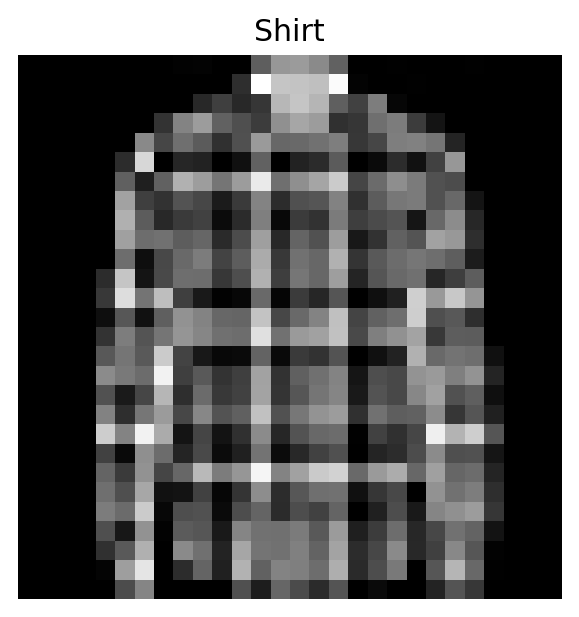

In [28]:
# We save both loss functions
np.savetxt('loss_to_plot.txt', loss_to_plot)
np.savetxt('loss_to_plot_test.txt', loss_to_plot_test)

# We choose an image and calculate the corresponding prediction generated by the model
for (X, y) in test_dl:
    pred_cpu = model(X)
    image_cpu = X[7]
    break

pred_cpu = pred_cpu[7].detach().numpy()

# We plot the image to be predicted and as a title the corresponding prediction
fig, ax = plt.subplots(1,1, dpi=180)
fig.set_size_inches(4.0, 4.0)
ax.axis("off")
plt.title(labels_map[np.argmax(pred_cpu)])
ax.imshow(image_cpu.squeeze(), cmap="gray")

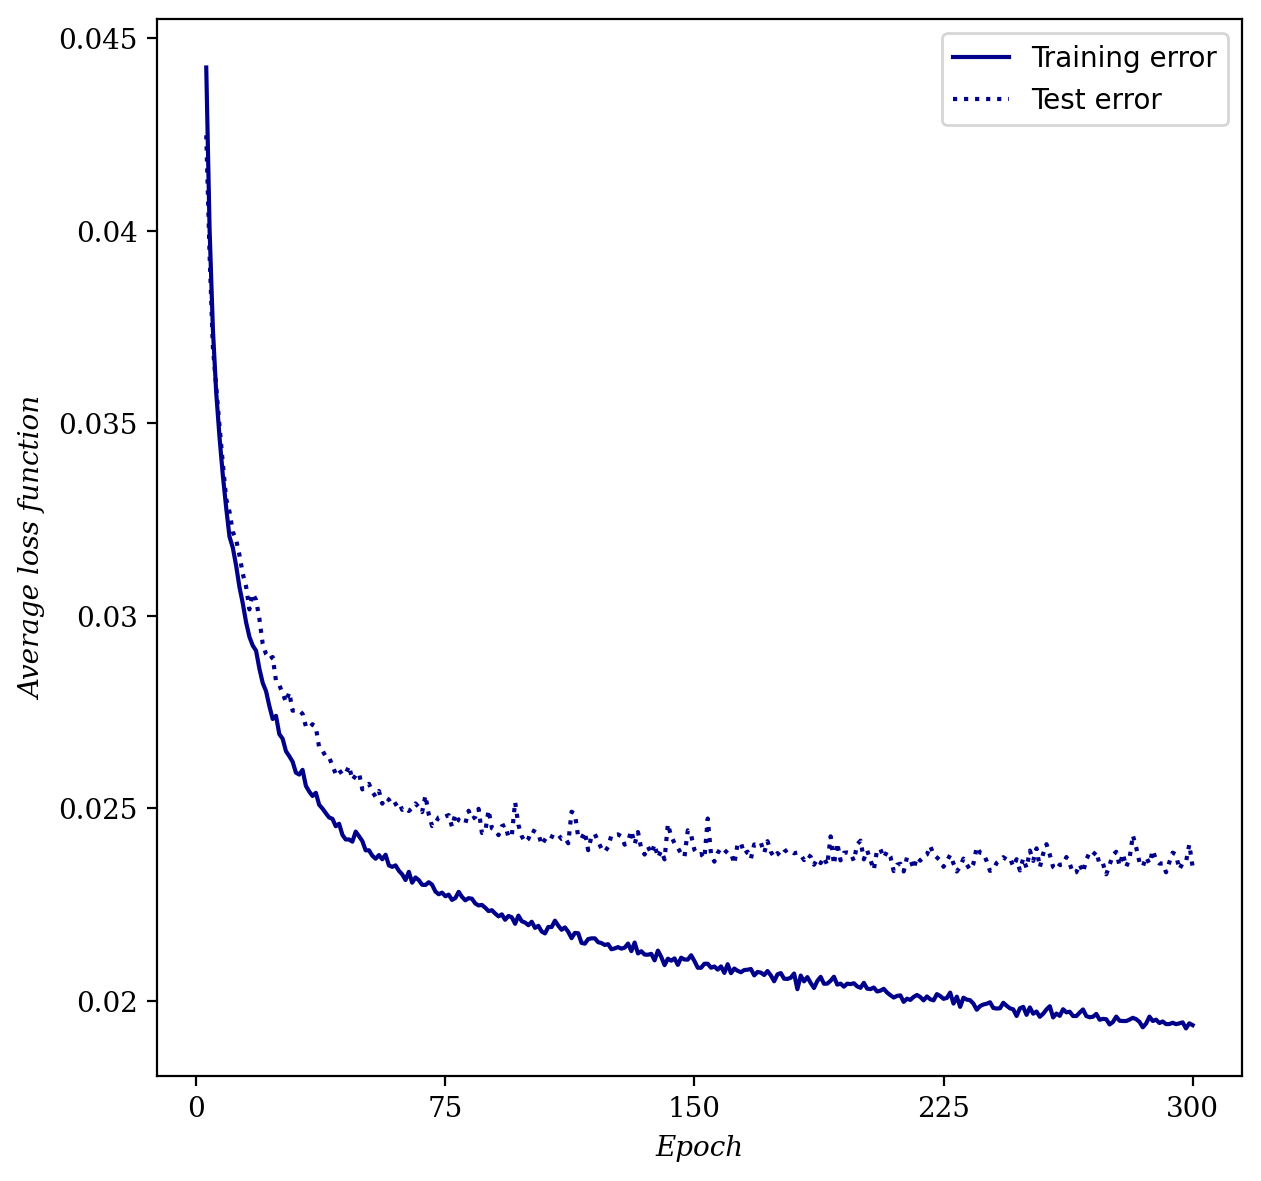

In [29]:
lp = np.loadtxt('loss_to_plot.txt')
lp_test = np.loadtxt('loss_to_plot_test.txt')

# Let us plot both loss functions
fig, ax = plt.subplots(1,1, figsize=(7,7), dpi=200)
ax.plot([i for i in range(3, n_epochs+1)], lp[2:], color='darkblue', lw=1.5, label='Training error')
ax.plot([i for i in range(3, n_epochs+1)], lp_test[2:], ls=':', color='darkblue', lw=1.5, label='Test error')
ax.set_xlabel('Epoch', fontproperties=fuente_nombre)
ax.set_ylabel('Average loss function', fontproperties=fuente_nombre)
ax.set_xticks([0, 75, 150, 225, 300])
ax.set_xticklabels(['0', '75', '150', '225', '300'], fontproperties=fuente_ejes)
y_ticks = [0.02, 0.025, 0.03, 0.035, 0.04, 0.045]
ax.set_yticks(y_ticks)
ax.set_yticklabels([str(y_ticks[i]) for i in range(len(y_ticks))], fontproperties=fuente_ejes)
plt.legend()
plt.show()
#plt.savefig('loss.jpg', bbox_inches='tight')

In order to avoid the model being overfitted, it is needed to train it during 300 epochs, because if it is trained during a greater number of epochs, can be seen a tendency of the average test loss function to start growing.

To conclude the analisys of the precision of the model, let us make a confusion matrix. That way, we will be able to see the tendencies of the model at the time of predict the input image.

In [30]:
# Let us define a function that get all the predictions made by the CNN
@torch.no_grad() # turn off gradients during inference for memory efficiency
def get_all_preds(network, dataloader):
    """function to return the number of correct predictions across data set"""
    all_preds = torch.tensor([])
    model = network
    tmp_labels = np.array([])
    for batch in dataloader:
        images, labels = batch
        tmp_labels = np.concatenate((tmp_labels, labels.argmax(1).numpy()))
        preds = model(images) # get preds
        all_preds = torch.cat((all_preds, preds), dim=0) # join along existing axis
    
    return all_preds, tmp_labels

# Let us define the function that plots the confusion matrix
def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=None, normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import itertools

    accuracy = np.trace(cm)/np.sum(cm).astype('float')
    
    if normalize:
        cm = cm.astype('float')/cm.sum(axis=1)[:, np.newaxis]

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(15, 10), dpi=300)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, font_properties=fuente_titulo)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45, font_properties=fuente_nombre)
        plt.yticks(tick_marks, target_names, font_properties=fuente_nombre)


    thresh = cm.max()/1.5 if normalize else cm.max()/2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    #plt.tight_layout()
    plt.ylabel('Correct class', font_properties=fuente_nombre)
    plt.xlabel('Predicted class', font_properties=fuente_nombre)
    plt.show()
    #plt.savefig('confusion_matrix.jpg', bbox_inches='tight')

Once defined the functions, let us get all the predictions made over the test set and plot them in the confusion matrix.

C:\Users\santy\anaconda3\envs\env-ml\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


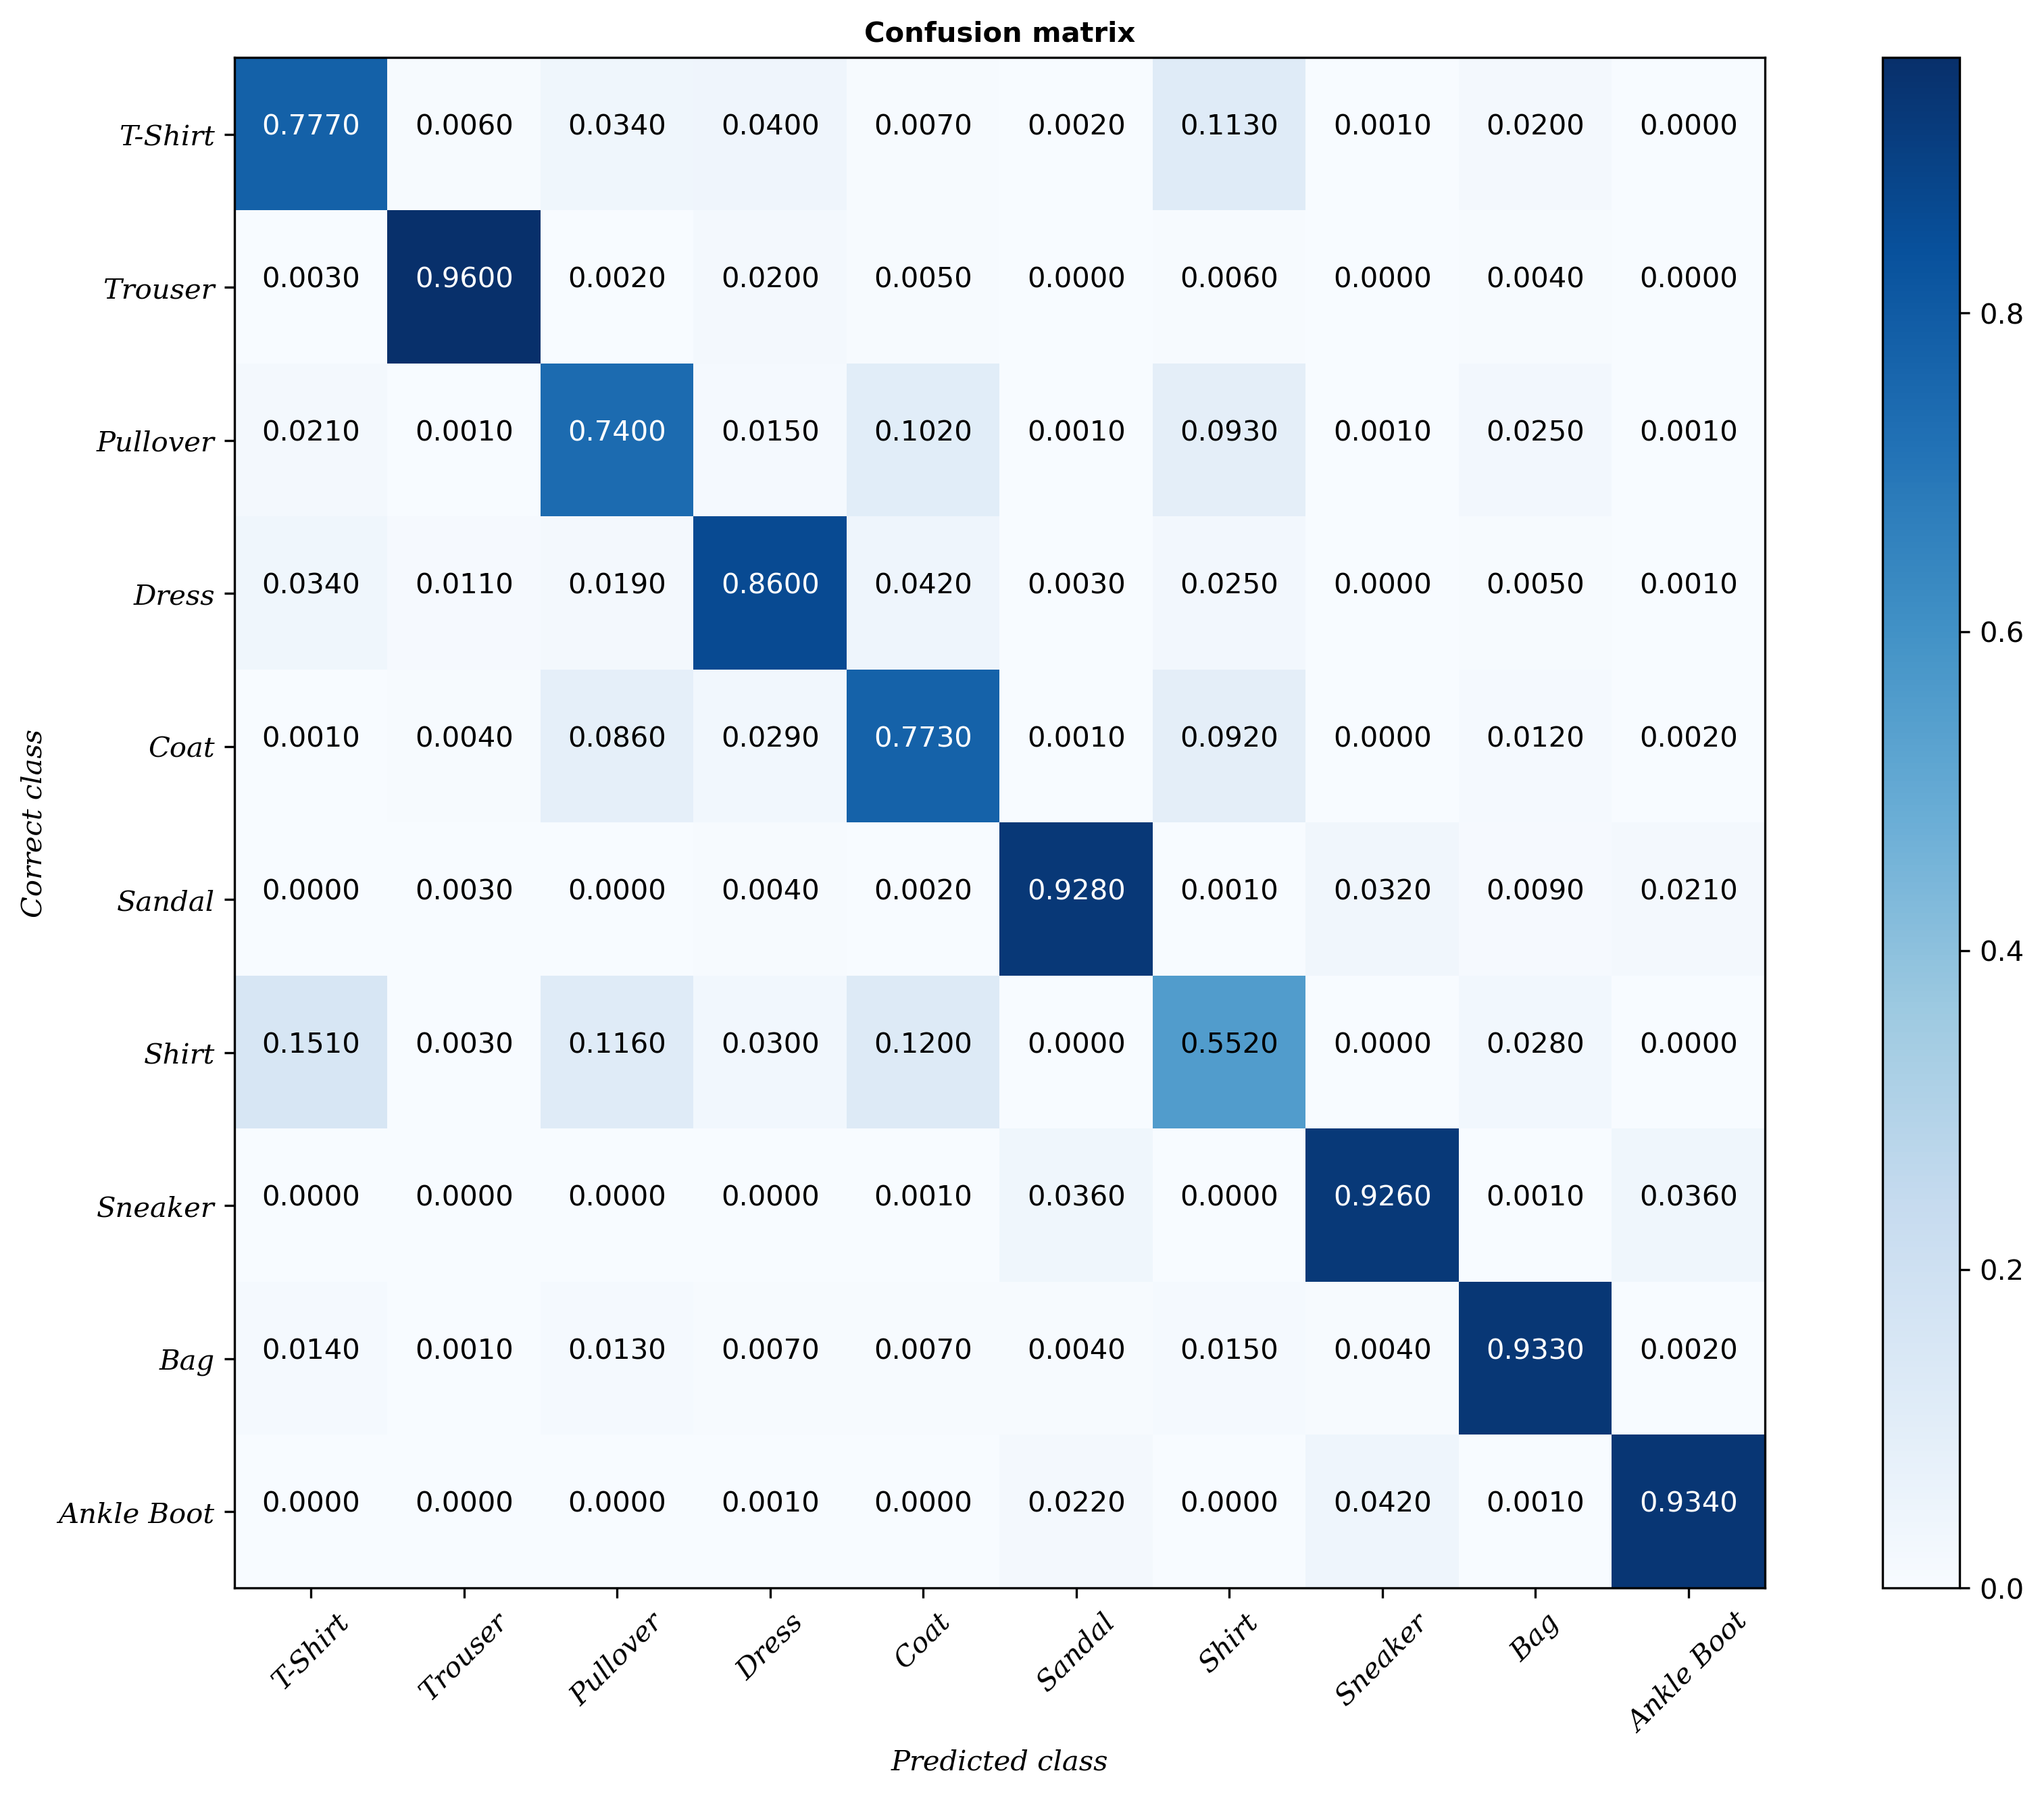

In [31]:
# Get the predictions over the test set
all_preds_test, labels_test = get_all_preds(network=model, dataloader=test_dl)

# Get the confusion matrix
cm = met.confusion_matrix(y_true=labels_test, y_pred=all_preds_test.argmax(1).numpy())

# Plot the predictions as a confusion matrix
plot_confusion_matrix(cm, target_names=labels_map.values(), cmap='Blues', normalize=True)

### References

[1] [A Comprehensive Guide to Convolutional Neural Networks — the ELI5 way](https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53)

[2] [Fashion MNIST classification using custom PyTorch Convolution Neural Network (CNN)](https://boscoj2008.github.io/customCNN/)

[3] [Convolutional Neural Networks](https://www.ibm.com/cloud/learn/convolutional-neural-networks)